# 1. Basic setting & data loading

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet50
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import torch.nn.utils.prune as prune
import numpy as np 
import random

/home/samuel/.conda/envs/model_compression/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
train_transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
test_transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),  # gray to 3 channel
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=8)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                            shuffle=False, num_workers=0)

# 2. Load teacher model

In [5]:
class ResNet(nn.Module):
        def __init__(self):
            super(ResNet, self).__init__()
            self.resnet50 = resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            num_ftrs = self.resnet50.fc.in_features
            self.resnet50.fc = nn.Linear(num_ftrs, 10)

        def forward(self, x):
            x = self.resnet50.conv1(x)
            x = self.resnet50.bn1(x)
            x = self.resnet50.relu(x)
            x = self.resnet50.maxpool(x)

            x = self.resnet50.layer1(x)
            x = self.resnet50.layer2(x)
            x = self.resnet50.layer3(x)
            x = self.resnet50.layer4(x)

            x = self.resnet50.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.resnet50.fc(x)
            return x

teacher_model = ResNet()
weights_path = './resnet-50.pth'
checkpoint = torch.load(weights_path)
teacher_model.load_state_dict(checkpoint['model_state_dict'])
teacher_model = teacher_model.to(device)

# 3. Build student model

## Depthwise-Separable-Convolution
Ref : https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch

In [6]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout,kernel_size = 3 , stride=1, padding=0): 
        super(depthwise_separable_conv, self).__init__() 
        self.depthwise = nn.Conv2d(nin, nin, kernel_size, stride = stride, padding = padding, groups=nin) 
        self.pointwise = nn.Conv2d(nin, nout, 1) 
    def forward(self, x): 
        out = self.depthwise(x) 
        out = self.pointwise(out) 
        return out

In [7]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            depthwise_separable_conv(3,64,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            depthwise_separable_conv(64,64,padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            
            depthwise_separable_conv(64,128,padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            depthwise_separable_conv(128,128,padding="same"),#add padding
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            
            depthwise_separable_conv(128,256,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            depthwise_separable_conv(256,256,padding="same"),#add padding
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            
            depthwise_separable_conv(256,256,padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            depthwise_separable_conv(256,512,padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # [128,1,1]
            nn.Flatten()
        )
        self.out = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,10)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.out(x)
        return x


In [8]:
student_model = StudentModel().to(device)
summary(student_model,input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
            Conv2d-2           [-1, 64, 28, 28]             256
depthwise_separable_conv-3           [-1, 64, 28, 28]               0
       BatchNorm2d-4           [-1, 64, 28, 28]             128
              ReLU-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]             640
            Conv2d-7           [-1, 64, 28, 28]           4,160
depthwise_separable_conv-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
        MaxPool2d-11           [-1, 64, 14, 14]               0
          Dropout-12           [-1, 64, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]             640
           Conv2d-14       

# 4. Knowledge distillation 
Ref : https://arxiv.org/abs/1503.02531、 https://github.com/shriramsb/Distilling-the-Knowledge-in-a-Neural-Network/blob/b9c2ec0f02e256711a4569157aa913e0b92c4848/utils.py#L117

In [9]:
def studentLossFn(teacher_pred, student_pred, y, T=3, alpha=0.4):
    if (alpha > 0):
        loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, y) * (1 - alpha)
    else:
        loss = F.cross_entropy(student_pred, y)
    return loss

In [10]:
def train_step(student_model,teacher_model, train_dataloader,train_loss_function, opt, device):
    train_acc = 0
    train_loss = 0
    student_model.train()
    for x,y in train_dataloader:
        x,y = x.to(device), y.to(device)
        student_pred = student_model(x)
        with torch.no_grad():
            teacher_pred = teacher_model(x) # disable teacher_model update
        loss = train_loss_function(teacher_pred,student_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        train_acc += (torch.max(student_pred,1)[1]==y).sum().item()/len(student_pred)
    return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

def test_step(student_model, test_dataloader, test_loss_function, device): 
    test_acc = 0
    test_loss = 0
    student_model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            x,y = x.to(device), y.to(device)
            pred_y = student_model(x)
            loss = test_loss_function(pred_y,y) 
            test_loss += loss.item()
            test_acc += (torch.argmax(pred_y,1)==y).sum().item()/len(pred_y)
    return test_loss/len(test_dataloader), test_acc/len(test_dataloader)
def train(epochs, student_model, teacher_model,
          train_dataloader, test_dataloader, opt, 
          train_loss_function,test_loss_function,
          device, patience,model_name,scheduler):
    last_loss = float("inf")
    cur = 0
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(student_model=student_model,
                                           teacher_model = teacher_model,
                                          train_dataloader=train_dataloader,
                                          train_loss_function=train_loss_function,
                                          opt=opt,
                                          device=device)
        test_loss, test_acc = test_step(student_model=student_model,
                                          test_dataloader=test_dataloader,
                                          test_loss_function=test_loss_function,
                                        device=device)
        if scheduler:    
            scheduler.step()
        if test_loss > last_loss:
            cur += 1
            print('trigger times:', cur)
            if cur >= patience:
                print("early stop !")
                return results
        else:
            cur = 0
        last_loss = test_loss
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if (epoch+1)%10 == 0:
            MODEL_PATH = Path(model_name)
            MODEL_PATH.mkdir(parents=True, 
                             exist_ok=True
            )

            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=student_model.state_dict(),
                       f=MODEL_SAVE_PATH)
    return results

In [11]:
# config 
LR =1e-4
EPOCH = 600

In [12]:
from torch.optim.lr_scheduler import StepLR
student_model = StudentModel().to(device)
opt = torch.optim.AdamW(student_model.parameters(),lr = LR )
results = train(EPOCH,
      student_model,teacher_model,
      trainloader,testloader,
      train_loss_function = studentLossFn,
      test_loss_function = nn.CrossEntropyLoss(),
      opt = opt,
      device=device,
      patience = 10,
      model_name = "unpruned_student_model",scheduler = None)

  0%|                        | 1/600 [00:18<3:08:27, 18.88s/it]

Epoch: 1 | train_loss: 3.4653 | train_acc: 0.5333 | test_loss: 0.8800 | test_acc: 0.7226


  0%|                        | 2/600 [00:37<3:07:57, 18.86s/it]

Epoch: 2 | train_loss: 1.5211 | train_acc: 0.7671 | test_loss: 0.6477 | test_acc: 0.7949


  0%|                        | 3/600 [00:56<3:07:50, 18.88s/it]

Epoch: 3 | train_loss: 1.2537 | train_acc: 0.8048 | test_loss: 0.5618 | test_acc: 0.8282


  1%|▏                       | 4/600 [01:15<3:07:28, 18.87s/it]

Epoch: 4 | train_loss: 1.1115 | train_acc: 0.8236 | test_loss: 0.5329 | test_acc: 0.8445


  1%|▏                       | 5/600 [01:34<3:07:22, 18.90s/it]

Epoch: 5 | train_loss: 1.0159 | train_acc: 0.8361 | test_loss: 0.4897 | test_acc: 0.8560


  1%|▏                       | 6/600 [01:53<3:07:13, 18.91s/it]

Epoch: 6 | train_loss: 0.9350 | train_acc: 0.8455 | test_loss: 0.4882 | test_acc: 0.8626


  1%|▎                       | 7/600 [02:12<3:06:54, 18.91s/it]

Epoch: 7 | train_loss: 0.8673 | train_acc: 0.8552 | test_loss: 0.4650 | test_acc: 0.8733


  1%|▎                       | 8/600 [02:31<3:06:38, 18.92s/it]

Epoch: 8 | train_loss: 0.8170 | train_acc: 0.8628 | test_loss: 0.4367 | test_acc: 0.8757


  2%|▎                       | 9/600 [02:50<3:06:40, 18.95s/it]

Epoch: 9 | train_loss: 0.7736 | train_acc: 0.8675 | test_loss: 0.4261 | test_acc: 0.8783


  2%|▍                      | 10/600 [03:09<3:06:32, 18.97s/it]

Epoch: 10 | train_loss: 0.7388 | train_acc: 0.8703 | test_loss: 0.4147 | test_acc: 0.8829
Saving model to: unpruned_student_model/model_10.pth


  2%|▍                      | 11/600 [03:28<3:05:54, 18.94s/it]

Epoch: 11 | train_loss: 0.6996 | train_acc: 0.8757 | test_loss: 0.3916 | test_acc: 0.8930


  2%|▍                      | 12/600 [03:47<3:05:35, 18.94s/it]

Epoch: 12 | train_loss: 0.6794 | train_acc: 0.8790 | test_loss: 0.3814 | test_acc: 0.8908


  2%|▍                      | 13/600 [04:05<3:05:04, 18.92s/it]

Epoch: 13 | train_loss: 0.6556 | train_acc: 0.8828 | test_loss: 0.3795 | test_acc: 0.8950


  2%|▌                      | 14/600 [04:24<3:04:39, 18.91s/it]

Epoch: 14 | train_loss: 0.6350 | train_acc: 0.8844 | test_loss: 0.3791 | test_acc: 0.8926


  2%|▌                      | 15/600 [04:43<3:04:43, 18.95s/it]

Epoch: 15 | train_loss: 0.6176 | train_acc: 0.8886 | test_loss: 0.3667 | test_acc: 0.8991


  3%|▌                      | 16/600 [05:02<3:04:09, 18.92s/it]

Epoch: 16 | train_loss: 0.6049 | train_acc: 0.8907 | test_loss: 0.3457 | test_acc: 0.8979


  3%|▋                      | 17/600 [05:21<3:04:01, 18.94s/it]

Epoch: 17 | train_loss: 0.5871 | train_acc: 0.8915 | test_loss: 0.3426 | test_acc: 0.8998


  3%|▋                      | 18/600 [05:40<3:03:57, 18.97s/it]

Epoch: 18 | train_loss: 0.5714 | train_acc: 0.8937 | test_loss: 0.3359 | test_acc: 0.9028


  3%|▋                      | 19/600 [05:59<3:03:32, 18.95s/it]

Epoch: 19 | train_loss: 0.5594 | train_acc: 0.8957 | test_loss: 0.3228 | test_acc: 0.9041


  3%|▊                      | 20/600 [06:18<3:03:09, 18.95s/it]

Epoch: 20 | train_loss: 0.5503 | train_acc: 0.8974 | test_loss: 0.3226 | test_acc: 0.9073
Saving model to: unpruned_student_model/model_20.pth


  4%|▊                      | 21/600 [06:37<3:02:57, 18.96s/it]

Epoch: 21 | train_loss: 0.5395 | train_acc: 0.8986 | test_loss: 0.3219 | test_acc: 0.9064


  4%|▊                      | 22/600 [06:56<3:02:39, 18.96s/it]

Epoch: 22 | train_loss: 0.5275 | train_acc: 0.8994 | test_loss: 0.3114 | test_acc: 0.9076


  4%|▉                      | 23/600 [07:15<3:02:25, 18.97s/it]

trigger times: 1
Epoch: 23 | train_loss: 0.5163 | train_acc: 0.9023 | test_loss: 0.3131 | test_acc: 0.9079


  4%|▉                      | 24/600 [07:34<3:02:08, 18.97s/it]

trigger times: 2
Epoch: 24 | train_loss: 0.5104 | train_acc: 0.9035 | test_loss: 0.3176 | test_acc: 0.9084


  4%|▉                      | 25/600 [07:53<3:01:50, 18.97s/it]

Epoch: 25 | train_loss: 0.4993 | train_acc: 0.9030 | test_loss: 0.2881 | test_acc: 0.9134


  4%|▉                      | 26/600 [08:12<3:01:44, 19.00s/it]

trigger times: 1
Epoch: 26 | train_loss: 0.4954 | train_acc: 0.9050 | test_loss: 0.3016 | test_acc: 0.9133


  4%|█                      | 27/600 [08:31<3:01:31, 19.01s/it]

trigger times: 2
Epoch: 27 | train_loss: 0.4865 | train_acc: 0.9046 | test_loss: 0.3120 | test_acc: 0.9087


  5%|█                      | 28/600 [08:50<3:00:55, 18.98s/it]

Epoch: 28 | train_loss: 0.4773 | train_acc: 0.9067 | test_loss: 0.2922 | test_acc: 0.9139


  5%|█                      | 29/600 [09:09<3:00:42, 18.99s/it]

Epoch: 29 | train_loss: 0.4758 | train_acc: 0.9084 | test_loss: 0.2866 | test_acc: 0.9137


  5%|█▏                     | 30/600 [09:28<3:00:33, 19.01s/it]

trigger times: 1
Epoch: 30 | train_loss: 0.4695 | train_acc: 0.9071 | test_loss: 0.2875 | test_acc: 0.9147
Saving model to: unpruned_student_model/model_30.pth


  5%|█▏                     | 31/600 [09:47<3:00:02, 18.99s/it]

Epoch: 31 | train_loss: 0.4618 | train_acc: 0.9090 | test_loss: 0.2845 | test_acc: 0.9161


  5%|█▏                     | 32/600 [10:06<2:59:29, 18.96s/it]

trigger times: 1
Epoch: 32 | train_loss: 0.4587 | train_acc: 0.9093 | test_loss: 0.2883 | test_acc: 0.9154


  6%|█▎                     | 33/600 [10:25<2:59:16, 18.97s/it]

Epoch: 33 | train_loss: 0.4504 | train_acc: 0.9116 | test_loss: 0.2793 | test_acc: 0.9145


  6%|█▎                     | 34/600 [10:44<2:58:57, 18.97s/it]

Epoch: 34 | train_loss: 0.4453 | train_acc: 0.9123 | test_loss: 0.2790 | test_acc: 0.9162


  6%|█▎                     | 35/600 [11:03<2:58:37, 18.97s/it]

Epoch: 35 | train_loss: 0.4434 | train_acc: 0.9117 | test_loss: 0.2685 | test_acc: 0.9176


  6%|█▍                     | 36/600 [11:22<2:58:25, 18.98s/it]

trigger times: 1
Epoch: 36 | train_loss: 0.4358 | train_acc: 0.9125 | test_loss: 0.2811 | test_acc: 0.9169


  6%|█▍                     | 37/600 [11:41<2:57:55, 18.96s/it]

Epoch: 37 | train_loss: 0.4306 | train_acc: 0.9139 | test_loss: 0.2701 | test_acc: 0.9187


  6%|█▍                     | 38/600 [12:00<2:57:33, 18.96s/it]

trigger times: 1
Epoch: 38 | train_loss: 0.4254 | train_acc: 0.9151 | test_loss: 0.2728 | test_acc: 0.9157


  6%|█▍                     | 39/600 [12:19<2:57:21, 18.97s/it]

trigger times: 2
Epoch: 39 | train_loss: 0.4183 | train_acc: 0.9161 | test_loss: 0.2741 | test_acc: 0.9176


  7%|█▌                     | 40/600 [12:38<2:57:06, 18.98s/it]

Epoch: 40 | train_loss: 0.4172 | train_acc: 0.9152 | test_loss: 0.2613 | test_acc: 0.9207
Saving model to: unpruned_student_model/model_40.pth


  7%|█▌                     | 41/600 [12:57<2:57:05, 19.01s/it]

trigger times: 1
Epoch: 41 | train_loss: 0.4114 | train_acc: 0.9165 | test_loss: 0.2630 | test_acc: 0.9206


  7%|█▌                     | 42/600 [13:16<2:56:45, 19.01s/it]

trigger times: 2
Epoch: 42 | train_loss: 0.4095 | train_acc: 0.9167 | test_loss: 0.2694 | test_acc: 0.9198


  7%|█▋                     | 43/600 [13:35<2:56:30, 19.01s/it]

Epoch: 43 | train_loss: 0.4049 | train_acc: 0.9174 | test_loss: 0.2693 | test_acc: 0.9187


  7%|█▋                     | 44/600 [13:54<2:56:19, 19.03s/it]

Epoch: 44 | train_loss: 0.4031 | train_acc: 0.9176 | test_loss: 0.2590 | test_acc: 0.9222


  8%|█▋                     | 45/600 [14:13<2:55:43, 19.00s/it]

trigger times: 1
Epoch: 45 | train_loss: 0.3959 | train_acc: 0.9189 | test_loss: 0.2633 | test_acc: 0.9177


  8%|█▊                     | 46/600 [14:32<2:55:20, 18.99s/it]

Epoch: 46 | train_loss: 0.3981 | train_acc: 0.9190 | test_loss: 0.2610 | test_acc: 0.9210


  8%|█▊                     | 47/600 [14:51<2:55:07, 19.00s/it]

Epoch: 47 | train_loss: 0.3937 | train_acc: 0.9203 | test_loss: 0.2530 | test_acc: 0.9227


  8%|█▊                     | 48/600 [15:10<2:54:52, 19.01s/it]

trigger times: 1
Epoch: 48 | train_loss: 0.3886 | train_acc: 0.9199 | test_loss: 0.2637 | test_acc: 0.9220


  8%|█▉                     | 49/600 [15:29<2:54:34, 19.01s/it]

Epoch: 49 | train_loss: 0.3843 | train_acc: 0.9206 | test_loss: 0.2515 | test_acc: 0.9229


  8%|█▉                     | 50/600 [15:48<2:54:19, 19.02s/it]

trigger times: 1
Epoch: 50 | train_loss: 0.3837 | train_acc: 0.9214 | test_loss: 0.2544 | test_acc: 0.9221
Saving model to: unpruned_student_model/model_50.pth


  8%|█▉                     | 51/600 [16:07<2:53:56, 19.01s/it]

Epoch: 51 | train_loss: 0.3807 | train_acc: 0.9211 | test_loss: 0.2510 | test_acc: 0.9235


  9%|█▉                     | 52/600 [16:26<2:53:22, 18.98s/it]

trigger times: 1
Epoch: 52 | train_loss: 0.3770 | train_acc: 0.9229 | test_loss: 0.2527 | test_acc: 0.9241


  9%|██                     | 53/600 [16:45<2:52:56, 18.97s/it]

Epoch: 53 | train_loss: 0.3754 | train_acc: 0.9222 | test_loss: 0.2520 | test_acc: 0.9231


  9%|██                     | 54/600 [17:04<2:52:42, 18.98s/it]

trigger times: 1
Epoch: 54 | train_loss: 0.3710 | train_acc: 0.9236 | test_loss: 0.2529 | test_acc: 0.9218


  9%|██                     | 55/600 [17:23<2:52:20, 18.97s/it]

Epoch: 55 | train_loss: 0.3681 | train_acc: 0.9257 | test_loss: 0.2484 | test_acc: 0.9238


  9%|██▏                    | 56/600 [17:42<2:52:06, 18.98s/it]

Epoch: 56 | train_loss: 0.3677 | train_acc: 0.9233 | test_loss: 0.2461 | test_acc: 0.9209


 10%|██▏                    | 57/600 [18:01<2:51:47, 18.98s/it]

trigger times: 1
Epoch: 57 | train_loss: 0.3642 | train_acc: 0.9242 | test_loss: 0.2509 | test_acc: 0.9220


 10%|██▏                    | 58/600 [18:20<2:51:39, 19.00s/it]

Epoch: 58 | train_loss: 0.3587 | train_acc: 0.9257 | test_loss: 0.2440 | test_acc: 0.9249


 10%|██▎                    | 59/600 [18:39<2:51:35, 19.03s/it]

Epoch: 59 | train_loss: 0.3564 | train_acc: 0.9269 | test_loss: 0.2416 | test_acc: 0.9266


 10%|██▎                    | 60/600 [18:58<2:51:06, 19.01s/it]

trigger times: 1
Epoch: 60 | train_loss: 0.3562 | train_acc: 0.9266 | test_loss: 0.2468 | test_acc: 0.9257
Saving model to: unpruned_student_model/model_60.pth


 10%|██▎                    | 61/600 [19:17<2:50:50, 19.02s/it]

Epoch: 61 | train_loss: 0.3556 | train_acc: 0.9262 | test_loss: 0.2420 | test_acc: 0.9253


 10%|██▍                    | 62/600 [19:36<2:50:20, 19.00s/it]

Epoch: 62 | train_loss: 0.3542 | train_acc: 0.9265 | test_loss: 0.2372 | test_acc: 0.9271


 10%|██▍                    | 63/600 [19:55<2:49:58, 18.99s/it]

Epoch: 63 | train_loss: 0.3488 | train_acc: 0.9270 | test_loss: 0.2358 | test_acc: 0.9271


 11%|██▍                    | 64/600 [20:14<2:49:24, 18.96s/it]

trigger times: 1
Epoch: 64 | train_loss: 0.3478 | train_acc: 0.9270 | test_loss: 0.2390 | test_acc: 0.9263


 11%|██▍                    | 65/600 [20:33<2:49:14, 18.98s/it]

trigger times: 2
Epoch: 65 | train_loss: 0.3482 | train_acc: 0.9283 | test_loss: 0.2417 | test_acc: 0.9257


 11%|██▌                    | 66/600 [20:52<2:49:14, 19.02s/it]

Epoch: 66 | train_loss: 0.3480 | train_acc: 0.9279 | test_loss: 0.2401 | test_acc: 0.9260


 11%|██▌                    | 67/600 [21:11<2:48:53, 19.01s/it]

Epoch: 67 | train_loss: 0.3436 | train_acc: 0.9291 | test_loss: 0.2373 | test_acc: 0.9262


 11%|██▌                    | 68/600 [21:30<2:48:27, 19.00s/it]

trigger times: 1
Epoch: 68 | train_loss: 0.3386 | train_acc: 0.9289 | test_loss: 0.2397 | test_acc: 0.9262


 12%|██▋                    | 69/600 [21:49<2:47:58, 18.98s/it]

trigger times: 2
Epoch: 69 | train_loss: 0.3385 | train_acc: 0.9287 | test_loss: 0.2468 | test_acc: 0.9245


 12%|██▋                    | 70/600 [22:08<2:47:39, 18.98s/it]

Epoch: 70 | train_loss: 0.3404 | train_acc: 0.9288 | test_loss: 0.2416 | test_acc: 0.9277
Saving model to: unpruned_student_model/model_70.pth


 12%|██▋                    | 71/600 [22:27<2:47:32, 19.00s/it]

Epoch: 71 | train_loss: 0.3359 | train_acc: 0.9293 | test_loss: 0.2366 | test_acc: 0.9261


 12%|██▊                    | 72/600 [22:46<2:47:16, 19.01s/it]

trigger times: 1
Epoch: 72 | train_loss: 0.3365 | train_acc: 0.9293 | test_loss: 0.2387 | test_acc: 0.9286


 12%|██▊                    | 73/600 [23:05<2:47:10, 19.03s/it]

Epoch: 73 | train_loss: 0.3316 | train_acc: 0.9300 | test_loss: 0.2360 | test_acc: 0.9276


 12%|██▊                    | 74/600 [23:24<2:46:40, 19.01s/it]

Epoch: 74 | train_loss: 0.3332 | train_acc: 0.9298 | test_loss: 0.2335 | test_acc: 0.9283


 12%|██▉                    | 75/600 [23:43<2:46:23, 19.02s/it]

trigger times: 1
Epoch: 75 | train_loss: 0.3306 | train_acc: 0.9296 | test_loss: 0.2346 | test_acc: 0.9257


 13%|██▉                    | 76/600 [24:02<2:45:58, 19.01s/it]

trigger times: 2
Epoch: 76 | train_loss: 0.3288 | train_acc: 0.9309 | test_loss: 0.2355 | test_acc: 0.9286


 13%|██▉                    | 77/600 [24:21<2:45:38, 19.00s/it]

trigger times: 3
Epoch: 77 | train_loss: 0.3205 | train_acc: 0.9319 | test_loss: 0.2371 | test_acc: 0.9273


 13%|██▉                    | 78/600 [24:40<2:45:15, 19.00s/it]

Epoch: 78 | train_loss: 0.3249 | train_acc: 0.9310 | test_loss: 0.2316 | test_acc: 0.9276


 13%|███                    | 79/600 [24:59<2:44:50, 18.98s/it]

trigger times: 1
Epoch: 79 | train_loss: 0.3229 | train_acc: 0.9308 | test_loss: 0.2326 | test_acc: 0.9283


 13%|███                    | 80/600 [25:18<2:44:39, 19.00s/it]

Epoch: 80 | train_loss: 0.3211 | train_acc: 0.9331 | test_loss: 0.2321 | test_acc: 0.9277
Saving model to: unpruned_student_model/model_80.pth


 14%|███                    | 81/600 [25:37<2:44:21, 19.00s/it]

Epoch: 81 | train_loss: 0.3197 | train_acc: 0.9329 | test_loss: 0.2288 | test_acc: 0.9290


 14%|███▏                   | 82/600 [25:56<2:44:06, 19.01s/it]

trigger times: 1
Epoch: 82 | train_loss: 0.3175 | train_acc: 0.9323 | test_loss: 0.2331 | test_acc: 0.9310


 14%|███▏                   | 83/600 [26:15<2:43:56, 19.03s/it]

Epoch: 83 | train_loss: 0.3177 | train_acc: 0.9332 | test_loss: 0.2285 | test_acc: 0.9292


 14%|███▏                   | 84/600 [26:34<2:43:32, 19.02s/it]

trigger times: 1
Epoch: 84 | train_loss: 0.3137 | train_acc: 0.9339 | test_loss: 0.2297 | test_acc: 0.9287


 14%|███▎                   | 85/600 [26:53<2:43:15, 19.02s/it]

trigger times: 2
Epoch: 85 | train_loss: 0.3143 | train_acc: 0.9339 | test_loss: 0.2338 | test_acc: 0.9284


 14%|███▎                   | 86/600 [27:12<2:42:59, 19.03s/it]

Epoch: 86 | train_loss: 0.3150 | train_acc: 0.9329 | test_loss: 0.2309 | test_acc: 0.9286


 14%|███▎                   | 87/600 [27:31<2:42:39, 19.02s/it]

trigger times: 1
Epoch: 87 | train_loss: 0.3089 | train_acc: 0.9350 | test_loss: 0.2328 | test_acc: 0.9288


 15%|███▎                   | 88/600 [27:50<2:42:07, 19.00s/it]

Epoch: 88 | train_loss: 0.3098 | train_acc: 0.9338 | test_loss: 0.2236 | test_acc: 0.9313


 15%|███▍                   | 89/600 [28:09<2:41:37, 18.98s/it]

trigger times: 1
Epoch: 89 | train_loss: 0.3079 | train_acc: 0.9351 | test_loss: 0.2266 | test_acc: 0.9298


 15%|███▍                   | 90/600 [28:28<2:41:19, 18.98s/it]

Epoch: 90 | train_loss: 0.3074 | train_acc: 0.9354 | test_loss: 0.2244 | test_acc: 0.9297
Saving model to: unpruned_student_model/model_90.pth


 15%|███▍                   | 91/600 [28:47<2:40:48, 18.96s/it]

Epoch: 91 | train_loss: 0.3083 | train_acc: 0.9350 | test_loss: 0.2239 | test_acc: 0.9301


 15%|███▌                   | 92/600 [29:06<2:40:29, 18.96s/it]

trigger times: 1
Epoch: 92 | train_loss: 0.3052 | train_acc: 0.9349 | test_loss: 0.2254 | test_acc: 0.9301


 16%|███▌                   | 93/600 [29:25<2:40:20, 18.98s/it]

trigger times: 2
Epoch: 93 | train_loss: 0.3065 | train_acc: 0.9348 | test_loss: 0.2273 | test_acc: 0.9294


 16%|███▌                   | 94/600 [29:44<2:39:59, 18.97s/it]

Epoch: 94 | train_loss: 0.3031 | train_acc: 0.9368 | test_loss: 0.2251 | test_acc: 0.9300


 16%|███▋                   | 95/600 [30:03<2:39:39, 18.97s/it]

Epoch: 95 | train_loss: 0.3015 | train_acc: 0.9365 | test_loss: 0.2250 | test_acc: 0.9312


 16%|███▋                   | 96/600 [30:22<2:39:30, 18.99s/it]

Epoch: 96 | train_loss: 0.3026 | train_acc: 0.9358 | test_loss: 0.2236 | test_acc: 0.9289


 16%|███▋                   | 97/600 [30:41<2:39:04, 18.98s/it]

trigger times: 1
Epoch: 97 | train_loss: 0.2989 | train_acc: 0.9378 | test_loss: 0.2245 | test_acc: 0.9318


 16%|███▊                   | 98/600 [31:00<2:38:47, 18.98s/it]

trigger times: 2
Epoch: 98 | train_loss: 0.2977 | train_acc: 0.9375 | test_loss: 0.2273 | test_acc: 0.9293


 16%|███▊                   | 99/600 [31:19<2:38:34, 18.99s/it]

Epoch: 99 | train_loss: 0.2965 | train_acc: 0.9366 | test_loss: 0.2252 | test_acc: 0.9311


 17%|███▋                  | 100/600 [31:38<2:38:20, 19.00s/it]

Epoch: 100 | train_loss: 0.2964 | train_acc: 0.9377 | test_loss: 0.2198 | test_acc: 0.9312
Saving model to: unpruned_student_model/model_100.pth


 17%|███▋                  | 101/600 [31:57<2:37:55, 18.99s/it]

trigger times: 1
Epoch: 101 | train_loss: 0.2937 | train_acc: 0.9382 | test_loss: 0.2284 | test_acc: 0.9314


 17%|███▋                  | 102/600 [32:16<2:37:39, 19.00s/it]

Epoch: 102 | train_loss: 0.2946 | train_acc: 0.9370 | test_loss: 0.2265 | test_acc: 0.9314


 17%|███▊                  | 103/600 [32:34<2:37:12, 18.98s/it]

trigger times: 1
Epoch: 103 | train_loss: 0.2914 | train_acc: 0.9389 | test_loss: 0.2283 | test_acc: 0.9309


 17%|███▊                  | 104/600 [32:53<2:36:53, 18.98s/it]

Epoch: 104 | train_loss: 0.2907 | train_acc: 0.9392 | test_loss: 0.2230 | test_acc: 0.9308


 18%|███▊                  | 105/600 [33:12<2:36:40, 18.99s/it]

trigger times: 1
Epoch: 105 | train_loss: 0.2886 | train_acc: 0.9383 | test_loss: 0.2285 | test_acc: 0.9288


 18%|███▉                  | 106/600 [33:31<2:36:26, 19.00s/it]

Epoch: 106 | train_loss: 0.2889 | train_acc: 0.9388 | test_loss: 0.2225 | test_acc: 0.9314


 18%|███▉                  | 107/600 [33:50<2:36:03, 18.99s/it]

trigger times: 1
Epoch: 107 | train_loss: 0.2849 | train_acc: 0.9396 | test_loss: 0.2256 | test_acc: 0.9297


 18%|███▉                  | 108/600 [34:10<2:36:00, 19.02s/it]

Epoch: 108 | train_loss: 0.2862 | train_acc: 0.9397 | test_loss: 0.2210 | test_acc: 0.9321


 18%|███▉                  | 109/600 [34:29<2:36:18, 19.10s/it]

trigger times: 1
Epoch: 109 | train_loss: 0.2859 | train_acc: 0.9395 | test_loss: 0.2260 | test_acc: 0.9312


 18%|████                  | 110/600 [34:48<2:35:49, 19.08s/it]

Epoch: 110 | train_loss: 0.2846 | train_acc: 0.9397 | test_loss: 0.2255 | test_acc: 0.9327
Saving model to: unpruned_student_model/model_110.pth


 18%|████                  | 111/600 [35:07<2:35:31, 19.08s/it]

trigger times: 1
Epoch: 111 | train_loss: 0.2832 | train_acc: 0.9400 | test_loss: 0.2269 | test_acc: 0.9316


 19%|████                  | 112/600 [35:26<2:35:04, 19.07s/it]

Epoch: 112 | train_loss: 0.2822 | train_acc: 0.9402 | test_loss: 0.2214 | test_acc: 0.9325


 19%|████▏                 | 113/600 [35:45<2:34:39, 19.06s/it]

trigger times: 1
Epoch: 113 | train_loss: 0.2815 | train_acc: 0.9406 | test_loss: 0.2233 | test_acc: 0.9306


 19%|████▏                 | 114/600 [36:04<2:34:10, 19.03s/it]

trigger times: 2
Epoch: 114 | train_loss: 0.2786 | train_acc: 0.9409 | test_loss: 0.2240 | test_acc: 0.9320


 19%|████▏                 | 115/600 [36:23<2:33:51, 19.03s/it]

Epoch: 115 | train_loss: 0.2825 | train_acc: 0.9396 | test_loss: 0.2239 | test_acc: 0.9309


 19%|████▎                 | 116/600 [36:42<2:33:35, 19.04s/it]

trigger times: 1
Epoch: 116 | train_loss: 0.2783 | train_acc: 0.9408 | test_loss: 0.2256 | test_acc: 0.9324


 20%|████▎                 | 117/600 [37:01<2:33:14, 19.04s/it]

Epoch: 117 | train_loss: 0.2801 | train_acc: 0.9412 | test_loss: 0.2205 | test_acc: 0.9312


 20%|████▎                 | 118/600 [37:20<2:32:43, 19.01s/it]

trigger times: 1
Epoch: 118 | train_loss: 0.2758 | train_acc: 0.9425 | test_loss: 0.2241 | test_acc: 0.9305


 20%|████▎                 | 119/600 [37:39<2:32:17, 19.00s/it]

Epoch: 119 | train_loss: 0.2779 | train_acc: 0.9411 | test_loss: 0.2236 | test_acc: 0.9318


 20%|████▍                 | 120/600 [37:58<2:31:54, 18.99s/it]

Epoch: 120 | train_loss: 0.2745 | train_acc: 0.9419 | test_loss: 0.2218 | test_acc: 0.9331
Saving model to: unpruned_student_model/model_120.pth


 20%|████▍                 | 121/600 [38:17<2:31:22, 18.96s/it]

Epoch: 121 | train_loss: 0.2743 | train_acc: 0.9423 | test_loss: 0.2195 | test_acc: 0.9312


 20%|████▍                 | 122/600 [38:36<2:31:13, 18.98s/it]

trigger times: 1
Epoch: 122 | train_loss: 0.2745 | train_acc: 0.9429 | test_loss: 0.2259 | test_acc: 0.9306


 20%|████▌                 | 123/600 [38:55<2:31:04, 19.00s/it]

Epoch: 123 | train_loss: 0.2692 | train_acc: 0.9435 | test_loss: 0.2235 | test_acc: 0.9318


 21%|████▌                 | 124/600 [39:14<2:30:44, 19.00s/it]

Epoch: 124 | train_loss: 0.2750 | train_acc: 0.9413 | test_loss: 0.2170 | test_acc: 0.9330


 21%|████▌                 | 125/600 [39:33<2:30:23, 19.00s/it]

trigger times: 1
Epoch: 125 | train_loss: 0.2730 | train_acc: 0.9421 | test_loss: 0.2217 | test_acc: 0.9308


 21%|████▌                 | 126/600 [39:52<2:30:01, 18.99s/it]

trigger times: 2
Epoch: 126 | train_loss: 0.2704 | train_acc: 0.9432 | test_loss: 0.2262 | test_acc: 0.9310


 21%|████▋                 | 127/600 [40:11<2:29:38, 18.98s/it]

Epoch: 127 | train_loss: 0.2699 | train_acc: 0.9425 | test_loss: 0.2238 | test_acc: 0.9334


 21%|████▋                 | 128/600 [40:30<2:29:25, 18.99s/it]

Epoch: 128 | train_loss: 0.2685 | train_acc: 0.9433 | test_loss: 0.2195 | test_acc: 0.9317


 22%|████▋                 | 129/600 [40:49<2:29:02, 18.99s/it]

Epoch: 129 | train_loss: 0.2684 | train_acc: 0.9439 | test_loss: 0.2186 | test_acc: 0.9342


 22%|████▊                 | 130/600 [41:08<2:28:41, 18.98s/it]

trigger times: 1
Epoch: 130 | train_loss: 0.2699 | train_acc: 0.9443 | test_loss: 0.2221 | test_acc: 0.9327
Saving model to: unpruned_student_model/model_130.pth


 22%|████▊                 | 131/600 [41:27<2:28:23, 18.98s/it]

trigger times: 2
Epoch: 131 | train_loss: 0.2670 | train_acc: 0.9433 | test_loss: 0.2222 | test_acc: 0.9305


 22%|████▊                 | 132/600 [41:46<2:28:17, 19.01s/it]

Epoch: 132 | train_loss: 0.2641 | train_acc: 0.9443 | test_loss: 0.2187 | test_acc: 0.9326


 22%|████▉                 | 133/600 [42:05<2:28:04, 19.02s/it]

trigger times: 1
Epoch: 133 | train_loss: 0.2656 | train_acc: 0.9441 | test_loss: 0.2196 | test_acc: 0.9319


 22%|████▉                 | 134/600 [42:24<2:27:38, 19.01s/it]

Epoch: 134 | train_loss: 0.2653 | train_acc: 0.9447 | test_loss: 0.2193 | test_acc: 0.9325


 22%|████▉                 | 135/600 [42:43<2:27:16, 19.00s/it]

trigger times: 1
Epoch: 135 | train_loss: 0.2629 | train_acc: 0.9457 | test_loss: 0.2203 | test_acc: 0.9327


 23%|████▉                 | 136/600 [43:02<2:26:50, 18.99s/it]

Epoch: 136 | train_loss: 0.2639 | train_acc: 0.9452 | test_loss: 0.2163 | test_acc: 0.9328


 23%|█████                 | 137/600 [43:21<2:26:24, 18.97s/it]

trigger times: 1
Epoch: 137 | train_loss: 0.2642 | train_acc: 0.9448 | test_loss: 0.2209 | test_acc: 0.9333


 23%|█████                 | 138/600 [43:40<2:26:03, 18.97s/it]

Epoch: 138 | train_loss: 0.2600 | train_acc: 0.9446 | test_loss: 0.2186 | test_acc: 0.9321


 23%|█████                 | 139/600 [43:59<2:25:38, 18.95s/it]

Epoch: 139 | train_loss: 0.2637 | train_acc: 0.9439 | test_loss: 0.2154 | test_acc: 0.9333


 23%|█████▏                | 140/600 [44:18<2:25:39, 19.00s/it]

trigger times: 1
Epoch: 140 | train_loss: 0.2614 | train_acc: 0.9453 | test_loss: 0.2164 | test_acc: 0.9330
Saving model to: unpruned_student_model/model_140.pth


 24%|█████▏                | 141/600 [44:37<2:25:16, 18.99s/it]

trigger times: 2
Epoch: 141 | train_loss: 0.2616 | train_acc: 0.9452 | test_loss: 0.2247 | test_acc: 0.9319


 24%|█████▏                | 142/600 [44:56<2:24:50, 18.98s/it]

Epoch: 142 | train_loss: 0.2598 | train_acc: 0.9455 | test_loss: 0.2207 | test_acc: 0.9338


 24%|█████▏                | 143/600 [45:15<2:24:32, 18.98s/it]

trigger times: 1
Epoch: 143 | train_loss: 0.2590 | train_acc: 0.9457 | test_loss: 0.2212 | test_acc: 0.9328


 24%|█████▎                | 144/600 [45:34<2:24:12, 18.97s/it]

Epoch: 144 | train_loss: 0.2566 | train_acc: 0.9465 | test_loss: 0.2171 | test_acc: 0.9342


 24%|█████▎                | 145/600 [45:53<2:23:54, 18.98s/it]

Epoch: 145 | train_loss: 0.2594 | train_acc: 0.9454 | test_loss: 0.2169 | test_acc: 0.9335


 24%|█████▎                | 146/600 [46:12<2:23:35, 18.98s/it]

trigger times: 1
Epoch: 146 | train_loss: 0.2560 | train_acc: 0.9470 | test_loss: 0.2189 | test_acc: 0.9328


 24%|█████▍                | 147/600 [46:31<2:23:24, 18.99s/it]

trigger times: 2
Epoch: 147 | train_loss: 0.2567 | train_acc: 0.9459 | test_loss: 0.2199 | test_acc: 0.9340


 25%|█████▍                | 148/600 [46:50<2:23:01, 18.99s/it]

Epoch: 148 | train_loss: 0.2569 | train_acc: 0.9459 | test_loss: 0.2181 | test_acc: 0.9334


 25%|█████▍                | 149/600 [47:09<2:22:50, 19.00s/it]

Epoch: 149 | train_loss: 0.2560 | train_acc: 0.9469 | test_loss: 0.2158 | test_acc: 0.9335


 25%|█████▌                | 150/600 [47:28<2:22:39, 19.02s/it]

Epoch: 150 | train_loss: 0.2550 | train_acc: 0.9467 | test_loss: 0.2151 | test_acc: 0.9358
Saving model to: unpruned_student_model/model_150.pth


 25%|█████▌                | 151/600 [47:47<2:22:04, 18.99s/it]

trigger times: 1
Epoch: 151 | train_loss: 0.2515 | train_acc: 0.9482 | test_loss: 0.2161 | test_acc: 0.9335


 25%|█████▌                | 152/600 [48:06<2:21:36, 18.97s/it]

Epoch: 152 | train_loss: 0.2496 | train_acc: 0.9483 | test_loss: 0.2160 | test_acc: 0.9341


 26%|█████▌                | 153/600 [48:25<2:21:36, 19.01s/it]

trigger times: 1
Epoch: 153 | train_loss: 0.2509 | train_acc: 0.9467 | test_loss: 0.2190 | test_acc: 0.9354


 26%|█████▋                | 154/600 [48:44<2:21:07, 18.99s/it]

trigger times: 2
Epoch: 154 | train_loss: 0.2524 | train_acc: 0.9472 | test_loss: 0.2200 | test_acc: 0.9339


 26%|█████▋                | 155/600 [49:03<2:20:36, 18.96s/it]

Epoch: 155 | train_loss: 0.2481 | train_acc: 0.9476 | test_loss: 0.2182 | test_acc: 0.9340


 26%|█████▋                | 156/600 [49:21<2:20:14, 18.95s/it]

trigger times: 1
Epoch: 156 | train_loss: 0.2502 | train_acc: 0.9475 | test_loss: 0.2193 | test_acc: 0.9327


 26%|█████▊                | 157/600 [49:40<2:19:56, 18.95s/it]

Epoch: 157 | train_loss: 0.2473 | train_acc: 0.9491 | test_loss: 0.2165 | test_acc: 0.9342


 26%|█████▊                | 158/600 [49:59<2:19:41, 18.96s/it]

trigger times: 1
Epoch: 158 | train_loss: 0.2467 | train_acc: 0.9483 | test_loss: 0.2202 | test_acc: 0.9340


 26%|█████▊                | 159/600 [50:18<2:19:29, 18.98s/it]

Epoch: 159 | train_loss: 0.2497 | train_acc: 0.9475 | test_loss: 0.2165 | test_acc: 0.9341


 27%|█████▊                | 160/600 [50:37<2:19:13, 18.99s/it]

trigger times: 1
Epoch: 160 | train_loss: 0.2470 | train_acc: 0.9484 | test_loss: 0.2196 | test_acc: 0.9318
Saving model to: unpruned_student_model/model_160.pth


 27%|█████▉                | 161/600 [50:56<2:18:40, 18.95s/it]

trigger times: 2
Epoch: 161 | train_loss: 0.2494 | train_acc: 0.9487 | test_loss: 0.2202 | test_acc: 0.9331


 27%|█████▉                | 162/600 [51:15<2:18:30, 18.97s/it]

Epoch: 162 | train_loss: 0.2485 | train_acc: 0.9482 | test_loss: 0.2185 | test_acc: 0.9328


 27%|█████▉                | 163/600 [51:34<2:18:13, 18.98s/it]

Epoch: 163 | train_loss: 0.2486 | train_acc: 0.9487 | test_loss: 0.2170 | test_acc: 0.9339


 27%|██████                | 164/600 [51:53<2:18:02, 19.00s/it]

trigger times: 1
Epoch: 164 | train_loss: 0.2462 | train_acc: 0.9487 | test_loss: 0.2197 | test_acc: 0.9335


 28%|██████                | 165/600 [52:12<2:17:37, 18.98s/it]

Epoch: 165 | train_loss: 0.2444 | train_acc: 0.9488 | test_loss: 0.2164 | test_acc: 0.9329


 28%|██████                | 166/600 [52:31<2:17:17, 18.98s/it]

Epoch: 166 | train_loss: 0.2471 | train_acc: 0.9492 | test_loss: 0.2101 | test_acc: 0.9346


 28%|██████                | 167/600 [52:50<2:16:56, 18.97s/it]

trigger times: 1
Epoch: 167 | train_loss: 0.2460 | train_acc: 0.9487 | test_loss: 0.2195 | test_acc: 0.9328


 28%|██████▏               | 168/600 [53:09<2:16:34, 18.97s/it]

Epoch: 168 | train_loss: 0.2407 | train_acc: 0.9504 | test_loss: 0.2174 | test_acc: 0.9329


 28%|██████▏               | 169/600 [53:28<2:16:24, 18.99s/it]

trigger times: 1
Epoch: 169 | train_loss: 0.2408 | train_acc: 0.9496 | test_loss: 0.2209 | test_acc: 0.9325


 28%|██████▏               | 170/600 [53:47<2:16:10, 19.00s/it]

Epoch: 170 | train_loss: 0.2389 | train_acc: 0.9500 | test_loss: 0.2160 | test_acc: 0.9341
Saving model to: unpruned_student_model/model_170.pth


 28%|██████▎               | 171/600 [54:06<2:15:48, 18.99s/it]

trigger times: 1
Epoch: 171 | train_loss: 0.2440 | train_acc: 0.9497 | test_loss: 0.2174 | test_acc: 0.9346


 29%|██████▎               | 172/600 [54:25<2:15:32, 19.00s/it]

Epoch: 172 | train_loss: 0.2418 | train_acc: 0.9491 | test_loss: 0.2170 | test_acc: 0.9362


 29%|██████▎               | 173/600 [54:44<2:15:15, 19.01s/it]

Epoch: 173 | train_loss: 0.2418 | train_acc: 0.9500 | test_loss: 0.2125 | test_acc: 0.9347


 29%|██████▍               | 174/600 [55:03<2:14:52, 19.00s/it]

trigger times: 1
Epoch: 174 | train_loss: 0.2426 | train_acc: 0.9505 | test_loss: 0.2234 | test_acc: 0.9351


 29%|██████▍               | 175/600 [55:22<2:14:26, 18.98s/it]

Epoch: 175 | train_loss: 0.2396 | train_acc: 0.9503 | test_loss: 0.2165 | test_acc: 0.9350


 29%|██████▍               | 176/600 [55:41<2:13:54, 18.95s/it]

trigger times: 1
Epoch: 176 | train_loss: 0.2413 | train_acc: 0.9504 | test_loss: 0.2165 | test_acc: 0.9347


 30%|██████▍               | 177/600 [56:00<2:13:55, 19.00s/it]

trigger times: 2
Epoch: 177 | train_loss: 0.2394 | train_acc: 0.9514 | test_loss: 0.2168 | test_acc: 0.9354


 30%|██████▌               | 178/600 [56:19<2:13:30, 18.98s/it]

Epoch: 178 | train_loss: 0.2394 | train_acc: 0.9499 | test_loss: 0.2159 | test_acc: 0.9337


 30%|██████▌               | 179/600 [56:38<2:13:07, 18.97s/it]

trigger times: 1
Epoch: 179 | train_loss: 0.2378 | train_acc: 0.9511 | test_loss: 0.2198 | test_acc: 0.9353


 30%|██████▌               | 180/600 [56:57<2:12:47, 18.97s/it]

Epoch: 180 | train_loss: 0.2374 | train_acc: 0.9509 | test_loss: 0.2152 | test_acc: 0.9344
Saving model to: unpruned_student_model/model_180.pth


 30%|██████▋               | 181/600 [57:16<2:12:28, 18.97s/it]

Epoch: 181 | train_loss: 0.2379 | train_acc: 0.9522 | test_loss: 0.2145 | test_acc: 0.9341


 30%|██████▋               | 182/600 [57:35<2:12:15, 18.98s/it]

Epoch: 182 | train_loss: 0.2384 | train_acc: 0.9509 | test_loss: 0.2109 | test_acc: 0.9353


 30%|██████▋               | 183/600 [57:54<2:12:04, 19.00s/it]

trigger times: 1
Epoch: 183 | train_loss: 0.2342 | train_acc: 0.9522 | test_loss: 0.2211 | test_acc: 0.9318


 31%|██████▋               | 184/600 [58:13<2:11:34, 18.98s/it]

Epoch: 184 | train_loss: 0.2358 | train_acc: 0.9512 | test_loss: 0.2124 | test_acc: 0.9336


 31%|██████▊               | 185/600 [58:32<2:11:27, 19.01s/it]

trigger times: 1
Epoch: 185 | train_loss: 0.2362 | train_acc: 0.9515 | test_loss: 0.2142 | test_acc: 0.9346


 31%|██████▊               | 186/600 [58:51<2:11:01, 18.99s/it]

Epoch: 186 | train_loss: 0.2370 | train_acc: 0.9518 | test_loss: 0.2122 | test_acc: 0.9340


 31%|██████▊               | 187/600 [59:10<2:10:35, 18.97s/it]

trigger times: 1
Epoch: 187 | train_loss: 0.2323 | train_acc: 0.9518 | test_loss: 0.2191 | test_acc: 0.9344


 31%|██████▉               | 188/600 [59:29<2:10:21, 18.99s/it]

trigger times: 2
Epoch: 188 | train_loss: 0.2373 | train_acc: 0.9517 | test_loss: 0.2194 | test_acc: 0.9327


 32%|██████▉               | 189/600 [59:48<2:10:00, 18.98s/it]

Epoch: 189 | train_loss: 0.2344 | train_acc: 0.9524 | test_loss: 0.2153 | test_acc: 0.9333


 32%|██████▎             | 190/600 [1:00:07<2:09:37, 18.97s/it]

Epoch: 190 | train_loss: 0.2333 | train_acc: 0.9523 | test_loss: 0.2150 | test_acc: 0.9341
Saving model to: unpruned_student_model/model_190.pth


 32%|██████▎             | 191/600 [1:00:26<2:09:24, 18.98s/it]

trigger times: 1
Epoch: 191 | train_loss: 0.2333 | train_acc: 0.9530 | test_loss: 0.2150 | test_acc: 0.9344


 32%|██████▍             | 192/600 [1:00:45<2:08:54, 18.96s/it]

Epoch: 192 | train_loss: 0.2326 | train_acc: 0.9524 | test_loss: 0.2128 | test_acc: 0.9352


 32%|██████▍             | 193/600 [1:01:04<2:08:29, 18.94s/it]

trigger times: 1
Epoch: 193 | train_loss: 0.2304 | train_acc: 0.9529 | test_loss: 0.2130 | test_acc: 0.9373


 32%|██████▍             | 194/600 [1:01:23<2:08:13, 18.95s/it]

trigger times: 2
Epoch: 194 | train_loss: 0.2345 | train_acc: 0.9523 | test_loss: 0.2205 | test_acc: 0.9332


 32%|██████▌             | 195/600 [1:01:42<2:07:51, 18.94s/it]

Epoch: 195 | train_loss: 0.2307 | train_acc: 0.9532 | test_loss: 0.2166 | test_acc: 0.9349


 33%|██████▌             | 196/600 [1:02:00<2:07:28, 18.93s/it]

trigger times: 1
Epoch: 196 | train_loss: 0.2335 | train_acc: 0.9519 | test_loss: 0.2200 | test_acc: 0.9345


 33%|██████▌             | 197/600 [1:02:19<2:07:17, 18.95s/it]

Epoch: 197 | train_loss: 0.2321 | train_acc: 0.9518 | test_loss: 0.2186 | test_acc: 0.9329


 33%|██████▌             | 198/600 [1:02:38<2:06:56, 18.95s/it]

Epoch: 198 | train_loss: 0.2288 | train_acc: 0.9538 | test_loss: 0.2165 | test_acc: 0.9347


 33%|██████▋             | 199/600 [1:02:57<2:06:36, 18.94s/it]

Epoch: 199 | train_loss: 0.2288 | train_acc: 0.9527 | test_loss: 0.2109 | test_acc: 0.9369


 33%|██████▋             | 200/600 [1:03:16<2:06:18, 18.95s/it]

trigger times: 1
Epoch: 200 | train_loss: 0.2297 | train_acc: 0.9535 | test_loss: 0.2172 | test_acc: 0.9349
Saving model to: unpruned_student_model/model_200.pth


 34%|██████▋             | 201/600 [1:03:35<2:06:02, 18.95s/it]

Epoch: 201 | train_loss: 0.2302 | train_acc: 0.9539 | test_loss: 0.2116 | test_acc: 0.9349


 34%|██████▋             | 202/600 [1:03:54<2:05:42, 18.95s/it]

trigger times: 1
Epoch: 202 | train_loss: 0.2281 | train_acc: 0.9552 | test_loss: 0.2117 | test_acc: 0.9357


 34%|██████▊             | 203/600 [1:04:13<2:05:24, 18.95s/it]

trigger times: 2
Epoch: 203 | train_loss: 0.2292 | train_acc: 0.9525 | test_loss: 0.2178 | test_acc: 0.9334


 34%|██████▊             | 204/600 [1:04:32<2:05:10, 18.97s/it]

Epoch: 204 | train_loss: 0.2270 | train_acc: 0.9535 | test_loss: 0.2173 | test_acc: 0.9363


 34%|██████▊             | 205/600 [1:04:51<2:04:52, 18.97s/it]

Epoch: 205 | train_loss: 0.2294 | train_acc: 0.9533 | test_loss: 0.2152 | test_acc: 0.9349


 34%|██████▊             | 206/600 [1:05:10<2:04:27, 18.95s/it]

Epoch: 206 | train_loss: 0.2251 | train_acc: 0.9549 | test_loss: 0.2135 | test_acc: 0.9359


 34%|██████▉             | 207/600 [1:05:29<2:04:03, 18.94s/it]

Epoch: 207 | train_loss: 0.2249 | train_acc: 0.9546 | test_loss: 0.2135 | test_acc: 0.9349


 35%|██████▉             | 208/600 [1:05:48<2:03:53, 18.96s/it]

trigger times: 1
Epoch: 208 | train_loss: 0.2269 | train_acc: 0.9543 | test_loss: 0.2160 | test_acc: 0.9347


 35%|██████▉             | 209/600 [1:06:07<2:03:33, 18.96s/it]

Epoch: 209 | train_loss: 0.2249 | train_acc: 0.9538 | test_loss: 0.2099 | test_acc: 0.9356


 35%|███████             | 210/600 [1:06:26<2:03:20, 18.97s/it]

trigger times: 1
Epoch: 210 | train_loss: 0.2254 | train_acc: 0.9549 | test_loss: 0.2188 | test_acc: 0.9339
Saving model to: unpruned_student_model/model_210.pth


 35%|███████             | 211/600 [1:06:45<2:02:53, 18.95s/it]

Epoch: 211 | train_loss: 0.2242 | train_acc: 0.9544 | test_loss: 0.2139 | test_acc: 0.9348


 35%|███████             | 212/600 [1:07:04<2:02:46, 18.98s/it]

trigger times: 1
Epoch: 212 | train_loss: 0.2232 | train_acc: 0.9553 | test_loss: 0.2157 | test_acc: 0.9354


 36%|███████             | 213/600 [1:07:23<2:02:39, 19.02s/it]

trigger times: 2
Epoch: 213 | train_loss: 0.2229 | train_acc: 0.9551 | test_loss: 0.2181 | test_acc: 0.9340


 36%|███████▏            | 214/600 [1:07:42<2:02:08, 18.99s/it]

Epoch: 214 | train_loss: 0.2236 | train_acc: 0.9553 | test_loss: 0.2117 | test_acc: 0.9350


 36%|███████▏            | 215/600 [1:08:01<2:01:47, 18.98s/it]

trigger times: 1
Epoch: 215 | train_loss: 0.2231 | train_acc: 0.9559 | test_loss: 0.2120 | test_acc: 0.9358


 36%|███████▏            | 216/600 [1:08:20<2:01:27, 18.98s/it]

Epoch: 216 | train_loss: 0.2240 | train_acc: 0.9550 | test_loss: 0.2091 | test_acc: 0.9376


 36%|███████▏            | 217/600 [1:08:39<2:01:12, 18.99s/it]

trigger times: 1
Epoch: 217 | train_loss: 0.2219 | train_acc: 0.9558 | test_loss: 0.2175 | test_acc: 0.9355


 36%|███████▎            | 218/600 [1:08:58<2:00:45, 18.97s/it]

Epoch: 218 | train_loss: 0.2241 | train_acc: 0.9552 | test_loss: 0.2155 | test_acc: 0.9352


 36%|███████▎            | 219/600 [1:09:17<2:00:33, 18.99s/it]

Epoch: 219 | train_loss: 0.2207 | train_acc: 0.9559 | test_loss: 0.2143 | test_acc: 0.9349


 37%|███████▎            | 220/600 [1:09:36<2:00:10, 18.97s/it]

trigger times: 1
Epoch: 220 | train_loss: 0.2231 | train_acc: 0.9549 | test_loss: 0.2149 | test_acc: 0.9364
Saving model to: unpruned_student_model/model_220.pth


 37%|███████▎            | 221/600 [1:09:55<1:59:48, 18.97s/it]

Epoch: 221 | train_loss: 0.2225 | train_acc: 0.9552 | test_loss: 0.2129 | test_acc: 0.9352


 37%|███████▍            | 222/600 [1:10:14<1:59:32, 18.97s/it]

trigger times: 1
Epoch: 222 | train_loss: 0.2220 | train_acc: 0.9552 | test_loss: 0.2134 | test_acc: 0.9357


 37%|███████▍            | 223/600 [1:10:33<1:59:16, 18.98s/it]

trigger times: 2
Epoch: 223 | train_loss: 0.2211 | train_acc: 0.9553 | test_loss: 0.2145 | test_acc: 0.9340


 37%|███████▍            | 224/600 [1:10:52<1:58:54, 18.97s/it]

trigger times: 3
Epoch: 224 | train_loss: 0.2201 | train_acc: 0.9560 | test_loss: 0.2184 | test_acc: 0.9337


 38%|███████▌            | 225/600 [1:11:11<1:58:37, 18.98s/it]

trigger times: 4
Epoch: 225 | train_loss: 0.2204 | train_acc: 0.9562 | test_loss: 0.2192 | test_acc: 0.9343


 38%|███████▌            | 226/600 [1:11:30<1:58:13, 18.97s/it]

Epoch: 226 | train_loss: 0.2196 | train_acc: 0.9558 | test_loss: 0.2153 | test_acc: 0.9351


 38%|███████▌            | 227/600 [1:11:48<1:57:47, 18.95s/it]

Epoch: 227 | train_loss: 0.2172 | train_acc: 0.9566 | test_loss: 0.2147 | test_acc: 0.9360


 38%|███████▌            | 228/600 [1:12:07<1:57:19, 18.92s/it]

trigger times: 1
Epoch: 228 | train_loss: 0.2186 | train_acc: 0.9561 | test_loss: 0.2177 | test_acc: 0.9348


 38%|███████▋            | 229/600 [1:12:26<1:57:00, 18.92s/it]

Epoch: 229 | train_loss: 0.2179 | train_acc: 0.9564 | test_loss: 0.2146 | test_acc: 0.9366


 38%|███████▋            | 230/600 [1:12:45<1:56:50, 18.95s/it]

trigger times: 1
Epoch: 230 | train_loss: 0.2186 | train_acc: 0.9563 | test_loss: 0.2156 | test_acc: 0.9367
Saving model to: unpruned_student_model/model_230.pth


 38%|███████▋            | 231/600 [1:13:04<1:56:41, 18.97s/it]

trigger times: 2
Epoch: 231 | train_loss: 0.2199 | train_acc: 0.9560 | test_loss: 0.2206 | test_acc: 0.9344


 39%|███████▋            | 232/600 [1:13:23<1:56:14, 18.95s/it]

Epoch: 232 | train_loss: 0.2200 | train_acc: 0.9556 | test_loss: 0.2140 | test_acc: 0.9352


 39%|███████▊            | 233/600 [1:13:42<1:55:56, 18.96s/it]

Epoch: 233 | train_loss: 0.2197 | train_acc: 0.9567 | test_loss: 0.2134 | test_acc: 0.9358


 39%|███████▊            | 234/600 [1:14:01<1:55:55, 19.00s/it]

trigger times: 1
Epoch: 234 | train_loss: 0.2180 | train_acc: 0.9581 | test_loss: 0.2169 | test_acc: 0.9335


 39%|███████▊            | 235/600 [1:14:20<1:55:27, 18.98s/it]

Epoch: 235 | train_loss: 0.2179 | train_acc: 0.9563 | test_loss: 0.2146 | test_acc: 0.9358


 39%|███████▊            | 236/600 [1:14:39<1:54:57, 18.95s/it]

trigger times: 1
Epoch: 236 | train_loss: 0.2167 | train_acc: 0.9574 | test_loss: 0.2157 | test_acc: 0.9360


 40%|███████▉            | 237/600 [1:14:58<1:54:38, 18.95s/it]

Epoch: 237 | train_loss: 0.2168 | train_acc: 0.9572 | test_loss: 0.2153 | test_acc: 0.9351


 40%|███████▉            | 238/600 [1:15:17<1:54:17, 18.94s/it]

trigger times: 1
Epoch: 238 | train_loss: 0.2153 | train_acc: 0.9567 | test_loss: 0.2157 | test_acc: 0.9364


 40%|███████▉            | 239/600 [1:15:36<1:54:04, 18.96s/it]

trigger times: 2
Epoch: 239 | train_loss: 0.2154 | train_acc: 0.9574 | test_loss: 0.2169 | test_acc: 0.9365


 40%|████████            | 240/600 [1:15:55<1:53:47, 18.96s/it]

Epoch: 240 | train_loss: 0.2128 | train_acc: 0.9583 | test_loss: 0.2122 | test_acc: 0.9351
Saving model to: unpruned_student_model/model_240.pth


 40%|████████            | 241/600 [1:16:14<1:53:32, 18.98s/it]

trigger times: 1
Epoch: 241 | train_loss: 0.2176 | train_acc: 0.9567 | test_loss: 0.2173 | test_acc: 0.9359


 40%|████████            | 242/600 [1:16:33<1:53:02, 18.95s/it]

Epoch: 242 | train_loss: 0.2136 | train_acc: 0.9584 | test_loss: 0.2142 | test_acc: 0.9368


 40%|████████            | 243/600 [1:16:52<1:52:40, 18.94s/it]

trigger times: 1
Epoch: 243 | train_loss: 0.2143 | train_acc: 0.9573 | test_loss: 0.2154 | test_acc: 0.9355


 41%|████████▏           | 244/600 [1:17:11<1:52:31, 18.96s/it]

Epoch: 244 | train_loss: 0.2159 | train_acc: 0.9581 | test_loss: 0.2150 | test_acc: 0.9346


 41%|████████▏           | 245/600 [1:17:30<1:52:21, 18.99s/it]

Epoch: 245 | train_loss: 0.2152 | train_acc: 0.9577 | test_loss: 0.2135 | test_acc: 0.9369


 41%|████████▏           | 246/600 [1:17:49<1:51:59, 18.98s/it]

trigger times: 1
Epoch: 246 | train_loss: 0.2121 | train_acc: 0.9579 | test_loss: 0.2141 | test_acc: 0.9346


 41%|████████▏           | 247/600 [1:18:08<1:51:47, 19.00s/it]

trigger times: 2
Epoch: 247 | train_loss: 0.2135 | train_acc: 0.9578 | test_loss: 0.2149 | test_acc: 0.9353


 41%|████████▎           | 248/600 [1:18:27<1:51:26, 19.00s/it]

Epoch: 248 | train_loss: 0.2122 | train_acc: 0.9592 | test_loss: 0.2120 | test_acc: 0.9365


 42%|████████▎           | 249/600 [1:18:46<1:51:12, 19.01s/it]

trigger times: 1
Epoch: 249 | train_loss: 0.2125 | train_acc: 0.9585 | test_loss: 0.2143 | test_acc: 0.9371


 42%|████████▎           | 250/600 [1:19:05<1:50:49, 19.00s/it]

Epoch: 250 | train_loss: 0.2118 | train_acc: 0.9582 | test_loss: 0.2143 | test_acc: 0.9358
Saving model to: unpruned_student_model/model_250.pth


 42%|████████▎           | 251/600 [1:19:24<1:50:24, 18.98s/it]

trigger times: 1
Epoch: 251 | train_loss: 0.2135 | train_acc: 0.9581 | test_loss: 0.2166 | test_acc: 0.9356


 42%|████████▍           | 252/600 [1:19:43<1:50:15, 19.01s/it]

Epoch: 252 | train_loss: 0.2119 | train_acc: 0.9585 | test_loss: 0.2153 | test_acc: 0.9347


 42%|████████▍           | 253/600 [1:20:02<1:49:45, 18.98s/it]

trigger times: 1
Epoch: 253 | train_loss: 0.2150 | train_acc: 0.9566 | test_loss: 0.2175 | test_acc: 0.9350


 42%|████████▍           | 254/600 [1:20:21<1:49:25, 18.97s/it]

trigger times: 2
Epoch: 254 | train_loss: 0.2118 | train_acc: 0.9583 | test_loss: 0.2186 | test_acc: 0.9348


 42%|████████▌           | 255/600 [1:20:40<1:49:03, 18.97s/it]

Epoch: 255 | train_loss: 0.2104 | train_acc: 0.9583 | test_loss: 0.2133 | test_acc: 0.9367


 43%|████████▌           | 256/600 [1:20:59<1:48:47, 18.98s/it]

trigger times: 1
Epoch: 256 | train_loss: 0.2091 | train_acc: 0.9592 | test_loss: 0.2149 | test_acc: 0.9349


 43%|████████▌           | 257/600 [1:21:18<1:48:30, 18.98s/it]

trigger times: 2
Epoch: 257 | train_loss: 0.2119 | train_acc: 0.9586 | test_loss: 0.2155 | test_acc: 0.9362


 43%|████████▌           | 258/600 [1:21:37<1:48:11, 18.98s/it]

trigger times: 3
Epoch: 258 | train_loss: 0.2107 | train_acc: 0.9586 | test_loss: 0.2172 | test_acc: 0.9380


 43%|████████▋           | 259/600 [1:21:56<1:48:00, 19.00s/it]

trigger times: 4
Epoch: 259 | train_loss: 0.2096 | train_acc: 0.9588 | test_loss: 0.2181 | test_acc: 0.9366


 43%|████████▋           | 260/600 [1:22:15<1:47:31, 18.97s/it]

Epoch: 260 | train_loss: 0.2112 | train_acc: 0.9587 | test_loss: 0.2157 | test_acc: 0.9360
Saving model to: unpruned_student_model/model_260.pth


 44%|████████▋           | 261/600 [1:22:34<1:47:09, 18.97s/it]

Epoch: 261 | train_loss: 0.2086 | train_acc: 0.9594 | test_loss: 0.2146 | test_acc: 0.9361


 44%|████████▋           | 262/600 [1:22:53<1:46:48, 18.96s/it]

trigger times: 1
Epoch: 262 | train_loss: 0.2083 | train_acc: 0.9606 | test_loss: 0.2154 | test_acc: 0.9362


 44%|████████▊           | 263/600 [1:23:11<1:46:27, 18.95s/it]

trigger times: 2
Epoch: 263 | train_loss: 0.2108 | train_acc: 0.9589 | test_loss: 0.2160 | test_acc: 0.9360


 44%|████████▊           | 264/600 [1:23:30<1:46:01, 18.93s/it]

trigger times: 3
Epoch: 264 | train_loss: 0.2090 | train_acc: 0.9595 | test_loss: 0.2162 | test_acc: 0.9367


 44%|████████▊           | 265/600 [1:23:49<1:45:49, 18.95s/it]

Epoch: 265 | train_loss: 0.2097 | train_acc: 0.9591 | test_loss: 0.2156 | test_acc: 0.9367


 44%|████████▊           | 266/600 [1:24:08<1:45:33, 18.96s/it]

Epoch: 266 | train_loss: 0.2072 | train_acc: 0.9601 | test_loss: 0.2123 | test_acc: 0.9363


 44%|████████▉           | 267/600 [1:24:27<1:45:15, 18.96s/it]

trigger times: 1
Epoch: 267 | train_loss: 0.2081 | train_acc: 0.9592 | test_loss: 0.2157 | test_acc: 0.9357


 45%|████████▉           | 268/600 [1:24:46<1:44:50, 18.95s/it]

trigger times: 2
Epoch: 268 | train_loss: 0.2100 | train_acc: 0.9588 | test_loss: 0.2163 | test_acc: 0.9369


 45%|████████▉           | 269/600 [1:25:05<1:44:23, 18.92s/it]

Epoch: 269 | train_loss: 0.2085 | train_acc: 0.9587 | test_loss: 0.2130 | test_acc: 0.9369


 45%|█████████           | 270/600 [1:25:24<1:44:05, 18.93s/it]

trigger times: 1
Epoch: 270 | train_loss: 0.2063 | train_acc: 0.9588 | test_loss: 0.2143 | test_acc: 0.9366
Saving model to: unpruned_student_model/model_270.pth


 45%|█████████           | 271/600 [1:25:43<1:43:52, 18.94s/it]

trigger times: 2
Epoch: 271 | train_loss: 0.2063 | train_acc: 0.9594 | test_loss: 0.2186 | test_acc: 0.9351


 45%|█████████           | 272/600 [1:26:02<1:43:41, 18.97s/it]

Epoch: 272 | train_loss: 0.2067 | train_acc: 0.9604 | test_loss: 0.2113 | test_acc: 0.9383


 46%|█████████           | 273/600 [1:26:21<1:43:24, 18.97s/it]

trigger times: 1
Epoch: 273 | train_loss: 0.2066 | train_acc: 0.9615 | test_loss: 0.2142 | test_acc: 0.9362


 46%|█████████▏          | 274/600 [1:26:40<1:42:59, 18.96s/it]

Epoch: 274 | train_loss: 0.2084 | train_acc: 0.9589 | test_loss: 0.2103 | test_acc: 0.9375


 46%|█████████▏          | 275/600 [1:26:59<1:42:33, 18.94s/it]

trigger times: 1
Epoch: 275 | train_loss: 0.2055 | train_acc: 0.9607 | test_loss: 0.2148 | test_acc: 0.9380


 46%|█████████▏          | 276/600 [1:27:18<1:42:19, 18.95s/it]

Epoch: 276 | train_loss: 0.2068 | train_acc: 0.9597 | test_loss: 0.2131 | test_acc: 0.9377


 46%|█████████▏          | 277/600 [1:27:37<1:42:03, 18.96s/it]

trigger times: 1
Epoch: 277 | train_loss: 0.2044 | train_acc: 0.9606 | test_loss: 0.2173 | test_acc: 0.9356


 46%|█████████▎          | 278/600 [1:27:56<1:41:51, 18.98s/it]

trigger times: 2
Epoch: 278 | train_loss: 0.2041 | train_acc: 0.9606 | test_loss: 0.2178 | test_acc: 0.9371


 46%|█████████▎          | 279/600 [1:28:15<1:41:30, 18.97s/it]

trigger times: 3
Epoch: 279 | train_loss: 0.2031 | train_acc: 0.9612 | test_loss: 0.2182 | test_acc: 0.9364


 47%|█████████▎          | 280/600 [1:28:34<1:41:06, 18.96s/it]

Epoch: 280 | train_loss: 0.2047 | train_acc: 0.9597 | test_loss: 0.2154 | test_acc: 0.9374
Saving model to: unpruned_student_model/model_280.pth


 47%|█████████▎          | 281/600 [1:28:53<1:40:42, 18.94s/it]

Epoch: 281 | train_loss: 0.2045 | train_acc: 0.9616 | test_loss: 0.2143 | test_acc: 0.9375


 47%|█████████▍          | 282/600 [1:29:11<1:40:17, 18.92s/it]

Epoch: 282 | train_loss: 0.2055 | train_acc: 0.9603 | test_loss: 0.2141 | test_acc: 0.9366


 47%|█████████▍          | 283/600 [1:29:30<1:39:58, 18.92s/it]

trigger times: 1
Epoch: 283 | train_loss: 0.2036 | train_acc: 0.9601 | test_loss: 0.2176 | test_acc: 0.9368


 47%|█████████▍          | 284/600 [1:29:49<1:39:36, 18.91s/it]

Epoch: 284 | train_loss: 0.2044 | train_acc: 0.9604 | test_loss: 0.2122 | test_acc: 0.9377


 48%|█████████▌          | 285/600 [1:30:08<1:39:20, 18.92s/it]

trigger times: 1
Epoch: 285 | train_loss: 0.2043 | train_acc: 0.9605 | test_loss: 0.2137 | test_acc: 0.9364


 48%|█████████▌          | 286/600 [1:30:27<1:39:13, 18.96s/it]

Epoch: 286 | train_loss: 0.2032 | train_acc: 0.9603 | test_loss: 0.2087 | test_acc: 0.9366


 48%|█████████▌          | 287/600 [1:30:46<1:38:47, 18.94s/it]

trigger times: 1
Epoch: 287 | train_loss: 0.2047 | train_acc: 0.9609 | test_loss: 0.2106 | test_acc: 0.9357


 48%|█████████▌          | 288/600 [1:31:05<1:38:33, 18.95s/it]

trigger times: 2
Epoch: 288 | train_loss: 0.2024 | train_acc: 0.9619 | test_loss: 0.2175 | test_acc: 0.9339


 48%|█████████▋          | 289/600 [1:31:24<1:38:13, 18.95s/it]

Epoch: 289 | train_loss: 0.2043 | train_acc: 0.9608 | test_loss: 0.2163 | test_acc: 0.9375


 48%|█████████▋          | 290/600 [1:31:43<1:37:43, 18.91s/it]

Epoch: 290 | train_loss: 0.2032 | train_acc: 0.9613 | test_loss: 0.2155 | test_acc: 0.9362
Saving model to: unpruned_student_model/model_290.pth


 48%|█████████▋          | 291/600 [1:32:02<1:37:32, 18.94s/it]

Epoch: 291 | train_loss: 0.2020 | train_acc: 0.9613 | test_loss: 0.2138 | test_acc: 0.9370


 49%|█████████▋          | 292/600 [1:32:21<1:37:14, 18.94s/it]

trigger times: 1
Epoch: 292 | train_loss: 0.2006 | train_acc: 0.9613 | test_loss: 0.2156 | test_acc: 0.9369


 49%|█████████▊          | 293/600 [1:32:40<1:36:49, 18.92s/it]

Epoch: 293 | train_loss: 0.2019 | train_acc: 0.9612 | test_loss: 0.2110 | test_acc: 0.9360


 49%|█████████▊          | 294/600 [1:32:59<1:36:38, 18.95s/it]

Epoch: 294 | train_loss: 0.2034 | train_acc: 0.9607 | test_loss: 0.2076 | test_acc: 0.9378


 49%|█████████▊          | 295/600 [1:33:18<1:36:17, 18.94s/it]

trigger times: 1
Epoch: 295 | train_loss: 0.1989 | train_acc: 0.9629 | test_loss: 0.2111 | test_acc: 0.9378


 49%|█████████▊          | 296/600 [1:33:37<1:35:59, 18.95s/it]

trigger times: 2
Epoch: 296 | train_loss: 0.2018 | train_acc: 0.9617 | test_loss: 0.2115 | test_acc: 0.9375


 50%|█████████▉          | 297/600 [1:33:56<1:35:40, 18.95s/it]

trigger times: 3
Epoch: 297 | train_loss: 0.2024 | train_acc: 0.9614 | test_loss: 0.2127 | test_acc: 0.9380


 50%|█████████▉          | 298/600 [1:34:15<1:35:23, 18.95s/it]

Epoch: 298 | train_loss: 0.1989 | train_acc: 0.9617 | test_loss: 0.2122 | test_acc: 0.9374


 50%|█████████▉          | 299/600 [1:34:33<1:35:06, 18.96s/it]

Epoch: 299 | train_loss: 0.2016 | train_acc: 0.9612 | test_loss: 0.2109 | test_acc: 0.9381


 50%|██████████          | 300/600 [1:34:52<1:34:51, 18.97s/it]

trigger times: 1
Epoch: 300 | train_loss: 0.1997 | train_acc: 0.9628 | test_loss: 0.2136 | test_acc: 0.9367
Saving model to: unpruned_student_model/model_300.pth


 50%|██████████          | 301/600 [1:35:11<1:34:28, 18.96s/it]

Epoch: 301 | train_loss: 0.2023 | train_acc: 0.9615 | test_loss: 0.2122 | test_acc: 0.9379


 50%|██████████          | 302/600 [1:35:30<1:34:15, 18.98s/it]

trigger times: 1
Epoch: 302 | train_loss: 0.1996 | train_acc: 0.9617 | test_loss: 0.2142 | test_acc: 0.9367


 50%|██████████          | 303/600 [1:35:49<1:33:52, 18.96s/it]

trigger times: 2
Epoch: 303 | train_loss: 0.2001 | train_acc: 0.9615 | test_loss: 0.2172 | test_acc: 0.9378


 51%|██████████▏         | 304/600 [1:36:08<1:33:26, 18.94s/it]

Epoch: 304 | train_loss: 0.1985 | train_acc: 0.9625 | test_loss: 0.2064 | test_acc: 0.9366


 51%|██████████▏         | 305/600 [1:36:27<1:33:12, 18.96s/it]

trigger times: 1
Epoch: 305 | train_loss: 0.1985 | train_acc: 0.9625 | test_loss: 0.2162 | test_acc: 0.9384


 51%|██████████▏         | 306/600 [1:36:46<1:32:52, 18.96s/it]

Epoch: 306 | train_loss: 0.2003 | train_acc: 0.9616 | test_loss: 0.2114 | test_acc: 0.9391


 51%|██████████▏         | 307/600 [1:37:05<1:32:37, 18.97s/it]

trigger times: 1
Epoch: 307 | train_loss: 0.2003 | train_acc: 0.9615 | test_loss: 0.2172 | test_acc: 0.9361


 51%|██████████▎         | 308/600 [1:37:24<1:32:09, 18.94s/it]

Epoch: 308 | train_loss: 0.1993 | train_acc: 0.9624 | test_loss: 0.2146 | test_acc: 0.9396


 52%|██████████▎         | 309/600 [1:37:43<1:31:51, 18.94s/it]

trigger times: 1
Epoch: 309 | train_loss: 0.1991 | train_acc: 0.9622 | test_loss: 0.2160 | test_acc: 0.9375


 52%|██████████▎         | 310/600 [1:38:02<1:31:33, 18.94s/it]

Epoch: 310 | train_loss: 0.1993 | train_acc: 0.9624 | test_loss: 0.2113 | test_acc: 0.9392
Saving model to: unpruned_student_model/model_310.pth


 52%|██████████▎         | 311/600 [1:38:21<1:31:14, 18.94s/it]

trigger times: 1
Epoch: 311 | train_loss: 0.1985 | train_acc: 0.9633 | test_loss: 0.2156 | test_acc: 0.9373


 52%|██████████▍         | 312/600 [1:38:40<1:30:58, 18.95s/it]

Epoch: 312 | train_loss: 0.1972 | train_acc: 0.9630 | test_loss: 0.2146 | test_acc: 0.9374


 52%|██████████▍         | 313/600 [1:38:59<1:30:40, 18.96s/it]

Epoch: 313 | train_loss: 0.1960 | train_acc: 0.9633 | test_loss: 0.2119 | test_acc: 0.9368


 52%|██████████▍         | 314/600 [1:39:18<1:30:18, 18.95s/it]

Epoch: 314 | train_loss: 0.1982 | train_acc: 0.9619 | test_loss: 0.2081 | test_acc: 0.9378


 52%|██████████▌         | 315/600 [1:39:37<1:29:58, 18.94s/it]

trigger times: 1
Epoch: 315 | train_loss: 0.1943 | train_acc: 0.9639 | test_loss: 0.2094 | test_acc: 0.9370


 53%|██████████▌         | 316/600 [1:39:56<1:29:35, 18.93s/it]

trigger times: 2
Epoch: 316 | train_loss: 0.1967 | train_acc: 0.9622 | test_loss: 0.2132 | test_acc: 0.9368


 53%|██████████▌         | 317/600 [1:40:15<1:29:18, 18.93s/it]

Epoch: 317 | train_loss: 0.1951 | train_acc: 0.9639 | test_loss: 0.2127 | test_acc: 0.9370


 53%|██████████▌         | 318/600 [1:40:34<1:29:07, 18.96s/it]

trigger times: 1
Epoch: 318 | train_loss: 0.1973 | train_acc: 0.9623 | test_loss: 0.2145 | test_acc: 0.9377


 53%|██████████▋         | 319/600 [1:40:53<1:28:44, 18.95s/it]

Epoch: 319 | train_loss: 0.1966 | train_acc: 0.9630 | test_loss: 0.2106 | test_acc: 0.9389


 53%|██████████▋         | 320/600 [1:41:11<1:28:28, 18.96s/it]

trigger times: 1
Epoch: 320 | train_loss: 0.1973 | train_acc: 0.9630 | test_loss: 0.2188 | test_acc: 0.9381
Saving model to: unpruned_student_model/model_320.pth


 54%|██████████▋         | 321/600 [1:41:30<1:28:08, 18.95s/it]

Epoch: 321 | train_loss: 0.1969 | train_acc: 0.9634 | test_loss: 0.2129 | test_acc: 0.9367


 54%|██████████▋         | 322/600 [1:41:49<1:27:46, 18.94s/it]

trigger times: 1
Epoch: 322 | train_loss: 0.1948 | train_acc: 0.9643 | test_loss: 0.2173 | test_acc: 0.9357


 54%|██████████▊         | 323/600 [1:42:08<1:27:22, 18.93s/it]

trigger times: 2
Epoch: 323 | train_loss: 0.1967 | train_acc: 0.9636 | test_loss: 0.2176 | test_acc: 0.9368


 54%|██████████▊         | 324/600 [1:42:27<1:27:06, 18.94s/it]

Epoch: 324 | train_loss: 0.1938 | train_acc: 0.9643 | test_loss: 0.2116 | test_acc: 0.9375


 54%|██████████▊         | 325/600 [1:42:46<1:26:48, 18.94s/it]

trigger times: 1
Epoch: 325 | train_loss: 0.1946 | train_acc: 0.9634 | test_loss: 0.2152 | test_acc: 0.9363


 54%|██████████▊         | 326/600 [1:43:05<1:26:25, 18.93s/it]

Epoch: 326 | train_loss: 0.1955 | train_acc: 0.9626 | test_loss: 0.2146 | test_acc: 0.9367


 55%|██████████▉         | 327/600 [1:43:24<1:26:04, 18.92s/it]

Epoch: 327 | train_loss: 0.1938 | train_acc: 0.9638 | test_loss: 0.2104 | test_acc: 0.9376


 55%|██████████▉         | 328/600 [1:43:43<1:25:44, 18.92s/it]

trigger times: 1
Epoch: 328 | train_loss: 0.1943 | train_acc: 0.9647 | test_loss: 0.2116 | test_acc: 0.9388


 55%|██████████▉         | 329/600 [1:44:02<1:25:27, 18.92s/it]

Epoch: 329 | train_loss: 0.1958 | train_acc: 0.9631 | test_loss: 0.2089 | test_acc: 0.9385


 55%|███████████         | 330/600 [1:44:21<1:25:11, 18.93s/it]

trigger times: 1
Epoch: 330 | train_loss: 0.1949 | train_acc: 0.9639 | test_loss: 0.2175 | test_acc: 0.9371
Saving model to: unpruned_student_model/model_330.pth


 55%|███████████         | 331/600 [1:44:40<1:24:56, 18.95s/it]

Epoch: 331 | train_loss: 0.1920 | train_acc: 0.9645 | test_loss: 0.2162 | test_acc: 0.9365


 55%|███████████         | 332/600 [1:44:59<1:24:36, 18.94s/it]

Epoch: 332 | train_loss: 0.1951 | train_acc: 0.9634 | test_loss: 0.2121 | test_acc: 0.9377


 56%|███████████         | 333/600 [1:45:18<1:24:12, 18.92s/it]

Epoch: 333 | train_loss: 0.1950 | train_acc: 0.9639 | test_loss: 0.2102 | test_acc: 0.9376


 56%|███████████▏        | 334/600 [1:45:37<1:23:57, 18.94s/it]

trigger times: 1
Epoch: 334 | train_loss: 0.1928 | train_acc: 0.9642 | test_loss: 0.2160 | test_acc: 0.9373


 56%|███████████▏        | 335/600 [1:45:55<1:23:39, 18.94s/it]

Epoch: 335 | train_loss: 0.1953 | train_acc: 0.9628 | test_loss: 0.2112 | test_acc: 0.9404


 56%|███████████▏        | 336/600 [1:46:14<1:23:19, 18.94s/it]

trigger times: 1
Epoch: 336 | train_loss: 0.1934 | train_acc: 0.9643 | test_loss: 0.2126 | test_acc: 0.9369


 56%|███████████▏        | 337/600 [1:46:33<1:23:00, 18.94s/it]

trigger times: 2
Epoch: 337 | train_loss: 0.1936 | train_acc: 0.9649 | test_loss: 0.2176 | test_acc: 0.9359


 56%|███████████▎        | 338/600 [1:46:52<1:22:41, 18.94s/it]

Epoch: 338 | train_loss: 0.1926 | train_acc: 0.9650 | test_loss: 0.2120 | test_acc: 0.9381


 56%|███████████▎        | 339/600 [1:47:11<1:22:22, 18.94s/it]

trigger times: 1
Epoch: 339 | train_loss: 0.1947 | train_acc: 0.9646 | test_loss: 0.2151 | test_acc: 0.9390


 57%|███████████▎        | 340/600 [1:47:30<1:21:57, 18.91s/it]

trigger times: 2
Epoch: 340 | train_loss: 0.1916 | train_acc: 0.9645 | test_loss: 0.2184 | test_acc: 0.9375
Saving model to: unpruned_student_model/model_340.pth


 57%|███████████▎        | 341/600 [1:47:49<1:21:40, 18.92s/it]

Epoch: 341 | train_loss: 0.1939 | train_acc: 0.9643 | test_loss: 0.2135 | test_acc: 0.9385


 57%|███████████▍        | 342/600 [1:48:08<1:21:24, 18.93s/it]

trigger times: 1
Epoch: 342 | train_loss: 0.1930 | train_acc: 0.9648 | test_loss: 0.2152 | test_acc: 0.9375


 57%|███████████▍        | 343/600 [1:48:27<1:21:03, 18.93s/it]

trigger times: 2
Epoch: 343 | train_loss: 0.1910 | train_acc: 0.9643 | test_loss: 0.2153 | test_acc: 0.9384


 57%|███████████▍        | 344/600 [1:48:46<1:20:48, 18.94s/it]

Epoch: 344 | train_loss: 0.1919 | train_acc: 0.9644 | test_loss: 0.2141 | test_acc: 0.9365


 57%|███████████▌        | 345/600 [1:49:05<1:20:34, 18.96s/it]

Epoch: 345 | train_loss: 0.1918 | train_acc: 0.9642 | test_loss: 0.2141 | test_acc: 0.9390


 58%|███████████▌        | 346/600 [1:49:24<1:20:13, 18.95s/it]

Epoch: 346 | train_loss: 0.1930 | train_acc: 0.9649 | test_loss: 0.2117 | test_acc: 0.9380


 58%|███████████▌        | 347/600 [1:49:43<1:19:58, 18.97s/it]

Epoch: 347 | train_loss: 0.1928 | train_acc: 0.9646 | test_loss: 0.2115 | test_acc: 0.9390


 58%|███████████▌        | 348/600 [1:50:02<1:19:37, 18.96s/it]

trigger times: 1
Epoch: 348 | train_loss: 0.1906 | train_acc: 0.9651 | test_loss: 0.2117 | test_acc: 0.9396


 58%|███████████▋        | 349/600 [1:50:21<1:19:15, 18.95s/it]

trigger times: 2
Epoch: 349 | train_loss: 0.1918 | train_acc: 0.9653 | test_loss: 0.2178 | test_acc: 0.9378


 58%|███████████▋        | 350/600 [1:50:40<1:18:53, 18.93s/it]

Epoch: 350 | train_loss: 0.1909 | train_acc: 0.9655 | test_loss: 0.2149 | test_acc: 0.9377
Saving model to: unpruned_student_model/model_350.pth


 58%|███████████▋        | 351/600 [1:50:58<1:18:33, 18.93s/it]

trigger times: 1
Epoch: 351 | train_loss: 0.1916 | train_acc: 0.9647 | test_loss: 0.2162 | test_acc: 0.9385


 59%|███████████▋        | 352/600 [1:51:17<1:18:10, 18.91s/it]

Epoch: 352 | train_loss: 0.1920 | train_acc: 0.9642 | test_loss: 0.2158 | test_acc: 0.9385


 59%|███████████▊        | 353/600 [1:51:36<1:17:53, 18.92s/it]

Epoch: 353 | train_loss: 0.1902 | train_acc: 0.9654 | test_loss: 0.2141 | test_acc: 0.9395


 59%|███████████▊        | 354/600 [1:51:55<1:17:43, 18.96s/it]

trigger times: 1
Epoch: 354 | train_loss: 0.1905 | train_acc: 0.9647 | test_loss: 0.2151 | test_acc: 0.9386


 59%|███████████▊        | 355/600 [1:52:14<1:17:28, 18.98s/it]

trigger times: 2
Epoch: 355 | train_loss: 0.1889 | train_acc: 0.9662 | test_loss: 0.2178 | test_acc: 0.9376


 59%|███████████▊        | 356/600 [1:52:33<1:17:05, 18.96s/it]

Epoch: 356 | train_loss: 0.1896 | train_acc: 0.9649 | test_loss: 0.2163 | test_acc: 0.9395


 60%|███████████▉        | 357/600 [1:52:52<1:16:51, 18.98s/it]

Epoch: 357 | train_loss: 0.1901 | train_acc: 0.9647 | test_loss: 0.2130 | test_acc: 0.9389


 60%|███████████▉        | 358/600 [1:53:11<1:16:29, 18.97s/it]

Epoch: 358 | train_loss: 0.1902 | train_acc: 0.9660 | test_loss: 0.2108 | test_acc: 0.9399


 60%|███████████▉        | 359/600 [1:53:30<1:16:07, 18.95s/it]

trigger times: 1
Epoch: 359 | train_loss: 0.1875 | train_acc: 0.9656 | test_loss: 0.2114 | test_acc: 0.9387


 60%|████████████        | 360/600 [1:53:49<1:15:49, 18.96s/it]

Epoch: 360 | train_loss: 0.1878 | train_acc: 0.9657 | test_loss: 0.2096 | test_acc: 0.9389
Saving model to: unpruned_student_model/model_360.pth


 60%|████████████        | 361/600 [1:54:08<1:15:24, 18.93s/it]

trigger times: 1
Epoch: 361 | train_loss: 0.1886 | train_acc: 0.9664 | test_loss: 0.2128 | test_acc: 0.9378


 60%|████████████        | 362/600 [1:54:27<1:15:10, 18.95s/it]

Epoch: 362 | train_loss: 0.1888 | train_acc: 0.9656 | test_loss: 0.2100 | test_acc: 0.9370


 60%|████████████        | 363/600 [1:54:46<1:14:49, 18.94s/it]

trigger times: 1
Epoch: 363 | train_loss: 0.1895 | train_acc: 0.9657 | test_loss: 0.2170 | test_acc: 0.9364


 61%|████████████▏       | 364/600 [1:55:05<1:14:30, 18.94s/it]

Epoch: 364 | train_loss: 0.1883 | train_acc: 0.9660 | test_loss: 0.2100 | test_acc: 0.9373


 61%|████████████▏       | 365/600 [1:55:24<1:14:08, 18.93s/it]

trigger times: 1
Epoch: 365 | train_loss: 0.1888 | train_acc: 0.9664 | test_loss: 0.2123 | test_acc: 0.9376


 61%|████████████▏       | 366/600 [1:55:43<1:13:49, 18.93s/it]

trigger times: 2
Epoch: 366 | train_loss: 0.1877 | train_acc: 0.9653 | test_loss: 0.2205 | test_acc: 0.9363


 61%|████████████▏       | 367/600 [1:56:02<1:13:31, 18.93s/it]

Epoch: 367 | train_loss: 0.1894 | train_acc: 0.9650 | test_loss: 0.2149 | test_acc: 0.9370


 61%|████████████▎       | 368/600 [1:56:21<1:13:12, 18.93s/it]

Epoch: 368 | train_loss: 0.1877 | train_acc: 0.9667 | test_loss: 0.2140 | test_acc: 0.9384


 62%|████████████▎       | 369/600 [1:56:39<1:12:52, 18.93s/it]

trigger times: 1
Epoch: 369 | train_loss: 0.1876 | train_acc: 0.9658 | test_loss: 0.2159 | test_acc: 0.9382


 62%|████████████▎       | 370/600 [1:56:59<1:12:42, 18.97s/it]

Epoch: 370 | train_loss: 0.1876 | train_acc: 0.9653 | test_loss: 0.2117 | test_acc: 0.9386
Saving model to: unpruned_student_model/model_370.pth


 62%|████████████▎       | 371/600 [1:57:17<1:12:24, 18.97s/it]

Epoch: 371 | train_loss: 0.1884 | train_acc: 0.9664 | test_loss: 0.2081 | test_acc: 0.9384


 62%|████████████▍       | 372/600 [1:57:36<1:12:06, 18.97s/it]

trigger times: 1
Epoch: 372 | train_loss: 0.1886 | train_acc: 0.9658 | test_loss: 0.2131 | test_acc: 0.9373


 62%|████████████▍       | 373/600 [1:57:55<1:11:46, 18.97s/it]

trigger times: 2
Epoch: 373 | train_loss: 0.1875 | train_acc: 0.9664 | test_loss: 0.2181 | test_acc: 0.9359


 62%|████████████▍       | 374/600 [1:58:14<1:11:23, 18.95s/it]

Epoch: 374 | train_loss: 0.1864 | train_acc: 0.9668 | test_loss: 0.2152 | test_acc: 0.9381


 62%|████████████▌       | 375/600 [1:58:33<1:11:02, 18.94s/it]

Epoch: 375 | train_loss: 0.1873 | train_acc: 0.9670 | test_loss: 0.2124 | test_acc: 0.9374


 63%|████████████▌       | 376/600 [1:58:52<1:10:41, 18.94s/it]

Epoch: 376 | train_loss: 0.1860 | train_acc: 0.9662 | test_loss: 0.2094 | test_acc: 0.9382


 63%|████████████▌       | 377/600 [1:59:11<1:10:18, 18.92s/it]

trigger times: 1
Epoch: 377 | train_loss: 0.1868 | train_acc: 0.9667 | test_loss: 0.2099 | test_acc: 0.9380


 63%|████████████▌       | 378/600 [1:59:30<1:10:00, 18.92s/it]

trigger times: 2
Epoch: 378 | train_loss: 0.1863 | train_acc: 0.9667 | test_loss: 0.2124 | test_acc: 0.9382


 63%|████████████▋       | 379/600 [1:59:49<1:09:39, 18.91s/it]

trigger times: 3
Epoch: 379 | train_loss: 0.1865 | train_acc: 0.9666 | test_loss: 0.2170 | test_acc: 0.9365


 63%|████████████▋       | 380/600 [2:00:08<1:09:22, 18.92s/it]

Epoch: 380 | train_loss: 0.1871 | train_acc: 0.9661 | test_loss: 0.2159 | test_acc: 0.9389
Saving model to: unpruned_student_model/model_380.pth


 64%|████████████▋       | 381/600 [2:00:27<1:09:09, 18.95s/it]

Epoch: 381 | train_loss: 0.1864 | train_acc: 0.9670 | test_loss: 0.2118 | test_acc: 0.9360


 64%|████████████▋       | 382/600 [2:00:46<1:08:44, 18.92s/it]

Epoch: 382 | train_loss: 0.1864 | train_acc: 0.9670 | test_loss: 0.2109 | test_acc: 0.9391


 64%|████████████▊       | 383/600 [2:01:05<1:08:30, 18.94s/it]

trigger times: 1
Epoch: 383 | train_loss: 0.1866 | train_acc: 0.9667 | test_loss: 0.2178 | test_acc: 0.9373


 64%|████████████▊       | 384/600 [2:01:24<1:08:18, 18.97s/it]

Epoch: 384 | train_loss: 0.1852 | train_acc: 0.9681 | test_loss: 0.2152 | test_acc: 0.9365


 64%|████████████▊       | 385/600 [2:01:43<1:08:00, 18.98s/it]

Epoch: 385 | train_loss: 0.1855 | train_acc: 0.9663 | test_loss: 0.2128 | test_acc: 0.9383


 64%|████████████▊       | 386/600 [2:02:02<1:07:41, 18.98s/it]

trigger times: 1
Epoch: 386 | train_loss: 0.1861 | train_acc: 0.9680 | test_loss: 0.2189 | test_acc: 0.9366


 64%|████████████▉       | 387/600 [2:02:21<1:07:18, 18.96s/it]

Epoch: 387 | train_loss: 0.1876 | train_acc: 0.9667 | test_loss: 0.2108 | test_acc: 0.9372


 65%|████████████▉       | 388/600 [2:02:40<1:07:00, 18.97s/it]

trigger times: 1
Epoch: 388 | train_loss: 0.1843 | train_acc: 0.9677 | test_loss: 0.2128 | test_acc: 0.9376


 65%|████████████▉       | 389/600 [2:02:59<1:06:40, 18.96s/it]

trigger times: 2
Epoch: 389 | train_loss: 0.1863 | train_acc: 0.9667 | test_loss: 0.2212 | test_acc: 0.9365


 65%|█████████████       | 390/600 [2:03:18<1:06:25, 18.98s/it]

Epoch: 390 | train_loss: 0.1864 | train_acc: 0.9667 | test_loss: 0.2124 | test_acc: 0.9373
Saving model to: unpruned_student_model/model_390.pth


 65%|█████████████       | 391/600 [2:03:36<1:06:02, 18.96s/it]

trigger times: 1
Epoch: 391 | train_loss: 0.1849 | train_acc: 0.9668 | test_loss: 0.2187 | test_acc: 0.9372


 65%|█████████████       | 392/600 [2:03:55<1:05:44, 18.96s/it]

Epoch: 392 | train_loss: 0.1854 | train_acc: 0.9671 | test_loss: 0.2166 | test_acc: 0.9396


 66%|█████████████       | 393/600 [2:04:14<1:05:28, 18.98s/it]

Epoch: 393 | train_loss: 0.1826 | train_acc: 0.9683 | test_loss: 0.2114 | test_acc: 0.9385


 66%|█████████████▏      | 394/600 [2:04:33<1:05:06, 18.96s/it]

trigger times: 1
Epoch: 394 | train_loss: 0.1851 | train_acc: 0.9665 | test_loss: 0.2168 | test_acc: 0.9368


 66%|█████████████▏      | 395/600 [2:04:52<1:04:45, 18.96s/it]

Epoch: 395 | train_loss: 0.1865 | train_acc: 0.9670 | test_loss: 0.2109 | test_acc: 0.9387


 66%|█████████████▏      | 396/600 [2:05:11<1:04:30, 18.97s/it]

trigger times: 1
Epoch: 396 | train_loss: 0.1845 | train_acc: 0.9674 | test_loss: 0.2132 | test_acc: 0.9376


 66%|█████████████▏      | 397/600 [2:05:31<1:04:28, 19.06s/it]

trigger times: 2
Epoch: 397 | train_loss: 0.1850 | train_acc: 0.9669 | test_loss: 0.2166 | test_acc: 0.9367


 66%|█████████████▎      | 398/600 [2:05:50<1:04:05, 19.04s/it]

Epoch: 398 | train_loss: 0.1856 | train_acc: 0.9669 | test_loss: 0.2145 | test_acc: 0.9376


 66%|█████████████▎      | 399/600 [2:06:09<1:03:41, 19.01s/it]

Epoch: 399 | train_loss: 0.1847 | train_acc: 0.9678 | test_loss: 0.2094 | test_acc: 0.9388


 67%|█████████████▎      | 400/600 [2:06:27<1:03:16, 18.98s/it]

trigger times: 1
Epoch: 400 | train_loss: 0.1837 | train_acc: 0.9667 | test_loss: 0.2183 | test_acc: 0.9374
Saving model to: unpruned_student_model/model_400.pth


 67%|█████████████▎      | 401/600 [2:06:46<1:02:56, 18.98s/it]

Epoch: 401 | train_loss: 0.1843 | train_acc: 0.9668 | test_loss: 0.2178 | test_acc: 0.9385


 67%|█████████████▍      | 402/600 [2:07:05<1:02:38, 18.98s/it]

Epoch: 402 | train_loss: 0.1834 | train_acc: 0.9679 | test_loss: 0.2161 | test_acc: 0.9376


 67%|█████████████▍      | 403/600 [2:07:24<1:02:19, 18.98s/it]

Epoch: 403 | train_loss: 0.1873 | train_acc: 0.9666 | test_loss: 0.2121 | test_acc: 0.9383


 67%|█████████████▍      | 404/600 [2:07:43<1:01:57, 18.97s/it]

trigger times: 1
Epoch: 404 | train_loss: 0.1838 | train_acc: 0.9680 | test_loss: 0.2150 | test_acc: 0.9364


 68%|█████████████▌      | 405/600 [2:08:02<1:01:36, 18.96s/it]

trigger times: 2
Epoch: 405 | train_loss: 0.1822 | train_acc: 0.9681 | test_loss: 0.2161 | test_acc: 0.9359


 68%|█████████████▌      | 406/600 [2:08:21<1:01:18, 18.96s/it]

Epoch: 406 | train_loss: 0.1844 | train_acc: 0.9667 | test_loss: 0.2151 | test_acc: 0.9372


 68%|█████████████▌      | 407/600 [2:08:40<1:00:56, 18.95s/it]

Epoch: 407 | train_loss: 0.1824 | train_acc: 0.9671 | test_loss: 0.2134 | test_acc: 0.9379


 68%|█████████████▌      | 408/600 [2:08:59<1:00:40, 18.96s/it]

trigger times: 1
Epoch: 408 | train_loss: 0.1806 | train_acc: 0.9689 | test_loss: 0.2140 | test_acc: 0.9368


 68%|█████████████▋      | 409/600 [2:09:18<1:00:20, 18.95s/it]

trigger times: 2
Epoch: 409 | train_loss: 0.1821 | train_acc: 0.9681 | test_loss: 0.2170 | test_acc: 0.9382


 68%|███████████████       | 410/600 [2:09:37<59:59, 18.94s/it]

trigger times: 3
Epoch: 410 | train_loss: 0.1810 | train_acc: 0.9689 | test_loss: 0.2200 | test_acc: 0.9363
Saving model to: unpruned_student_model/model_410.pth


 68%|███████████████       | 411/600 [2:09:56<59:39, 18.94s/it]

Epoch: 411 | train_loss: 0.1833 | train_acc: 0.9669 | test_loss: 0.2162 | test_acc: 0.9385


 69%|███████████████       | 412/600 [2:10:15<59:20, 18.94s/it]

Epoch: 412 | train_loss: 0.1801 | train_acc: 0.9684 | test_loss: 0.2155 | test_acc: 0.9369


 69%|███████████████▏      | 413/600 [2:10:34<58:58, 18.92s/it]

Epoch: 413 | train_loss: 0.1828 | train_acc: 0.9671 | test_loss: 0.2109 | test_acc: 0.9365


 69%|███████████████▏      | 414/600 [2:10:53<58:41, 18.93s/it]

trigger times: 1
Epoch: 414 | train_loss: 0.1818 | train_acc: 0.9685 | test_loss: 0.2133 | test_acc: 0.9383


 69%|███████████████▏      | 415/600 [2:11:12<58:23, 18.94s/it]

trigger times: 2
Epoch: 415 | train_loss: 0.1828 | train_acc: 0.9685 | test_loss: 0.2149 | test_acc: 0.9371


 69%|███████████████▎      | 416/600 [2:11:31<58:07, 18.95s/it]

Epoch: 416 | train_loss: 0.1829 | train_acc: 0.9680 | test_loss: 0.2115 | test_acc: 0.9380


 70%|███████████████▎      | 417/600 [2:11:50<57:50, 18.97s/it]

trigger times: 1
Epoch: 417 | train_loss: 0.1830 | train_acc: 0.9674 | test_loss: 0.2201 | test_acc: 0.9360


 70%|███████████████▎      | 418/600 [2:12:09<57:28, 18.95s/it]

Epoch: 418 | train_loss: 0.1825 | train_acc: 0.9676 | test_loss: 0.2165 | test_acc: 0.9376


 70%|███████████████▎      | 419/600 [2:12:27<57:06, 18.93s/it]

Epoch: 419 | train_loss: 0.1807 | train_acc: 0.9695 | test_loss: 0.2133 | test_acc: 0.9365


 70%|███████████████▍      | 420/600 [2:12:46<56:47, 18.93s/it]

Epoch: 420 | train_loss: 0.1810 | train_acc: 0.9680 | test_loss: 0.2114 | test_acc: 0.9393
Saving model to: unpruned_student_model/model_420.pth


 70%|███████████████▍      | 421/600 [2:13:05<56:25, 18.91s/it]

trigger times: 1
Epoch: 421 | train_loss: 0.1824 | train_acc: 0.9687 | test_loss: 0.2171 | test_acc: 0.9376


 70%|███████████████▍      | 422/600 [2:13:24<56:11, 18.94s/it]

Epoch: 422 | train_loss: 0.1815 | train_acc: 0.9677 | test_loss: 0.2123 | test_acc: 0.9368


 70%|███████████████▌      | 423/600 [2:13:43<55:51, 18.93s/it]

trigger times: 1
Epoch: 423 | train_loss: 0.1806 | train_acc: 0.9685 | test_loss: 0.2174 | test_acc: 0.9389


 71%|███████████████▌      | 424/600 [2:14:02<55:32, 18.93s/it]

Epoch: 424 | train_loss: 0.1781 | train_acc: 0.9681 | test_loss: 0.2156 | test_acc: 0.9375


 71%|███████████████▌      | 425/600 [2:14:21<55:14, 18.94s/it]

Epoch: 425 | train_loss: 0.1822 | train_acc: 0.9678 | test_loss: 0.2137 | test_acc: 0.9370


 71%|███████████████▌      | 426/600 [2:14:40<54:56, 18.95s/it]

trigger times: 1
Epoch: 426 | train_loss: 0.1822 | train_acc: 0.9674 | test_loss: 0.2155 | test_acc: 0.9359


 71%|███████████████▋      | 427/600 [2:14:59<54:36, 18.94s/it]

Epoch: 427 | train_loss: 0.1798 | train_acc: 0.9696 | test_loss: 0.2144 | test_acc: 0.9384


 71%|███████████████▋      | 428/600 [2:15:18<54:15, 18.93s/it]

Epoch: 428 | train_loss: 0.1800 | train_acc: 0.9688 | test_loss: 0.2128 | test_acc: 0.9386


 72%|███████████████▋      | 429/600 [2:15:37<53:58, 18.94s/it]

trigger times: 1
Epoch: 429 | train_loss: 0.1800 | train_acc: 0.9685 | test_loss: 0.2141 | test_acc: 0.9376


 72%|███████████████▊      | 430/600 [2:15:56<53:39, 18.94s/it]

Epoch: 430 | train_loss: 0.1813 | train_acc: 0.9678 | test_loss: 0.2128 | test_acc: 0.9371
Saving model to: unpruned_student_model/model_430.pth


 72%|███████████████▊      | 431/600 [2:16:15<53:17, 18.92s/it]

trigger times: 1
Epoch: 431 | train_loss: 0.1805 | train_acc: 0.9683 | test_loss: 0.2137 | test_acc: 0.9375


 72%|███████████████▊      | 432/600 [2:16:34<52:57, 18.92s/it]

trigger times: 2
Epoch: 432 | train_loss: 0.1783 | train_acc: 0.9698 | test_loss: 0.2163 | test_acc: 0.9381


 72%|███████████████▉      | 433/600 [2:16:52<52:37, 18.91s/it]

Epoch: 433 | train_loss: 0.1795 | train_acc: 0.9695 | test_loss: 0.2096 | test_acc: 0.9408


 72%|███████████████▉      | 434/600 [2:17:11<52:26, 18.95s/it]

trigger times: 1
Epoch: 434 | train_loss: 0.1793 | train_acc: 0.9692 | test_loss: 0.2127 | test_acc: 0.9377


 72%|███████████████▉      | 435/600 [2:17:31<52:11, 18.98s/it]

trigger times: 2
Epoch: 435 | train_loss: 0.1777 | train_acc: 0.9697 | test_loss: 0.2133 | test_acc: 0.9391


 73%|███████████████▉      | 436/600 [2:17:49<51:52, 18.98s/it]

trigger times: 3
Epoch: 436 | train_loss: 0.1812 | train_acc: 0.9682 | test_loss: 0.2166 | test_acc: 0.9380


 73%|████████████████      | 437/600 [2:18:08<51:31, 18.97s/it]

Epoch: 437 | train_loss: 0.1791 | train_acc: 0.9684 | test_loss: 0.2113 | test_acc: 0.9389


 73%|████████████████      | 438/600 [2:18:27<51:12, 18.97s/it]

trigger times: 1
Epoch: 438 | train_loss: 0.1803 | train_acc: 0.9687 | test_loss: 0.2143 | test_acc: 0.9374


 73%|████████████████      | 439/600 [2:18:46<50:59, 19.00s/it]

Epoch: 439 | train_loss: 0.1771 | train_acc: 0.9698 | test_loss: 0.2135 | test_acc: 0.9362


 73%|████████████████▏     | 440/600 [2:19:05<50:40, 19.00s/it]

trigger times: 1
Epoch: 440 | train_loss: 0.1791 | train_acc: 0.9697 | test_loss: 0.2151 | test_acc: 0.9372
Saving model to: unpruned_student_model/model_440.pth


 74%|████████████████▏     | 441/600 [2:19:24<50:17, 18.98s/it]

Epoch: 441 | train_loss: 0.1783 | train_acc: 0.9695 | test_loss: 0.2128 | test_acc: 0.9371


 74%|████████████████▏     | 442/600 [2:19:43<49:55, 18.96s/it]

Epoch: 442 | train_loss: 0.1790 | train_acc: 0.9689 | test_loss: 0.2123 | test_acc: 0.9394


 74%|████████████████▏     | 443/600 [2:20:02<49:37, 18.96s/it]

Epoch: 443 | train_loss: 0.1790 | train_acc: 0.9694 | test_loss: 0.2112 | test_acc: 0.9397


 74%|████████████████▎     | 444/600 [2:20:21<49:16, 18.95s/it]

trigger times: 1
Epoch: 444 | train_loss: 0.1776 | train_acc: 0.9692 | test_loss: 0.2135 | test_acc: 0.9386


 74%|████████████████▎     | 445/600 [2:20:40<48:56, 18.95s/it]

trigger times: 2
Epoch: 445 | train_loss: 0.1795 | train_acc: 0.9686 | test_loss: 0.2147 | test_acc: 0.9384


 74%|████████████████▎     | 446/600 [2:20:59<48:39, 18.96s/it]

Epoch: 446 | train_loss: 0.1777 | train_acc: 0.9699 | test_loss: 0.2146 | test_acc: 0.9387


 74%|████████████████▍     | 447/600 [2:21:18<48:17, 18.94s/it]

Epoch: 447 | train_loss: 0.1792 | train_acc: 0.9685 | test_loss: 0.2131 | test_acc: 0.9401


 75%|████████████████▍     | 448/600 [2:21:37<47:58, 18.94s/it]

Epoch: 448 | train_loss: 0.1774 | train_acc: 0.9697 | test_loss: 0.2115 | test_acc: 0.9406


 75%|████████████████▍     | 449/600 [2:21:56<47:41, 18.95s/it]

trigger times: 1
Epoch: 449 | train_loss: 0.1780 | train_acc: 0.9694 | test_loss: 0.2116 | test_acc: 0.9385


 75%|████████████████▌     | 450/600 [2:22:15<47:19, 18.93s/it]

trigger times: 2
Epoch: 450 | train_loss: 0.1757 | train_acc: 0.9706 | test_loss: 0.2163 | test_acc: 0.9371
Saving model to: unpruned_student_model/model_450.pth


 75%|████████████████▌     | 451/600 [2:22:34<47:02, 18.94s/it]

Epoch: 451 | train_loss: 0.1768 | train_acc: 0.9697 | test_loss: 0.2145 | test_acc: 0.9382


 75%|████████████████▌     | 452/600 [2:22:53<46:44, 18.95s/it]

trigger times: 1
Epoch: 452 | train_loss: 0.1791 | train_acc: 0.9695 | test_loss: 0.2189 | test_acc: 0.9369


 76%|████████████████▌     | 453/600 [2:23:12<46:26, 18.96s/it]

Epoch: 453 | train_loss: 0.1777 | train_acc: 0.9695 | test_loss: 0.2143 | test_acc: 0.9380


 76%|████████████████▋     | 454/600 [2:23:31<46:06, 18.95s/it]

Epoch: 454 | train_loss: 0.1796 | train_acc: 0.9690 | test_loss: 0.2138 | test_acc: 0.9376


 76%|████████████████▋     | 455/600 [2:23:50<45:45, 18.94s/it]

Epoch: 455 | train_loss: 0.1767 | train_acc: 0.9709 | test_loss: 0.2127 | test_acc: 0.9383


 76%|████████████████▋     | 456/600 [2:24:09<45:27, 18.94s/it]

trigger times: 1
Epoch: 456 | train_loss: 0.1780 | train_acc: 0.9686 | test_loss: 0.2158 | test_acc: 0.9377


 76%|████████████████▊     | 457/600 [2:24:27<45:07, 18.94s/it]

Epoch: 457 | train_loss: 0.1760 | train_acc: 0.9698 | test_loss: 0.2134 | test_acc: 0.9380


 76%|████████████████▊     | 458/600 [2:24:46<44:49, 18.94s/it]

trigger times: 1
Epoch: 458 | train_loss: 0.1761 | train_acc: 0.9704 | test_loss: 0.2155 | test_acc: 0.9367


 76%|████████████████▊     | 459/600 [2:25:05<44:30, 18.94s/it]

Epoch: 459 | train_loss: 0.1775 | train_acc: 0.9688 | test_loss: 0.2113 | test_acc: 0.9394


 77%|████████████████▊     | 460/600 [2:25:24<44:10, 18.93s/it]

Epoch: 460 | train_loss: 0.1790 | train_acc: 0.9694 | test_loss: 0.2098 | test_acc: 0.9385
Saving model to: unpruned_student_model/model_460.pth


 77%|████████████████▉     | 461/600 [2:25:43<43:49, 18.92s/it]

trigger times: 1
Epoch: 461 | train_loss: 0.1778 | train_acc: 0.9693 | test_loss: 0.2126 | test_acc: 0.9384


 77%|████████████████▉     | 462/600 [2:26:02<43:33, 18.94s/it]

Epoch: 462 | train_loss: 0.1755 | train_acc: 0.9700 | test_loss: 0.2121 | test_acc: 0.9388


 77%|████████████████▉     | 463/600 [2:26:21<43:12, 18.92s/it]

trigger times: 1
Epoch: 463 | train_loss: 0.1757 | train_acc: 0.9712 | test_loss: 0.2133 | test_acc: 0.9399


 77%|█████████████████     | 464/600 [2:26:40<42:54, 18.93s/it]

Epoch: 464 | train_loss: 0.1761 | train_acc: 0.9703 | test_loss: 0.2101 | test_acc: 0.9391


 78%|█████████████████     | 465/600 [2:26:59<42:34, 18.92s/it]

trigger times: 1
Epoch: 465 | train_loss: 0.1778 | train_acc: 0.9704 | test_loss: 0.2154 | test_acc: 0.9387


 78%|█████████████████     | 466/600 [2:27:18<42:14, 18.91s/it]

Epoch: 466 | train_loss: 0.1764 | train_acc: 0.9706 | test_loss: 0.2105 | test_acc: 0.9370


 78%|█████████████████     | 467/600 [2:27:37<41:55, 18.92s/it]

trigger times: 1
Epoch: 467 | train_loss: 0.1761 | train_acc: 0.9707 | test_loss: 0.2114 | test_acc: 0.9387


 78%|█████████████████▏    | 468/600 [2:27:56<41:36, 18.92s/it]

trigger times: 2
Epoch: 468 | train_loss: 0.1772 | train_acc: 0.9700 | test_loss: 0.2153 | test_acc: 0.9376


 78%|█████████████████▏    | 469/600 [2:28:15<41:17, 18.92s/it]

Epoch: 469 | train_loss: 0.1758 | train_acc: 0.9703 | test_loss: 0.2124 | test_acc: 0.9374


 78%|█████████████████▏    | 470/600 [2:28:33<40:55, 18.89s/it]

trigger times: 1
Epoch: 470 | train_loss: 0.1776 | train_acc: 0.9704 | test_loss: 0.2197 | test_acc: 0.9380
Saving model to: unpruned_student_model/model_470.pth


 78%|█████████████████▎    | 471/600 [2:28:52<40:36, 18.89s/it]

Epoch: 471 | train_loss: 0.1768 | train_acc: 0.9701 | test_loss: 0.2145 | test_acc: 0.9390


 79%|█████████████████▎    | 472/600 [2:29:11<40:19, 18.90s/it]

trigger times: 1
Epoch: 472 | train_loss: 0.1756 | train_acc: 0.9707 | test_loss: 0.2149 | test_acc: 0.9382


 79%|█████████████████▎    | 473/600 [2:29:30<40:05, 18.94s/it]

trigger times: 2
Epoch: 473 | train_loss: 0.1748 | train_acc: 0.9711 | test_loss: 0.2156 | test_acc: 0.9382


 79%|█████████████████▍    | 474/600 [2:29:49<39:46, 18.94s/it]

Epoch: 474 | train_loss: 0.1747 | train_acc: 0.9705 | test_loss: 0.2151 | test_acc: 0.9380


 79%|█████████████████▍    | 475/600 [2:30:08<39:25, 18.93s/it]

trigger times: 1
Epoch: 475 | train_loss: 0.1748 | train_acc: 0.9712 | test_loss: 0.2172 | test_acc: 0.9373


 79%|█████████████████▍    | 476/600 [2:30:27<39:11, 18.96s/it]

Epoch: 476 | train_loss: 0.1737 | train_acc: 0.9708 | test_loss: 0.2106 | test_acc: 0.9390


 80%|█████████████████▍    | 477/600 [2:30:46<38:50, 18.95s/it]

trigger times: 1
Epoch: 477 | train_loss: 0.1750 | train_acc: 0.9704 | test_loss: 0.2108 | test_acc: 0.9387


 80%|█████████████████▌    | 478/600 [2:31:05<38:29, 18.93s/it]

trigger times: 2
Epoch: 478 | train_loss: 0.1765 | train_acc: 0.9704 | test_loss: 0.2142 | test_acc: 0.9385


 80%|█████████████████▌    | 479/600 [2:31:24<38:09, 18.93s/it]

trigger times: 3
Epoch: 479 | train_loss: 0.1757 | train_acc: 0.9704 | test_loss: 0.2143 | test_acc: 0.9379


 80%|█████████████████▌    | 480/600 [2:31:43<37:54, 18.95s/it]

Epoch: 480 | train_loss: 0.1762 | train_acc: 0.9699 | test_loss: 0.2127 | test_acc: 0.9397
Saving model to: unpruned_student_model/model_480.pth


 80%|█████████████████▋    | 481/600 [2:32:02<37:34, 18.94s/it]

trigger times: 1
Epoch: 481 | train_loss: 0.1733 | train_acc: 0.9712 | test_loss: 0.2171 | test_acc: 0.9378


 80%|█████████████████▋    | 482/600 [2:32:21<37:16, 18.95s/it]

Epoch: 482 | train_loss: 0.1750 | train_acc: 0.9706 | test_loss: 0.2121 | test_acc: 0.9379


 80%|█████████████████▋    | 483/600 [2:32:40<36:56, 18.95s/it]

Epoch: 483 | train_loss: 0.1748 | train_acc: 0.9713 | test_loss: 0.2096 | test_acc: 0.9392


 81%|█████████████████▋    | 484/600 [2:32:59<36:37, 18.94s/it]

trigger times: 1
Epoch: 484 | train_loss: 0.1738 | train_acc: 0.9700 | test_loss: 0.2125 | test_acc: 0.9393


 81%|█████████████████▊    | 485/600 [2:33:18<36:19, 18.95s/it]

trigger times: 2
Epoch: 485 | train_loss: 0.1759 | train_acc: 0.9702 | test_loss: 0.2130 | test_acc: 0.9376


 81%|█████████████████▊    | 486/600 [2:33:37<36:02, 18.97s/it]

Epoch: 486 | train_loss: 0.1735 | train_acc: 0.9718 | test_loss: 0.2104 | test_acc: 0.9381


 81%|█████████████████▊    | 487/600 [2:33:56<35:43, 18.97s/it]

Epoch: 487 | train_loss: 0.1754 | train_acc: 0.9703 | test_loss: 0.2080 | test_acc: 0.9394


 81%|█████████████████▉    | 488/600 [2:34:14<35:23, 18.96s/it]

trigger times: 1
Epoch: 488 | train_loss: 0.1746 | train_acc: 0.9705 | test_loss: 0.2119 | test_acc: 0.9376


 82%|█████████████████▉    | 489/600 [2:34:33<35:04, 18.96s/it]

Epoch: 489 | train_loss: 0.1734 | train_acc: 0.9709 | test_loss: 0.2116 | test_acc: 0.9392


 82%|█████████████████▉    | 490/600 [2:34:52<34:47, 18.98s/it]

trigger times: 1
Epoch: 490 | train_loss: 0.1758 | train_acc: 0.9708 | test_loss: 0.2165 | test_acc: 0.9382
Saving model to: unpruned_student_model/model_490.pth


 82%|██████████████████    | 491/600 [2:35:11<34:26, 18.96s/it]

Epoch: 491 | train_loss: 0.1749 | train_acc: 0.9702 | test_loss: 0.2149 | test_acc: 0.9390


 82%|██████████████████    | 492/600 [2:35:30<34:06, 18.95s/it]

Epoch: 492 | train_loss: 0.1731 | train_acc: 0.9715 | test_loss: 0.2121 | test_acc: 0.9393


 82%|██████████████████    | 493/600 [2:35:49<33:45, 18.93s/it]

trigger times: 1
Epoch: 493 | train_loss: 0.1734 | train_acc: 0.9709 | test_loss: 0.2133 | test_acc: 0.9391


 82%|██████████████████    | 494/600 [2:36:08<33:26, 18.93s/it]

Epoch: 494 | train_loss: 0.1737 | train_acc: 0.9715 | test_loss: 0.2097 | test_acc: 0.9402


 82%|██████████████████▏   | 495/600 [2:36:27<33:09, 18.95s/it]

trigger times: 1
Epoch: 495 | train_loss: 0.1725 | train_acc: 0.9718 | test_loss: 0.2166 | test_acc: 0.9379


 83%|██████████████████▏   | 496/600 [2:36:46<32:51, 18.95s/it]

Epoch: 496 | train_loss: 0.1739 | train_acc: 0.9708 | test_loss: 0.2150 | test_acc: 0.9372


 83%|██████████████████▏   | 497/600 [2:37:05<32:29, 18.93s/it]

Epoch: 497 | train_loss: 0.1750 | train_acc: 0.9706 | test_loss: 0.2144 | test_acc: 0.9380


 83%|██████████████████▎   | 498/600 [2:37:24<32:15, 18.97s/it]

Epoch: 498 | train_loss: 0.1734 | train_acc: 0.9708 | test_loss: 0.2120 | test_acc: 0.9396


 83%|██████████████████▎   | 499/600 [2:37:43<31:55, 18.96s/it]

trigger times: 1
Epoch: 499 | train_loss: 0.1739 | train_acc: 0.9703 | test_loss: 0.2144 | test_acc: 0.9362


 83%|██████████████████▎   | 500/600 [2:38:02<31:36, 18.96s/it]

Epoch: 500 | train_loss: 0.1728 | train_acc: 0.9710 | test_loss: 0.2135 | test_acc: 0.9398
Saving model to: unpruned_student_model/model_500.pth


 84%|██████████████████▎   | 501/600 [2:38:21<31:16, 18.96s/it]

Epoch: 501 | train_loss: 0.1746 | train_acc: 0.9712 | test_loss: 0.2108 | test_acc: 0.9409


 84%|██████████████████▍   | 502/600 [2:38:40<30:58, 18.96s/it]

Epoch: 502 | train_loss: 0.1720 | train_acc: 0.9720 | test_loss: 0.2097 | test_acc: 0.9388


 84%|██████████████████▍   | 503/600 [2:38:59<30:40, 18.97s/it]

trigger times: 1
Epoch: 503 | train_loss: 0.1748 | train_acc: 0.9713 | test_loss: 0.2121 | test_acc: 0.9386


 84%|██████████████████▍   | 504/600 [2:39:18<30:20, 18.96s/it]

trigger times: 2
Epoch: 504 | train_loss: 0.1728 | train_acc: 0.9708 | test_loss: 0.2131 | test_acc: 0.9380


 84%|██████████████████▌   | 505/600 [2:39:37<30:00, 18.95s/it]

Epoch: 505 | train_loss: 0.1739 | train_acc: 0.9706 | test_loss: 0.2125 | test_acc: 0.9386


 84%|██████████████████▌   | 506/600 [2:39:56<29:42, 18.97s/it]

Epoch: 506 | train_loss: 0.1734 | train_acc: 0.9712 | test_loss: 0.2101 | test_acc: 0.9405


 84%|██████████████████▌   | 507/600 [2:40:15<29:22, 18.96s/it]

trigger times: 1
Epoch: 507 | train_loss: 0.1718 | train_acc: 0.9717 | test_loss: 0.2131 | test_acc: 0.9398


 85%|██████████████████▋   | 508/600 [2:40:33<29:01, 18.93s/it]

trigger times: 2
Epoch: 508 | train_loss: 0.1707 | train_acc: 0.9717 | test_loss: 0.2139 | test_acc: 0.9366


 85%|██████████████████▋   | 509/600 [2:40:52<28:42, 18.92s/it]

trigger times: 3
Epoch: 509 | train_loss: 0.1734 | train_acc: 0.9712 | test_loss: 0.2167 | test_acc: 0.9377


 85%|██████████████████▋   | 510/600 [2:41:11<28:23, 18.93s/it]

Epoch: 510 | train_loss: 0.1712 | train_acc: 0.9729 | test_loss: 0.2152 | test_acc: 0.9378
Saving model to: unpruned_student_model/model_510.pth


 85%|██████████████████▋   | 511/600 [2:41:30<28:06, 18.95s/it]

trigger times: 1
Epoch: 511 | train_loss: 0.1725 | train_acc: 0.9711 | test_loss: 0.2182 | test_acc: 0.9366


 85%|██████████████████▊   | 512/600 [2:41:49<27:47, 18.94s/it]

Epoch: 512 | train_loss: 0.1713 | train_acc: 0.9718 | test_loss: 0.2132 | test_acc: 0.9384


 86%|██████████████████▊   | 513/600 [2:42:08<27:29, 18.96s/it]

Epoch: 513 | train_loss: 0.1733 | train_acc: 0.9725 | test_loss: 0.2120 | test_acc: 0.9386


 86%|██████████████████▊   | 514/600 [2:42:27<27:08, 18.93s/it]

trigger times: 1
Epoch: 514 | train_loss: 0.1701 | train_acc: 0.9728 | test_loss: 0.2131 | test_acc: 0.9383


 86%|██████████████████▉   | 515/600 [2:42:46<26:50, 18.95s/it]

trigger times: 2
Epoch: 515 | train_loss: 0.1732 | train_acc: 0.9710 | test_loss: 0.2194 | test_acc: 0.9370


 86%|██████████████████▉   | 516/600 [2:43:05<26:30, 18.94s/it]

Epoch: 516 | train_loss: 0.1714 | train_acc: 0.9717 | test_loss: 0.2088 | test_acc: 0.9396


 86%|██████████████████▉   | 517/600 [2:43:24<26:10, 18.92s/it]

trigger times: 1
Epoch: 517 | train_loss: 0.1725 | train_acc: 0.9725 | test_loss: 0.2136 | test_acc: 0.9378


 86%|██████████████████▉   | 518/600 [2:43:43<25:54, 18.95s/it]

Epoch: 518 | train_loss: 0.1735 | train_acc: 0.9718 | test_loss: 0.2077 | test_acc: 0.9390


 86%|███████████████████   | 519/600 [2:44:02<25:33, 18.94s/it]

trigger times: 1
Epoch: 519 | train_loss: 0.1723 | train_acc: 0.9718 | test_loss: 0.2168 | test_acc: 0.9376


 87%|███████████████████   | 520/600 [2:44:21<25:14, 18.94s/it]

Epoch: 520 | train_loss: 0.1728 | train_acc: 0.9711 | test_loss: 0.2098 | test_acc: 0.9387
Saving model to: unpruned_student_model/model_520.pth


 87%|███████████████████   | 521/600 [2:44:40<24:56, 18.94s/it]

trigger times: 1
Epoch: 521 | train_loss: 0.1723 | train_acc: 0.9708 | test_loss: 0.2206 | test_acc: 0.9365


 87%|███████████████████▏  | 522/600 [2:44:59<24:36, 18.92s/it]

Epoch: 522 | train_loss: 0.1709 | train_acc: 0.9727 | test_loss: 0.2099 | test_acc: 0.9389


 87%|███████████████████▏  | 523/600 [2:45:17<24:16, 18.92s/it]

trigger times: 1
Epoch: 523 | train_loss: 0.1707 | train_acc: 0.9713 | test_loss: 0.2139 | test_acc: 0.9401


 87%|███████████████████▏  | 524/600 [2:45:36<23:59, 18.94s/it]

trigger times: 2
Epoch: 524 | train_loss: 0.1729 | train_acc: 0.9709 | test_loss: 0.2143 | test_acc: 0.9368


 88%|███████████████████▎  | 525/600 [2:45:55<23:41, 18.95s/it]

Epoch: 525 | train_loss: 0.1696 | train_acc: 0.9733 | test_loss: 0.2128 | test_acc: 0.9400


 88%|███████████████████▎  | 526/600 [2:46:14<23:22, 18.96s/it]

Epoch: 526 | train_loss: 0.1702 | train_acc: 0.9723 | test_loss: 0.2107 | test_acc: 0.9397


 88%|███████████████████▎  | 527/600 [2:46:33<23:05, 18.98s/it]

trigger times: 1
Epoch: 527 | train_loss: 0.1696 | train_acc: 0.9724 | test_loss: 0.2133 | test_acc: 0.9399


 88%|███████████████████▎  | 528/600 [2:46:52<22:44, 18.96s/it]

Epoch: 528 | train_loss: 0.1706 | train_acc: 0.9720 | test_loss: 0.2126 | test_acc: 0.9384


 88%|███████████████████▍  | 529/600 [2:47:11<22:25, 18.95s/it]

trigger times: 1
Epoch: 529 | train_loss: 0.1708 | train_acc: 0.9725 | test_loss: 0.2129 | test_acc: 0.9397


 88%|███████████████████▍  | 530/600 [2:47:30<22:06, 18.95s/it]

Epoch: 530 | train_loss: 0.1695 | train_acc: 0.9719 | test_loss: 0.2072 | test_acc: 0.9383
Saving model to: unpruned_student_model/model_530.pth


 88%|███████████████████▍  | 531/600 [2:47:49<21:49, 18.98s/it]

trigger times: 1
Epoch: 531 | train_loss: 0.1718 | train_acc: 0.9717 | test_loss: 0.2139 | test_acc: 0.9377


 89%|███████████████████▌  | 532/600 [2:48:08<21:28, 18.95s/it]

Epoch: 532 | train_loss: 0.1702 | train_acc: 0.9725 | test_loss: 0.2138 | test_acc: 0.9373


 89%|███████████████████▌  | 533/600 [2:48:27<21:08, 18.94s/it]

trigger times: 1
Epoch: 533 | train_loss: 0.1697 | train_acc: 0.9718 | test_loss: 0.2203 | test_acc: 0.9384


 89%|███████████████████▌  | 534/600 [2:48:46<20:48, 18.92s/it]

Epoch: 534 | train_loss: 0.1705 | train_acc: 0.9716 | test_loss: 0.2121 | test_acc: 0.9396


 89%|███████████████████▌  | 535/600 [2:49:05<20:29, 18.92s/it]

trigger times: 1
Epoch: 535 | train_loss: 0.1691 | train_acc: 0.9730 | test_loss: 0.2132 | test_acc: 0.9383


 89%|███████████████████▋  | 536/600 [2:49:24<20:09, 18.90s/it]

trigger times: 2
Epoch: 536 | train_loss: 0.1699 | train_acc: 0.9724 | test_loss: 0.2146 | test_acc: 0.9377


 90%|███████████████████▋  | 537/600 [2:49:43<19:51, 18.92s/it]

Epoch: 537 | train_loss: 0.1693 | train_acc: 0.9728 | test_loss: 0.2110 | test_acc: 0.9389


 90%|███████████████████▋  | 538/600 [2:50:02<19:32, 18.91s/it]

Epoch: 538 | train_loss: 0.1703 | train_acc: 0.9728 | test_loss: 0.2087 | test_acc: 0.9397


 90%|███████████████████▊  | 539/600 [2:50:20<19:13, 18.90s/it]

trigger times: 1
Epoch: 539 | train_loss: 0.1708 | train_acc: 0.9723 | test_loss: 0.2123 | test_acc: 0.9393


 90%|███████████████████▊  | 540/600 [2:50:39<18:55, 18.93s/it]

Epoch: 540 | train_loss: 0.1714 | train_acc: 0.9725 | test_loss: 0.2114 | test_acc: 0.9390
Saving model to: unpruned_student_model/model_540.pth


 90%|███████████████████▊  | 541/600 [2:50:58<18:36, 18.92s/it]

trigger times: 1
Epoch: 541 | train_loss: 0.1696 | train_acc: 0.9729 | test_loss: 0.2135 | test_acc: 0.9396


 90%|███████████████████▊  | 542/600 [2:51:17<18:16, 18.90s/it]

trigger times: 2
Epoch: 542 | train_loss: 0.1707 | train_acc: 0.9727 | test_loss: 0.2142 | test_acc: 0.9388


 90%|███████████████████▉  | 543/600 [2:51:36<17:56, 18.89s/it]

Epoch: 543 | train_loss: 0.1710 | train_acc: 0.9722 | test_loss: 0.2120 | test_acc: 0.9378


 91%|███████████████████▉  | 544/600 [2:51:55<17:38, 18.91s/it]

trigger times: 1
Epoch: 544 | train_loss: 0.1691 | train_acc: 0.9726 | test_loss: 0.2152 | test_acc: 0.9388


 91%|███████████████████▉  | 545/600 [2:52:14<17:21, 18.93s/it]

Epoch: 545 | train_loss: 0.1714 | train_acc: 0.9722 | test_loss: 0.2125 | test_acc: 0.9400


 91%|████████████████████  | 546/600 [2:52:33<17:02, 18.94s/it]

Epoch: 546 | train_loss: 0.1695 | train_acc: 0.9732 | test_loss: 0.2115 | test_acc: 0.9370


 91%|████████████████████  | 547/600 [2:52:52<16:44, 18.95s/it]

trigger times: 1
Epoch: 547 | train_loss: 0.1701 | train_acc: 0.9723 | test_loss: 0.2127 | test_acc: 0.9404


 91%|████████████████████  | 548/600 [2:53:11<16:24, 18.94s/it]

trigger times: 2
Epoch: 548 | train_loss: 0.1694 | train_acc: 0.9726 | test_loss: 0.2199 | test_acc: 0.9359


 92%|████████████████████▏ | 549/600 [2:53:30<16:06, 18.96s/it]

Epoch: 549 | train_loss: 0.1692 | train_acc: 0.9725 | test_loss: 0.2198 | test_acc: 0.9377


 92%|████████████████████▏ | 550/600 [2:53:49<15:47, 18.95s/it]

Epoch: 550 | train_loss: 0.1682 | train_acc: 0.9728 | test_loss: 0.2135 | test_acc: 0.9388
Saving model to: unpruned_student_model/model_550.pth


 92%|████████████████████▏ | 551/600 [2:54:08<15:28, 18.95s/it]

Epoch: 551 | train_loss: 0.1690 | train_acc: 0.9727 | test_loss: 0.2134 | test_acc: 0.9394


 92%|████████████████████▏ | 552/600 [2:54:27<15:08, 18.93s/it]

Epoch: 552 | train_loss: 0.1700 | train_acc: 0.9722 | test_loss: 0.2120 | test_acc: 0.9381


 92%|████████████████████▎ | 553/600 [2:54:46<14:49, 18.93s/it]

trigger times: 1
Epoch: 553 | train_loss: 0.1688 | train_acc: 0.9732 | test_loss: 0.2161 | test_acc: 0.9384


 92%|████████████████████▎ | 554/600 [2:55:04<14:29, 18.90s/it]

Epoch: 554 | train_loss: 0.1678 | train_acc: 0.9727 | test_loss: 0.2130 | test_acc: 0.9387


 92%|████████████████████▎ | 555/600 [2:55:23<14:10, 18.90s/it]

trigger times: 1
Epoch: 555 | train_loss: 0.1681 | train_acc: 0.9739 | test_loss: 0.2149 | test_acc: 0.9371


 93%|████████████████████▍ | 556/600 [2:55:42<13:51, 18.90s/it]

trigger times: 2
Epoch: 556 | train_loss: 0.1687 | train_acc: 0.9727 | test_loss: 0.2182 | test_acc: 0.9375


 93%|████████████████████▍ | 557/600 [2:56:01<13:33, 18.91s/it]

trigger times: 3
Epoch: 557 | train_loss: 0.1694 | train_acc: 0.9724 | test_loss: 0.2216 | test_acc: 0.9370


 93%|████████████████████▍ | 558/600 [2:56:20<13:15, 18.94s/it]

Epoch: 558 | train_loss: 0.1688 | train_acc: 0.9726 | test_loss: 0.2156 | test_acc: 0.9377


 93%|████████████████████▍ | 559/600 [2:56:39<12:56, 18.93s/it]

Epoch: 559 | train_loss: 0.1689 | train_acc: 0.9729 | test_loss: 0.2095 | test_acc: 0.9388


 93%|████████████████████▌ | 560/600 [2:56:58<12:36, 18.92s/it]

trigger times: 1
Epoch: 560 | train_loss: 0.1676 | train_acc: 0.9729 | test_loss: 0.2136 | test_acc: 0.9379
Saving model to: unpruned_student_model/model_560.pth


 94%|████████████████████▌ | 561/600 [2:57:17<12:18, 18.94s/it]

trigger times: 2
Epoch: 561 | train_loss: 0.1692 | train_acc: 0.9724 | test_loss: 0.2165 | test_acc: 0.9373


 94%|████████████████████▌ | 562/600 [2:57:36<11:59, 18.92s/it]

Epoch: 562 | train_loss: 0.1684 | train_acc: 0.9730 | test_loss: 0.2155 | test_acc: 0.9388


 94%|████████████████████▋ | 563/600 [2:57:55<11:40, 18.94s/it]

Epoch: 563 | train_loss: 0.1678 | train_acc: 0.9725 | test_loss: 0.2124 | test_acc: 0.9392


 94%|████████████████████▋ | 564/600 [2:58:14<11:21, 18.93s/it]

trigger times: 1
Epoch: 564 | train_loss: 0.1649 | train_acc: 0.9750 | test_loss: 0.2182 | test_acc: 0.9396


 94%|████████████████████▋ | 565/600 [2:58:33<11:02, 18.94s/it]

trigger times: 2
Epoch: 565 | train_loss: 0.1705 | train_acc: 0.9730 | test_loss: 0.2199 | test_acc: 0.9378


 94%|████████████████████▊ | 566/600 [2:58:52<10:43, 18.92s/it]

Epoch: 566 | train_loss: 0.1691 | train_acc: 0.9735 | test_loss: 0.2141 | test_acc: 0.9394


 94%|████████████████████▊ | 567/600 [2:59:11<10:25, 18.94s/it]

trigger times: 1
Epoch: 567 | train_loss: 0.1668 | train_acc: 0.9732 | test_loss: 0.2152 | test_acc: 0.9367


 95%|████████████████████▊ | 568/600 [2:59:30<10:06, 18.96s/it]

trigger times: 2
Epoch: 568 | train_loss: 0.1670 | train_acc: 0.9733 | test_loss: 0.2199 | test_acc: 0.9366


 95%|████████████████████▊ | 569/600 [2:59:48<09:47, 18.95s/it]

Epoch: 569 | train_loss: 0.1691 | train_acc: 0.9731 | test_loss: 0.2177 | test_acc: 0.9389


 95%|████████████████████▉ | 570/600 [3:00:07<09:28, 18.94s/it]

Epoch: 570 | train_loss: 0.1691 | train_acc: 0.9731 | test_loss: 0.2120 | test_acc: 0.9382
Saving model to: unpruned_student_model/model_570.pth


 95%|████████████████████▉ | 571/600 [3:00:26<09:08, 18.93s/it]

trigger times: 1
Epoch: 571 | train_loss: 0.1674 | train_acc: 0.9741 | test_loss: 0.2157 | test_acc: 0.9399


 95%|████████████████████▉ | 572/600 [3:00:45<08:49, 18.92s/it]

Epoch: 572 | train_loss: 0.1673 | train_acc: 0.9732 | test_loss: 0.2157 | test_acc: 0.9385


 96%|█████████████████████ | 573/600 [3:01:04<08:31, 18.94s/it]

Epoch: 573 | train_loss: 0.1664 | train_acc: 0.9747 | test_loss: 0.2102 | test_acc: 0.9391


 96%|█████████████████████ | 574/600 [3:01:23<08:11, 18.91s/it]

trigger times: 1
Epoch: 574 | train_loss: 0.1679 | train_acc: 0.9736 | test_loss: 0.2165 | test_acc: 0.9386


 96%|█████████████████████ | 575/600 [3:01:42<07:52, 18.91s/it]

Epoch: 575 | train_loss: 0.1673 | train_acc: 0.9731 | test_loss: 0.2148 | test_acc: 0.9380


 96%|█████████████████████ | 576/600 [3:02:01<07:34, 18.92s/it]

trigger times: 1
Epoch: 576 | train_loss: 0.1685 | train_acc: 0.9727 | test_loss: 0.2198 | test_acc: 0.9375


 96%|█████████████████████▏| 577/600 [3:02:20<07:15, 18.93s/it]

Epoch: 577 | train_loss: 0.1661 | train_acc: 0.9734 | test_loss: 0.2173 | test_acc: 0.9388


 96%|█████████████████████▏| 578/600 [3:02:39<06:56, 18.92s/it]

Epoch: 578 | train_loss: 0.1661 | train_acc: 0.9739 | test_loss: 0.2150 | test_acc: 0.9405


 96%|█████████████████████▏| 579/600 [3:02:58<06:37, 18.92s/it]

trigger times: 1
Epoch: 579 | train_loss: 0.1692 | train_acc: 0.9728 | test_loss: 0.2196 | test_acc: 0.9392


 97%|█████████████████████▎| 580/600 [3:03:17<06:18, 18.94s/it]

Epoch: 580 | train_loss: 0.1682 | train_acc: 0.9743 | test_loss: 0.2102 | test_acc: 0.9392
Saving model to: unpruned_student_model/model_580.pth


 97%|█████████████████████▎| 581/600 [3:03:35<05:59, 18.91s/it]

trigger times: 1
Epoch: 581 | train_loss: 0.1680 | train_acc: 0.9736 | test_loss: 0.2154 | test_acc: 0.9400


 97%|█████████████████████▎| 582/600 [3:03:54<05:40, 18.93s/it]

Epoch: 582 | train_loss: 0.1684 | train_acc: 0.9732 | test_loss: 0.2101 | test_acc: 0.9387


 97%|█████████████████████▍| 583/600 [3:04:13<05:22, 18.94s/it]

trigger times: 1
Epoch: 583 | train_loss: 0.1680 | train_acc: 0.9723 | test_loss: 0.2110 | test_acc: 0.9390


 97%|█████████████████████▍| 584/600 [3:04:32<05:03, 18.95s/it]

trigger times: 2
Epoch: 584 | train_loss: 0.1670 | train_acc: 0.9745 | test_loss: 0.2140 | test_acc: 0.9387


 98%|█████████████████████▍| 585/600 [3:04:51<04:44, 18.96s/it]

Epoch: 585 | train_loss: 0.1661 | train_acc: 0.9739 | test_loss: 0.2099 | test_acc: 0.9399


 98%|█████████████████████▍| 586/600 [3:05:10<04:25, 18.95s/it]

trigger times: 1
Epoch: 586 | train_loss: 0.1674 | train_acc: 0.9753 | test_loss: 0.2120 | test_acc: 0.9380


 98%|█████████████████████▌| 587/600 [3:05:29<04:06, 18.96s/it]

trigger times: 2
Epoch: 587 | train_loss: 0.1675 | train_acc: 0.9730 | test_loss: 0.2182 | test_acc: 0.9386


 98%|█████████████████████▌| 588/600 [3:05:48<03:47, 18.98s/it]

Epoch: 588 | train_loss: 0.1676 | train_acc: 0.9731 | test_loss: 0.2117 | test_acc: 0.9393


 98%|█████████████████████▌| 589/600 [3:06:07<03:28, 18.99s/it]

trigger times: 1
Epoch: 589 | train_loss: 0.1668 | train_acc: 0.9743 | test_loss: 0.2186 | test_acc: 0.9375


 98%|█████████████████████▋| 590/600 [3:06:26<03:09, 18.96s/it]

Epoch: 590 | train_loss: 0.1682 | train_acc: 0.9737 | test_loss: 0.2097 | test_acc: 0.9398
Saving model to: unpruned_student_model/model_590.pth


 98%|█████████████████████▋| 591/600 [3:06:45<02:50, 18.95s/it]

trigger times: 1
Epoch: 591 | train_loss: 0.1670 | train_acc: 0.9741 | test_loss: 0.2162 | test_acc: 0.9372


 99%|█████████████████████▋| 592/600 [3:07:04<02:31, 18.92s/it]

Epoch: 592 | train_loss: 0.1666 | train_acc: 0.9737 | test_loss: 0.2121 | test_acc: 0.9378


 99%|█████████████████████▋| 593/600 [3:07:23<02:12, 18.92s/it]

trigger times: 1
Epoch: 593 | train_loss: 0.1667 | train_acc: 0.9738 | test_loss: 0.2189 | test_acc: 0.9373


 99%|█████████████████████▊| 594/600 [3:07:42<01:53, 18.92s/it]

Epoch: 594 | train_loss: 0.1666 | train_acc: 0.9739 | test_loss: 0.2153 | test_acc: 0.9395


 99%|█████████████████████▊| 595/600 [3:08:01<01:34, 18.93s/it]

trigger times: 1
Epoch: 595 | train_loss: 0.1664 | train_acc: 0.9740 | test_loss: 0.2181 | test_acc: 0.9380


 99%|█████████████████████▊| 596/600 [3:08:20<01:15, 18.92s/it]

Epoch: 596 | train_loss: 0.1668 | train_acc: 0.9738 | test_loss: 0.2127 | test_acc: 0.9401


100%|█████████████████████▉| 597/600 [3:08:39<00:56, 18.94s/it]

trigger times: 1
Epoch: 597 | train_loss: 0.1662 | train_acc: 0.9743 | test_loss: 0.2167 | test_acc: 0.9392


100%|█████████████████████▉| 598/600 [3:08:58<00:37, 18.95s/it]

Epoch: 598 | train_loss: 0.1644 | train_acc: 0.9744 | test_loss: 0.2131 | test_acc: 0.9382


100%|█████████████████████▉| 599/600 [3:09:17<00:18, 18.95s/it]

Epoch: 599 | train_loss: 0.1647 | train_acc: 0.9741 | test_loss: 0.2115 | test_acc: 0.9389


100%|██████████████████████| 600/600 [3:09:35<00:00, 18.96s/it]

trigger times: 1
Epoch: 600 | train_loss: 0.1670 | train_acc: 0.9739 | test_loss: 0.2132 | test_acc: 0.9398
Saving model to: unpruned_student_model/model_600.pth


<Axes: >

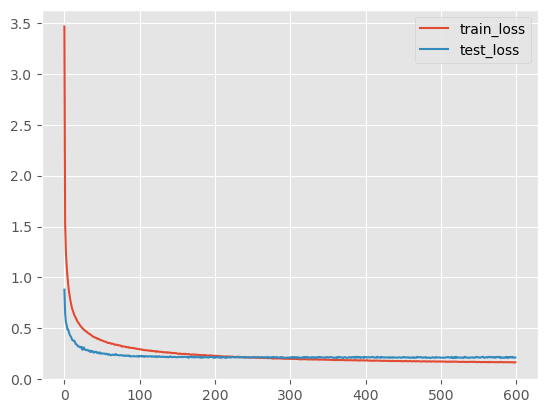

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
train_loss = pd.DataFrame(results['train_loss'], columns = ['train_loss'])
test_loss = pd.DataFrame(results['test_loss'], columns = ['test_loss'])
loss = pd.concat([train_loss,test_loss],axis =1)
loss.plot()

<Axes: >

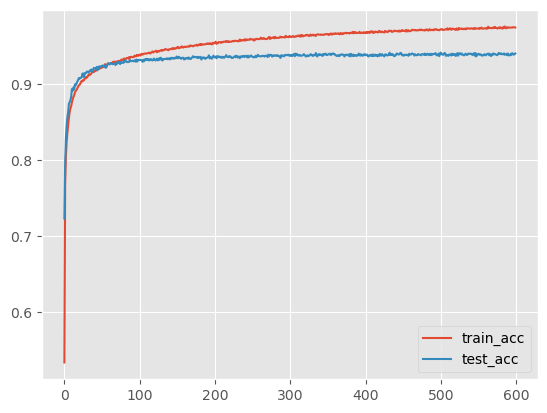

In [14]:
train_acc = pd.DataFrame(results['train_acc'], columns = ['train_acc'])
test_acc = pd.DataFrame(results['test_acc'], columns = ['test_acc'])
acc = pd.concat([train_acc,test_acc],axis =1)
acc.plot()

# 5. Testing accuracy for unpruned student_model

In [15]:
for i in range(3,13):
    net = StudentModel()
    checkpoint = torch.load(f"unpruned_student_model/model_{50*i}.pth")
    net.load_state_dict(checkpoint)
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    pred_arr = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_arr.append(predicted.item())
    accuracy = 100 * correct / total
    print(f"Epoch {50*i}")
    print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")

Epoch 150
Accuracy of the network on the 10000 test images: 93.58 %
Epoch 200
Accuracy of the network on the 10000 test images: 93.49 %
Epoch 250
Accuracy of the network on the 10000 test images: 93.58 %
Epoch 300
Accuracy of the network on the 10000 test images: 93.67 %
Epoch 350
Accuracy of the network on the 10000 test images: 93.77 %
Epoch 400
Accuracy of the network on the 10000 test images: 93.74 %
Epoch 450
Accuracy of the network on the 10000 test images: 93.71 %
Epoch 500
Accuracy of the network on the 10000 test images: 93.98 %
Epoch 550
Accuracy of the network on the 10000 test images: 93.88 %
Epoch 600
Accuracy of the network on the 10000 test images: 93.98 %


# 6. Pruning student_model

In [16]:
pruned_net = StudentModel()
checkpoint = torch.load("unpruned_student_model/model_500.pth")
pruned_net.load_state_dict(checkpoint)

<All keys matched successfully>

In [17]:
param_to_prune=[]
for i,(name, module) in enumerate(pruned_net.named_modules()):
    if i>=2:
        if isinstance(module,depthwise_separable_conv):
            param_to_prune.append((module.depthwise,'weight'))
            param_to_prune.append((module.pointwise,'weight'))
        elif isinstance(module,nn.Conv2d)|isinstance(module,nn.Linear)|isinstance(module,nn.BatchNorm2d):
            param_to_prune.append((module,'weight'))

In [18]:
prune.global_unstructured(
    param_to_prune,
     pruning_method=prune.L1Unstructured,
     amount=0.82
)

In [19]:
import torchinfo as summary
summary.summary(pruned_net)

Layer (type:depth-idx)                        Param #
StudentModel                                  --
├─Sequential: 1-1                             --
│    └─depthwise_separable_conv: 2-1          --
│    │    └─Conv2d: 3-1                       24
│    │    └─Conv2d: 3-2                       220
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─depthwise_separable_conv: 2-4          --
│    │    └─Conv2d: 3-3                       462
│    │    └─Conv2d: 3-4                       1,293
│    └─BatchNorm2d: 2-5                       128
│    └─ReLU: 2-6                              --
│    └─MaxPool2d: 2-7                         --
│    └─Dropout: 2-8                           --
│    └─depthwise_separable_conv: 2-9          --
│    │    └─Conv2d: 3-5                       439
│    │    └─Conv2d: 3-6                       2,457
│    └─BatchNorm2d: 2-10                      256
│    └─ReLU: 2-11                             --
│  

# 7. Testing accuracy before retraining

In [20]:
pruned_net.to(device)
pruned_net.eval()
correct = 0
total = 0
pred_arr = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = pruned_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_arr.append(predicted.item())
accuracy = 100 * correct / total
print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")

Accuracy of the network on the 10000 test images: 10.04 %


# 8. Retrain pruned student_model

In [21]:
def train(epochs, student_model, teacher_model,
          train_dataloader, test_dataloader, opt, 
          train_loss_function,test_loss_function,
          device, patience,model_name,scheduler):
    last_loss = float("inf")
    cur = 0
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(student_model=student_model,
                                           teacher_model = teacher_model,
                                          train_dataloader=train_dataloader,
                                          train_loss_function=train_loss_function,
                                          opt=opt,
                                          device=device)
        test_loss, test_acc = test_step(student_model=student_model,
                                          test_dataloader=test_dataloader,
                                          test_loss_function=test_loss_function,
                                          device=device)
        if scheduler:
            scheduler.step()
        if test_loss > last_loss:
            cur += 1
            print('trigger times:', cur)
            if cur >= patience:
                print("early stop !")
                return results
        else:
            cur = 0
        last_loss = test_loss
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if (epoch+1)%10 == 0:
            MODEL_PATH = Path(model_name)
            MODEL_PATH.mkdir(parents=True, 
                             exist_ok=True
            )

            # Create model save path
            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            # Save the model state dict
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=student_model.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=MODEL_SAVE_PATH)
    return results

In [22]:
from torch.optim.lr_scheduler import StepLR
LR =1e-4
EPOCH =600
opt = torch.optim.AdamW(pruned_net.parameters(),lr = LR )
pruned_net.to(device)
results = train(EPOCH,
      pruned_net,teacher_model,
      trainloader,testloader,
      train_loss_function = studentLossFn,
      test_loss_function = nn.CrossEntropyLoss(),
      opt = opt,
      device=device,
      patience = 10,
      model_name = "pruned_student_model",
      scheduler = None)

  0%|                        | 1/600 [00:21<3:37:32, 21.79s/it]

Epoch: 1 | train_loss: 1.4765 | train_acc: 0.8214 | test_loss: 0.3633 | test_acc: 0.8925


  0%|                        | 2/600 [00:43<3:37:16, 21.80s/it]

Epoch: 2 | train_loss: 0.6620 | train_acc: 0.8871 | test_loss: 0.3163 | test_acc: 0.9052


  0%|                        | 3/600 [01:05<3:36:34, 21.77s/it]

Epoch: 3 | train_loss: 0.5744 | train_acc: 0.8986 | test_loss: 0.2966 | test_acc: 0.9123


  1%|▏                       | 4/600 [01:27<3:36:17, 21.77s/it]

Epoch: 4 | train_loss: 0.5267 | train_acc: 0.9039 | test_loss: 0.2818 | test_acc: 0.9157


  1%|▏                       | 5/600 [01:48<3:35:49, 21.76s/it]

Epoch: 5 | train_loss: 0.4984 | train_acc: 0.9080 | test_loss: 0.2768 | test_acc: 0.9168


  1%|▏                       | 6/600 [02:10<3:35:23, 21.76s/it]

Epoch: 6 | train_loss: 0.4771 | train_acc: 0.9104 | test_loss: 0.2707 | test_acc: 0.9182


  1%|▎                       | 7/600 [02:32<3:35:18, 21.79s/it]

Epoch: 7 | train_loss: 0.4580 | train_acc: 0.9122 | test_loss: 0.2678 | test_acc: 0.9206


  1%|▎                       | 8/600 [02:54<3:35:01, 21.79s/it]

Epoch: 8 | train_loss: 0.4449 | train_acc: 0.9147 | test_loss: 0.2623 | test_acc: 0.9203


  2%|▎                       | 9/600 [03:16<3:34:39, 21.79s/it]

Epoch: 9 | train_loss: 0.4323 | train_acc: 0.9164 | test_loss: 0.2569 | test_acc: 0.9207


  2%|▍                      | 10/600 [03:37<3:34:25, 21.81s/it]

Epoch: 10 | train_loss: 0.4235 | train_acc: 0.9175 | test_loss: 0.2563 | test_acc: 0.9222
Saving model to: pruned_student_model/model_10.pth


  2%|▍                      | 11/600 [03:59<3:33:48, 21.78s/it]

Epoch: 11 | train_loss: 0.4137 | train_acc: 0.9204 | test_loss: 0.2557 | test_acc: 0.9232


  2%|▍                      | 12/600 [04:21<3:33:34, 21.79s/it]

Epoch: 12 | train_loss: 0.4103 | train_acc: 0.9207 | test_loss: 0.2460 | test_acc: 0.9237


  2%|▍                      | 13/600 [04:43<3:33:10, 21.79s/it]

trigger times: 1
Epoch: 13 | train_loss: 0.4002 | train_acc: 0.9220 | test_loss: 0.2496 | test_acc: 0.9241


  2%|▌                      | 14/600 [05:05<3:32:56, 21.80s/it]

Epoch: 14 | train_loss: 0.3945 | train_acc: 0.9219 | test_loss: 0.2469 | test_acc: 0.9245


  2%|▌                      | 15/600 [05:26<3:32:40, 21.81s/it]

Epoch: 15 | train_loss: 0.3864 | train_acc: 0.9240 | test_loss: 0.2467 | test_acc: 0.9258


  3%|▌                      | 16/600 [05:48<3:32:20, 21.82s/it]

Epoch: 16 | train_loss: 0.3834 | train_acc: 0.9250 | test_loss: 0.2419 | test_acc: 0.9249


  3%|▋                      | 17/600 [06:10<3:32:02, 21.82s/it]

trigger times: 1
Epoch: 17 | train_loss: 0.3800 | train_acc: 0.9245 | test_loss: 0.2462 | test_acc: 0.9250


  3%|▋                      | 18/600 [06:32<3:31:22, 21.79s/it]

Epoch: 18 | train_loss: 0.3718 | train_acc: 0.9246 | test_loss: 0.2423 | test_acc: 0.9249


  3%|▋                      | 19/600 [06:54<3:31:18, 21.82s/it]

Epoch: 19 | train_loss: 0.3695 | train_acc: 0.9258 | test_loss: 0.2365 | test_acc: 0.9271


  3%|▊                      | 20/600 [07:15<3:31:00, 21.83s/it]

trigger times: 1
Epoch: 20 | train_loss: 0.3631 | train_acc: 0.9268 | test_loss: 0.2375 | test_acc: 0.9270
Saving model to: pruned_student_model/model_20.pth


  4%|▊                      | 21/600 [07:37<3:30:23, 21.80s/it]

trigger times: 2
Epoch: 21 | train_loss: 0.3633 | train_acc: 0.9267 | test_loss: 0.2412 | test_acc: 0.9261


  4%|▊                      | 22/600 [07:59<3:30:05, 21.81s/it]

Epoch: 22 | train_loss: 0.3610 | train_acc: 0.9281 | test_loss: 0.2354 | test_acc: 0.9276


  4%|▉                      | 23/600 [08:21<3:29:49, 21.82s/it]

trigger times: 1
Epoch: 23 | train_loss: 0.3554 | train_acc: 0.9291 | test_loss: 0.2355 | test_acc: 0.9286


  4%|▉                      | 24/600 [08:43<3:29:56, 21.87s/it]

trigger times: 2
Epoch: 24 | train_loss: 0.3577 | train_acc: 0.9283 | test_loss: 0.2356 | test_acc: 0.9277


  4%|▉                      | 25/600 [09:05<3:29:30, 21.86s/it]

Epoch: 25 | train_loss: 0.3490 | train_acc: 0.9299 | test_loss: 0.2325 | test_acc: 0.9284


  4%|▉                      | 26/600 [09:27<3:29:02, 21.85s/it]

trigger times: 1
Epoch: 26 | train_loss: 0.3516 | train_acc: 0.9289 | test_loss: 0.2336 | test_acc: 0.9291


  4%|█                      | 27/600 [09:48<3:28:35, 21.84s/it]

trigger times: 2
Epoch: 27 | train_loss: 0.3458 | train_acc: 0.9286 | test_loss: 0.2349 | test_acc: 0.9288


  5%|█                      | 28/600 [10:10<3:28:15, 21.84s/it]

Epoch: 28 | train_loss: 0.3451 | train_acc: 0.9305 | test_loss: 0.2338 | test_acc: 0.9303


  5%|█                      | 29/600 [10:32<3:27:53, 21.85s/it]

trigger times: 1
Epoch: 29 | train_loss: 0.3429 | train_acc: 0.9309 | test_loss: 0.2374 | test_acc: 0.9286


  5%|█▏                     | 30/600 [10:54<3:27:21, 21.83s/it]

Epoch: 30 | train_loss: 0.3391 | train_acc: 0.9319 | test_loss: 0.2317 | test_acc: 0.9294
Saving model to: pruned_student_model/model_30.pth


  5%|█▏                     | 31/600 [11:16<3:26:48, 21.81s/it]

trigger times: 1
Epoch: 31 | train_loss: 0.3376 | train_acc: 0.9302 | test_loss: 0.2322 | test_acc: 0.9283


  5%|█▏                     | 32/600 [11:37<3:26:09, 21.78s/it]

Epoch: 32 | train_loss: 0.3349 | train_acc: 0.9315 | test_loss: 0.2314 | test_acc: 0.9288


  6%|█▎                     | 33/600 [11:59<3:25:41, 21.77s/it]

trigger times: 1
Epoch: 33 | train_loss: 0.3360 | train_acc: 0.9326 | test_loss: 0.2321 | test_acc: 0.9294


  6%|█▎                     | 34/600 [12:21<3:25:27, 21.78s/it]

Epoch: 34 | train_loss: 0.3293 | train_acc: 0.9331 | test_loss: 0.2282 | test_acc: 0.9300


  6%|█▎                     | 35/600 [12:43<3:25:04, 21.78s/it]

trigger times: 1
Epoch: 35 | train_loss: 0.3310 | train_acc: 0.9323 | test_loss: 0.2286 | test_acc: 0.9304


  6%|█▍                     | 36/600 [13:04<3:24:52, 21.80s/it]

Epoch: 36 | train_loss: 0.3282 | train_acc: 0.9323 | test_loss: 0.2270 | test_acc: 0.9306


  6%|█▍                     | 37/600 [13:26<3:24:35, 21.80s/it]

trigger times: 1
Epoch: 37 | train_loss: 0.3287 | train_acc: 0.9331 | test_loss: 0.2310 | test_acc: 0.9293


  6%|█▍                     | 38/600 [13:48<3:24:00, 21.78s/it]

Epoch: 38 | train_loss: 0.3271 | train_acc: 0.9344 | test_loss: 0.2283 | test_acc: 0.9299


  6%|█▍                     | 39/600 [14:10<3:23:41, 21.79s/it]

trigger times: 1
Epoch: 39 | train_loss: 0.3249 | train_acc: 0.9344 | test_loss: 0.2295 | test_acc: 0.9302


  7%|█▌                     | 40/600 [14:32<3:23:17, 21.78s/it]

trigger times: 2
Epoch: 40 | train_loss: 0.3226 | train_acc: 0.9339 | test_loss: 0.2300 | test_acc: 0.9293
Saving model to: pruned_student_model/model_40.pth


  7%|█▌                     | 41/600 [14:53<3:23:04, 21.80s/it]

trigger times: 3
Epoch: 41 | train_loss: 0.3214 | train_acc: 0.9353 | test_loss: 0.2300 | test_acc: 0.9298


  7%|█▌                     | 42/600 [15:15<3:22:34, 21.78s/it]

Epoch: 42 | train_loss: 0.3213 | train_acc: 0.9338 | test_loss: 0.2246 | test_acc: 0.9323


  7%|█▋                     | 43/600 [15:37<3:22:08, 21.77s/it]

trigger times: 1
Epoch: 43 | train_loss: 0.3236 | train_acc: 0.9355 | test_loss: 0.2282 | test_acc: 0.9308


  7%|█▋                     | 44/600 [15:59<3:22:01, 21.80s/it]

Epoch: 44 | train_loss: 0.3172 | train_acc: 0.9352 | test_loss: 0.2267 | test_acc: 0.9308


  8%|█▋                     | 45/600 [16:21<3:21:38, 21.80s/it]

trigger times: 1
Epoch: 45 | train_loss: 0.3169 | train_acc: 0.9357 | test_loss: 0.2273 | test_acc: 0.9310


  8%|█▊                     | 46/600 [16:42<3:20:58, 21.77s/it]

Epoch: 46 | train_loss: 0.3182 | train_acc: 0.9351 | test_loss: 0.2260 | test_acc: 0.9304


  8%|█▊                     | 47/600 [17:04<3:20:42, 21.78s/it]

trigger times: 1
Epoch: 47 | train_loss: 0.3142 | train_acc: 0.9361 | test_loss: 0.2274 | test_acc: 0.9308


  8%|█▊                     | 48/600 [17:26<3:20:39, 21.81s/it]

trigger times: 2
Epoch: 48 | train_loss: 0.3129 | train_acc: 0.9367 | test_loss: 0.2291 | test_acc: 0.9306


  8%|█▉                     | 49/600 [17:48<3:20:16, 21.81s/it]

Epoch: 49 | train_loss: 0.3147 | train_acc: 0.9358 | test_loss: 0.2273 | test_acc: 0.9312


  8%|█▉                     | 50/600 [18:10<3:20:13, 21.84s/it]

trigger times: 1
Epoch: 50 | train_loss: 0.3123 | train_acc: 0.9364 | test_loss: 0.2295 | test_acc: 0.9303
Saving model to: pruned_student_model/model_50.pth


  8%|█▉                     | 51/600 [18:32<3:19:48, 21.84s/it]

trigger times: 2
Epoch: 51 | train_loss: 0.3090 | train_acc: 0.9373 | test_loss: 0.2298 | test_acc: 0.9299


  9%|█▉                     | 52/600 [18:53<3:19:21, 21.83s/it]

trigger times: 3
Epoch: 52 | train_loss: 0.3137 | train_acc: 0.9353 | test_loss: 0.2337 | test_acc: 0.9294


  9%|██                     | 53/600 [19:15<3:18:52, 21.82s/it]

Epoch: 53 | train_loss: 0.3087 | train_acc: 0.9370 | test_loss: 0.2275 | test_acc: 0.9317


  9%|██                     | 54/600 [19:37<3:18:31, 21.82s/it]

trigger times: 1
Epoch: 54 | train_loss: 0.3074 | train_acc: 0.9376 | test_loss: 0.2303 | test_acc: 0.9301


  9%|██                     | 55/600 [19:59<3:18:19, 21.83s/it]

trigger times: 2
Epoch: 55 | train_loss: 0.3094 | train_acc: 0.9374 | test_loss: 0.2307 | test_acc: 0.9312


  9%|██▏                    | 56/600 [20:21<3:17:45, 21.81s/it]

Epoch: 56 | train_loss: 0.3103 | train_acc: 0.9367 | test_loss: 0.2292 | test_acc: 0.9306


 10%|██▏                    | 57/600 [20:42<3:17:31, 21.83s/it]

Epoch: 57 | train_loss: 0.3066 | train_acc: 0.9377 | test_loss: 0.2276 | test_acc: 0.9303


 10%|██▏                    | 58/600 [21:04<3:16:50, 21.79s/it]

Epoch: 58 | train_loss: 0.3054 | train_acc: 0.9386 | test_loss: 0.2233 | test_acc: 0.9321


 10%|██▎                    | 59/600 [21:26<3:16:32, 21.80s/it]

trigger times: 1
Epoch: 59 | train_loss: 0.3058 | train_acc: 0.9374 | test_loss: 0.2247 | test_acc: 0.9325


 10%|██▎                    | 60/600 [21:48<3:16:02, 21.78s/it]

trigger times: 2
Epoch: 60 | train_loss: 0.3033 | train_acc: 0.9374 | test_loss: 0.2262 | test_acc: 0.9307
Saving model to: pruned_student_model/model_60.pth


 10%|██▎                    | 61/600 [22:10<3:15:47, 21.79s/it]

Epoch: 61 | train_loss: 0.3041 | train_acc: 0.9369 | test_loss: 0.2249 | test_acc: 0.9321


 10%|██▍                    | 62/600 [22:31<3:15:39, 21.82s/it]

trigger times: 1
Epoch: 62 | train_loss: 0.3061 | train_acc: 0.9379 | test_loss: 0.2288 | test_acc: 0.9313


 10%|██▍                    | 63/600 [22:53<3:15:17, 21.82s/it]

Epoch: 63 | train_loss: 0.3041 | train_acc: 0.9377 | test_loss: 0.2246 | test_acc: 0.9313


 11%|██▍                    | 64/600 [23:15<3:14:34, 21.78s/it]

trigger times: 1
Epoch: 64 | train_loss: 0.3007 | train_acc: 0.9381 | test_loss: 0.2272 | test_acc: 0.9310


 11%|██▍                    | 65/600 [23:37<3:14:31, 21.82s/it]

Epoch: 65 | train_loss: 0.3002 | train_acc: 0.9397 | test_loss: 0.2244 | test_acc: 0.9314


 11%|██▌                    | 66/600 [23:59<3:13:53, 21.79s/it]

trigger times: 1
Epoch: 66 | train_loss: 0.3010 | train_acc: 0.9378 | test_loss: 0.2259 | test_acc: 0.9310


 11%|██▌                    | 67/600 [24:20<3:13:24, 21.77s/it]

Epoch: 67 | train_loss: 0.3006 | train_acc: 0.9395 | test_loss: 0.2233 | test_acc: 0.9313


 11%|██▌                    | 68/600 [24:42<3:12:56, 21.76s/it]

trigger times: 1
Epoch: 68 | train_loss: 0.3032 | train_acc: 0.9378 | test_loss: 0.2282 | test_acc: 0.9306


 12%|██▋                    | 69/600 [25:04<3:12:34, 21.76s/it]

Epoch: 69 | train_loss: 0.2984 | train_acc: 0.9386 | test_loss: 0.2259 | test_acc: 0.9327


 12%|██▋                    | 70/600 [25:26<3:12:21, 21.78s/it]

trigger times: 1
Epoch: 70 | train_loss: 0.3002 | train_acc: 0.9384 | test_loss: 0.2264 | test_acc: 0.9313
Saving model to: pruned_student_model/model_70.pth


 12%|██▋                    | 71/600 [25:47<3:11:56, 21.77s/it]

trigger times: 2
Epoch: 71 | train_loss: 0.2983 | train_acc: 0.9388 | test_loss: 0.2275 | test_acc: 0.9303


 12%|██▊                    | 72/600 [26:09<3:11:45, 21.79s/it]

Epoch: 72 | train_loss: 0.2984 | train_acc: 0.9392 | test_loss: 0.2232 | test_acc: 0.9312


 12%|██▊                    | 73/600 [26:31<3:11:14, 21.77s/it]

Epoch: 73 | train_loss: 0.2978 | train_acc: 0.9375 | test_loss: 0.2229 | test_acc: 0.9318


 12%|██▊                    | 74/600 [26:53<3:10:57, 21.78s/it]

Epoch: 74 | train_loss: 0.2952 | train_acc: 0.9397 | test_loss: 0.2227 | test_acc: 0.9317


 12%|██▉                    | 75/600 [27:15<3:10:41, 21.79s/it]

trigger times: 1
Epoch: 75 | train_loss: 0.2922 | train_acc: 0.9398 | test_loss: 0.2232 | test_acc: 0.9322


 13%|██▉                    | 76/600 [27:36<3:10:16, 21.79s/it]

Epoch: 76 | train_loss: 0.2969 | train_acc: 0.9391 | test_loss: 0.2221 | test_acc: 0.9315


 13%|██▉                    | 77/600 [27:58<3:10:03, 21.80s/it]

Epoch: 77 | train_loss: 0.2909 | train_acc: 0.9408 | test_loss: 0.2217 | test_acc: 0.9322


 13%|██▉                    | 78/600 [28:20<3:09:59, 21.84s/it]

trigger times: 1
Epoch: 78 | train_loss: 0.2953 | train_acc: 0.9401 | test_loss: 0.2226 | test_acc: 0.9319


 13%|███                    | 79/600 [28:42<3:09:34, 21.83s/it]

Epoch: 79 | train_loss: 0.2949 | train_acc: 0.9387 | test_loss: 0.2212 | test_acc: 0.9311


 13%|███                    | 80/600 [29:04<3:09:05, 21.82s/it]

trigger times: 1
Epoch: 80 | train_loss: 0.2915 | train_acc: 0.9394 | test_loss: 0.2242 | test_acc: 0.9317
Saving model to: pruned_student_model/model_80.pth


 14%|███                    | 81/600 [29:25<3:08:35, 21.80s/it]

trigger times: 2
Epoch: 81 | train_loss: 0.2926 | train_acc: 0.9393 | test_loss: 0.2247 | test_acc: 0.9308


 14%|███▏                   | 82/600 [29:47<3:08:32, 21.84s/it]

Epoch: 82 | train_loss: 0.2934 | train_acc: 0.9405 | test_loss: 0.2220 | test_acc: 0.9317


 14%|███▏                   | 83/600 [30:09<3:07:55, 21.81s/it]

Epoch: 83 | train_loss: 0.2943 | train_acc: 0.9396 | test_loss: 0.2205 | test_acc: 0.9306


 14%|███▏                   | 84/600 [30:31<3:07:22, 21.79s/it]

trigger times: 1
Epoch: 84 | train_loss: 0.2913 | train_acc: 0.9410 | test_loss: 0.2231 | test_acc: 0.9305


 14%|███▎                   | 85/600 [30:53<3:07:01, 21.79s/it]

trigger times: 2
Epoch: 85 | train_loss: 0.2928 | train_acc: 0.9408 | test_loss: 0.2240 | test_acc: 0.9315


 14%|███▎                   | 86/600 [31:14<3:06:38, 21.79s/it]

trigger times: 3
Epoch: 86 | train_loss: 0.2933 | train_acc: 0.9407 | test_loss: 0.2248 | test_acc: 0.9319


 14%|███▎                   | 87/600 [31:36<3:06:15, 21.78s/it]

Epoch: 87 | train_loss: 0.2913 | train_acc: 0.9404 | test_loss: 0.2235 | test_acc: 0.9311


 15%|███▎                   | 88/600 [31:58<3:05:47, 21.77s/it]

trigger times: 1
Epoch: 88 | train_loss: 0.2892 | train_acc: 0.9406 | test_loss: 0.2237 | test_acc: 0.9313


 15%|███▍                   | 89/600 [32:20<3:05:33, 21.79s/it]

trigger times: 2
Epoch: 89 | train_loss: 0.2882 | train_acc: 0.9417 | test_loss: 0.2257 | test_acc: 0.9308


 15%|███▍                   | 90/600 [32:42<3:05:14, 21.79s/it]

Epoch: 90 | train_loss: 0.2896 | train_acc: 0.9408 | test_loss: 0.2227 | test_acc: 0.9321
Saving model to: pruned_student_model/model_90.pth


 15%|███▍                   | 91/600 [33:03<3:05:14, 21.84s/it]

Epoch: 91 | train_loss: 0.2875 | train_acc: 0.9416 | test_loss: 0.2206 | test_acc: 0.9319


 15%|███▌                   | 92/600 [33:25<3:04:39, 21.81s/it]

trigger times: 1
Epoch: 92 | train_loss: 0.2890 | train_acc: 0.9413 | test_loss: 0.2224 | test_acc: 0.9317


 16%|███▌                   | 93/600 [33:47<3:04:27, 21.83s/it]

trigger times: 2
Epoch: 93 | train_loss: 0.2869 | train_acc: 0.9415 | test_loss: 0.2256 | test_acc: 0.9316


 16%|███▌                   | 94/600 [34:09<3:03:50, 21.80s/it]

Epoch: 94 | train_loss: 0.2849 | train_acc: 0.9421 | test_loss: 0.2241 | test_acc: 0.9324


 16%|███▋                   | 95/600 [34:31<3:03:35, 21.81s/it]

Epoch: 95 | train_loss: 0.2888 | train_acc: 0.9412 | test_loss: 0.2209 | test_acc: 0.9319


 16%|███▋                   | 96/600 [34:52<3:03:02, 21.79s/it]

trigger times: 1
Epoch: 96 | train_loss: 0.2863 | train_acc: 0.9417 | test_loss: 0.2221 | test_acc: 0.9308


 16%|███▋                   | 97/600 [35:14<3:02:32, 21.77s/it]

trigger times: 2
Epoch: 97 | train_loss: 0.2876 | train_acc: 0.9412 | test_loss: 0.2230 | test_acc: 0.9323


 16%|███▊                   | 98/600 [35:36<3:02:18, 21.79s/it]

trigger times: 3
Epoch: 98 | train_loss: 0.2853 | train_acc: 0.9422 | test_loss: 0.2235 | test_acc: 0.9323


 16%|███▊                   | 99/600 [35:58<3:02:04, 21.81s/it]

Epoch: 99 | train_loss: 0.2876 | train_acc: 0.9403 | test_loss: 0.2199 | test_acc: 0.9319


 17%|███▋                  | 100/600 [36:20<3:01:33, 21.79s/it]

trigger times: 1
Epoch: 100 | train_loss: 0.2847 | train_acc: 0.9416 | test_loss: 0.2203 | test_acc: 0.9321
Saving model to: pruned_student_model/model_100.pth


 17%|███▋                  | 101/600 [36:41<3:01:22, 21.81s/it]

trigger times: 2
Epoch: 101 | train_loss: 0.2864 | train_acc: 0.9407 | test_loss: 0.2230 | test_acc: 0.9310


 17%|███▋                  | 102/600 [37:03<3:00:59, 21.81s/it]

trigger times: 3
Epoch: 102 | train_loss: 0.2833 | train_acc: 0.9415 | test_loss: 0.2245 | test_acc: 0.9318


 17%|███▊                  | 103/600 [37:25<3:00:33, 21.80s/it]

trigger times: 4
Epoch: 103 | train_loss: 0.2824 | train_acc: 0.9422 | test_loss: 0.2252 | test_acc: 0.9321


 17%|███▊                  | 104/600 [37:47<3:00:04, 21.78s/it]

trigger times: 5
Epoch: 104 | train_loss: 0.2796 | train_acc: 0.9438 | test_loss: 0.2262 | test_acc: 0.9305


 18%|███▊                  | 105/600 [38:09<2:59:47, 21.79s/it]

Epoch: 105 | train_loss: 0.2858 | train_acc: 0.9419 | test_loss: 0.2253 | test_acc: 0.9319


 18%|███▉                  | 106/600 [38:30<2:59:36, 21.81s/it]

Epoch: 106 | train_loss: 0.2779 | train_acc: 0.9431 | test_loss: 0.2212 | test_acc: 0.9327


 18%|███▉                  | 107/600 [38:52<2:59:06, 21.80s/it]

trigger times: 1
Epoch: 107 | train_loss: 0.2830 | train_acc: 0.9421 | test_loss: 0.2232 | test_acc: 0.9309


 18%|███▉                  | 108/600 [39:14<2:58:44, 21.80s/it]

trigger times: 2
Epoch: 108 | train_loss: 0.2805 | train_acc: 0.9429 | test_loss: 0.2242 | test_acc: 0.9307


 18%|███▉                  | 109/600 [39:36<2:58:22, 21.80s/it]

Epoch: 109 | train_loss: 0.2855 | train_acc: 0.9412 | test_loss: 0.2209 | test_acc: 0.9319


 18%|████                  | 110/600 [39:58<2:57:49, 21.77s/it]

trigger times: 1
Epoch: 110 | train_loss: 0.2811 | train_acc: 0.9420 | test_loss: 0.2212 | test_acc: 0.9322
Saving model to: pruned_student_model/model_110.pth


 18%|████                  | 111/600 [40:19<2:57:32, 21.78s/it]

trigger times: 2
Epoch: 111 | train_loss: 0.2848 | train_acc: 0.9430 | test_loss: 0.2214 | test_acc: 0.9340


 19%|████                  | 112/600 [40:41<2:57:26, 21.82s/it]

trigger times: 3
Epoch: 112 | train_loss: 0.2794 | train_acc: 0.9442 | test_loss: 0.2242 | test_acc: 0.9324


 19%|████▏                 | 113/600 [41:03<2:57:06, 21.82s/it]

Epoch: 113 | train_loss: 0.2820 | train_acc: 0.9421 | test_loss: 0.2224 | test_acc: 0.9316


 19%|████▏                 | 114/600 [41:25<2:56:43, 21.82s/it]

trigger times: 1
Epoch: 114 | train_loss: 0.2807 | train_acc: 0.9424 | test_loss: 0.2240 | test_acc: 0.9318


 19%|████▏                 | 115/600 [41:47<2:56:10, 21.79s/it]

Epoch: 115 | train_loss: 0.2815 | train_acc: 0.9431 | test_loss: 0.2202 | test_acc: 0.9316


 19%|████▎                 | 116/600 [42:08<2:55:43, 21.78s/it]

trigger times: 1
Epoch: 116 | train_loss: 0.2817 | train_acc: 0.9431 | test_loss: 0.2230 | test_acc: 0.9328


 20%|████▎                 | 117/600 [42:30<2:55:15, 21.77s/it]

trigger times: 2
Epoch: 117 | train_loss: 0.2816 | train_acc: 0.9434 | test_loss: 0.2234 | test_acc: 0.9314


 20%|████▎                 | 118/600 [42:52<2:55:09, 21.80s/it]

Epoch: 118 | train_loss: 0.2790 | train_acc: 0.9429 | test_loss: 0.2207 | test_acc: 0.9327


 20%|████▎                 | 119/600 [43:14<2:54:46, 21.80s/it]

trigger times: 1
Epoch: 119 | train_loss: 0.2784 | train_acc: 0.9436 | test_loss: 0.2222 | test_acc: 0.9313


 20%|████▍                 | 120/600 [43:36<2:54:19, 21.79s/it]

trigger times: 2
Epoch: 120 | train_loss: 0.2801 | train_acc: 0.9436 | test_loss: 0.2243 | test_acc: 0.9321
Saving model to: pruned_student_model/model_120.pth


 20%|████▍                 | 121/600 [43:57<2:54:06, 21.81s/it]

Epoch: 121 | train_loss: 0.2766 | train_acc: 0.9432 | test_loss: 0.2199 | test_acc: 0.9339


 20%|████▍                 | 122/600 [44:19<2:53:48, 21.82s/it]

trigger times: 1
Epoch: 122 | train_loss: 0.2794 | train_acc: 0.9428 | test_loss: 0.2212 | test_acc: 0.9315


 20%|████▌                 | 123/600 [44:41<2:53:29, 21.82s/it]

Epoch: 123 | train_loss: 0.2764 | train_acc: 0.9429 | test_loss: 0.2184 | test_acc: 0.9323


 21%|████▌                 | 124/600 [45:03<2:52:58, 21.80s/it]

trigger times: 1
Epoch: 124 | train_loss: 0.2795 | train_acc: 0.9423 | test_loss: 0.2199 | test_acc: 0.9329


 21%|████▌                 | 125/600 [45:25<2:52:36, 21.80s/it]

Epoch: 125 | train_loss: 0.2782 | train_acc: 0.9428 | test_loss: 0.2193 | test_acc: 0.9340


 21%|████▌                 | 126/600 [45:46<2:52:07, 21.79s/it]

trigger times: 1
Epoch: 126 | train_loss: 0.2786 | train_acc: 0.9434 | test_loss: 0.2208 | test_acc: 0.9334


 21%|████▋                 | 127/600 [46:08<2:51:42, 21.78s/it]

Epoch: 127 | train_loss: 0.2769 | train_acc: 0.9445 | test_loss: 0.2188 | test_acc: 0.9340


 21%|████▋                 | 128/600 [46:30<2:51:32, 21.81s/it]

Epoch: 128 | train_loss: 0.2725 | train_acc: 0.9433 | test_loss: 0.2187 | test_acc: 0.9328


 22%|████▋                 | 129/600 [46:52<2:51:10, 21.81s/it]

trigger times: 1
Epoch: 129 | train_loss: 0.2774 | train_acc: 0.9432 | test_loss: 0.2192 | test_acc: 0.9345


 22%|████▊                 | 130/600 [47:14<2:51:01, 21.83s/it]

Epoch: 130 | train_loss: 0.2797 | train_acc: 0.9434 | test_loss: 0.2171 | test_acc: 0.9332
Saving model to: pruned_student_model/model_130.pth


 22%|████▊                 | 131/600 [47:36<2:50:42, 21.84s/it]

trigger times: 1
Epoch: 131 | train_loss: 0.2759 | train_acc: 0.9440 | test_loss: 0.2241 | test_acc: 0.9316


 22%|████▊                 | 132/600 [47:57<2:50:14, 21.83s/it]

Epoch: 132 | train_loss: 0.2753 | train_acc: 0.9445 | test_loss: 0.2192 | test_acc: 0.9325


 22%|████▉                 | 133/600 [48:19<2:49:39, 21.80s/it]

Epoch: 133 | train_loss: 0.2756 | train_acc: 0.9438 | test_loss: 0.2186 | test_acc: 0.9335


 22%|████▉                 | 134/600 [48:41<2:49:16, 21.80s/it]

trigger times: 1
Epoch: 134 | train_loss: 0.2762 | train_acc: 0.9435 | test_loss: 0.2206 | test_acc: 0.9336


 22%|████▉                 | 135/600 [49:03<2:49:08, 21.82s/it]

trigger times: 2
Epoch: 135 | train_loss: 0.2738 | train_acc: 0.9445 | test_loss: 0.2234 | test_acc: 0.9337


 23%|████▉                 | 136/600 [49:25<2:48:43, 21.82s/it]

Epoch: 136 | train_loss: 0.2734 | train_acc: 0.9443 | test_loss: 0.2201 | test_acc: 0.9334


 23%|█████                 | 137/600 [49:46<2:48:28, 21.83s/it]

trigger times: 1
Epoch: 137 | train_loss: 0.2764 | train_acc: 0.9440 | test_loss: 0.2235 | test_acc: 0.9332


 23%|█████                 | 138/600 [50:08<2:48:02, 21.82s/it]

Epoch: 138 | train_loss: 0.2745 | train_acc: 0.9451 | test_loss: 0.2172 | test_acc: 0.9355


 23%|█████                 | 139/600 [50:30<2:47:23, 21.79s/it]

trigger times: 1
Epoch: 139 | train_loss: 0.2748 | train_acc: 0.9449 | test_loss: 0.2229 | test_acc: 0.9328


 23%|█████▏                | 140/600 [50:52<2:47:02, 21.79s/it]

Epoch: 140 | train_loss: 0.2748 | train_acc: 0.9449 | test_loss: 0.2204 | test_acc: 0.9338
Saving model to: pruned_student_model/model_140.pth


 24%|█████▏                | 141/600 [51:14<2:46:41, 21.79s/it]

trigger times: 1
Epoch: 141 | train_loss: 0.2751 | train_acc: 0.9439 | test_loss: 0.2207 | test_acc: 0.9342


 24%|█████▏                | 142/600 [51:35<2:46:23, 21.80s/it]

Epoch: 142 | train_loss: 0.2754 | train_acc: 0.9435 | test_loss: 0.2194 | test_acc: 0.9333


 24%|█████▏                | 143/600 [51:57<2:46:11, 21.82s/it]

trigger times: 1
Epoch: 143 | train_loss: 0.2746 | train_acc: 0.9441 | test_loss: 0.2225 | test_acc: 0.9322


 24%|█████▎                | 144/600 [52:19<2:45:42, 21.80s/it]

Epoch: 144 | train_loss: 0.2732 | train_acc: 0.9445 | test_loss: 0.2215 | test_acc: 0.9326


 24%|█████▎                | 145/600 [52:41<2:45:27, 21.82s/it]

Epoch: 145 | train_loss: 0.2737 | train_acc: 0.9432 | test_loss: 0.2167 | test_acc: 0.9330


 24%|█████▎                | 146/600 [53:03<2:45:08, 21.83s/it]

trigger times: 1
Epoch: 146 | train_loss: 0.2689 | train_acc: 0.9454 | test_loss: 0.2232 | test_acc: 0.9319


 24%|█████▍                | 147/600 [53:24<2:44:32, 21.79s/it]

trigger times: 2
Epoch: 147 | train_loss: 0.2717 | train_acc: 0.9447 | test_loss: 0.2239 | test_acc: 0.9334


 25%|█████▍                | 148/600 [53:46<2:44:16, 21.81s/it]

Epoch: 148 | train_loss: 0.2722 | train_acc: 0.9441 | test_loss: 0.2211 | test_acc: 0.9320


 25%|█████▍                | 149/600 [54:08<2:44:00, 21.82s/it]

Epoch: 149 | train_loss: 0.2723 | train_acc: 0.9442 | test_loss: 0.2195 | test_acc: 0.9344


 25%|█████▌                | 150/600 [54:30<2:43:30, 21.80s/it]

Epoch: 150 | train_loss: 0.2730 | train_acc: 0.9453 | test_loss: 0.2187 | test_acc: 0.9339
Saving model to: pruned_student_model/model_150.pth


 25%|█████▌                | 151/600 [54:52<2:42:58, 21.78s/it]

trigger times: 1
Epoch: 151 | train_loss: 0.2730 | train_acc: 0.9457 | test_loss: 0.2202 | test_acc: 0.9336


 25%|█████▌                | 152/600 [55:13<2:42:44, 21.80s/it]

Epoch: 152 | train_loss: 0.2730 | train_acc: 0.9447 | test_loss: 0.2176 | test_acc: 0.9346


 26%|█████▌                | 153/600 [55:35<2:42:22, 21.80s/it]

trigger times: 1
Epoch: 153 | train_loss: 0.2720 | train_acc: 0.9444 | test_loss: 0.2240 | test_acc: 0.9330


 26%|█████▋                | 154/600 [55:57<2:41:55, 21.78s/it]

Epoch: 154 | train_loss: 0.2707 | train_acc: 0.9444 | test_loss: 0.2194 | test_acc: 0.9314


 26%|█████▋                | 155/600 [56:19<2:41:50, 21.82s/it]

trigger times: 1
Epoch: 155 | train_loss: 0.2708 | train_acc: 0.9446 | test_loss: 0.2218 | test_acc: 0.9340


 26%|█████▋                | 156/600 [56:41<2:41:32, 21.83s/it]

Epoch: 156 | train_loss: 0.2723 | train_acc: 0.9449 | test_loss: 0.2202 | test_acc: 0.9332


 26%|█████▊                | 157/600 [57:03<2:41:13, 21.84s/it]

Epoch: 157 | train_loss: 0.2723 | train_acc: 0.9454 | test_loss: 0.2193 | test_acc: 0.9326


 26%|█████▊                | 158/600 [57:24<2:40:52, 21.84s/it]

trigger times: 1
Epoch: 158 | train_loss: 0.2734 | train_acc: 0.9438 | test_loss: 0.2227 | test_acc: 0.9318


 26%|█████▊                | 159/600 [57:46<2:40:28, 21.83s/it]

Epoch: 159 | train_loss: 0.2684 | train_acc: 0.9452 | test_loss: 0.2226 | test_acc: 0.9318


 27%|█████▊                | 160/600 [58:08<2:40:02, 21.82s/it]

Epoch: 160 | train_loss: 0.2699 | train_acc: 0.9451 | test_loss: 0.2201 | test_acc: 0.9333
Saving model to: pruned_student_model/model_160.pth


 27%|█████▉                | 161/600 [58:30<2:39:52, 21.85s/it]

Epoch: 161 | train_loss: 0.2713 | train_acc: 0.9450 | test_loss: 0.2187 | test_acc: 0.9351


 27%|█████▉                | 162/600 [58:52<2:39:33, 21.86s/it]

trigger times: 1
Epoch: 162 | train_loss: 0.2686 | train_acc: 0.9454 | test_loss: 0.2192 | test_acc: 0.9328


 27%|█████▉                | 163/600 [59:14<2:39:12, 21.86s/it]

trigger times: 2
Epoch: 163 | train_loss: 0.2667 | train_acc: 0.9458 | test_loss: 0.2209 | test_acc: 0.9338


 27%|██████                | 164/600 [59:36<2:38:49, 21.86s/it]

trigger times: 3
Epoch: 164 | train_loss: 0.2697 | train_acc: 0.9448 | test_loss: 0.2227 | test_acc: 0.9325


 28%|██████                | 165/600 [59:57<2:38:24, 21.85s/it]

Epoch: 165 | train_loss: 0.2698 | train_acc: 0.9462 | test_loss: 0.2205 | test_acc: 0.9328


 28%|█████▌              | 166/600 [1:00:19<2:37:56, 21.83s/it]

trigger times: 1
Epoch: 166 | train_loss: 0.2717 | train_acc: 0.9449 | test_loss: 0.2228 | test_acc: 0.9317


 28%|█████▌              | 167/600 [1:00:41<2:37:24, 21.81s/it]

trigger times: 2
Epoch: 167 | train_loss: 0.2701 | train_acc: 0.9447 | test_loss: 0.2239 | test_acc: 0.9319


 28%|█████▌              | 168/600 [1:01:03<2:37:07, 21.82s/it]

Epoch: 168 | train_loss: 0.2684 | train_acc: 0.9460 | test_loss: 0.2181 | test_acc: 0.9327


 28%|█████▋              | 169/600 [1:01:25<2:36:46, 21.82s/it]

Epoch: 169 | train_loss: 0.2682 | train_acc: 0.9444 | test_loss: 0.2168 | test_acc: 0.9329


 28%|█████▋              | 170/600 [1:01:46<2:36:23, 21.82s/it]

Epoch: 170 | train_loss: 0.2682 | train_acc: 0.9470 | test_loss: 0.2145 | test_acc: 0.9323
Saving model to: pruned_student_model/model_170.pth


 28%|█████▋              | 171/600 [1:02:08<2:36:18, 21.86s/it]

trigger times: 1
Epoch: 171 | train_loss: 0.2704 | train_acc: 0.9448 | test_loss: 0.2203 | test_acc: 0.9339


 29%|█████▋              | 172/600 [1:02:30<2:35:40, 21.82s/it]

Epoch: 172 | train_loss: 0.2725 | train_acc: 0.9449 | test_loss: 0.2201 | test_acc: 0.9321


 29%|█████▊              | 173/600 [1:02:52<2:35:20, 21.83s/it]

Epoch: 173 | train_loss: 0.2666 | train_acc: 0.9460 | test_loss: 0.2187 | test_acc: 0.9330


 29%|█████▊              | 174/600 [1:03:14<2:35:02, 21.84s/it]

trigger times: 1
Epoch: 174 | train_loss: 0.2695 | train_acc: 0.9455 | test_loss: 0.2188 | test_acc: 0.9328


 29%|█████▊              | 175/600 [1:03:36<2:34:35, 21.83s/it]

Epoch: 175 | train_loss: 0.2671 | train_acc: 0.9468 | test_loss: 0.2178 | test_acc: 0.9320


 29%|█████▊              | 176/600 [1:03:57<2:34:10, 21.82s/it]

trigger times: 1
Epoch: 176 | train_loss: 0.2688 | train_acc: 0.9452 | test_loss: 0.2183 | test_acc: 0.9336


 30%|█████▉              | 177/600 [1:04:19<2:33:44, 21.81s/it]

trigger times: 2
Epoch: 177 | train_loss: 0.2657 | train_acc: 0.9458 | test_loss: 0.2194 | test_acc: 0.9324


 30%|█████▉              | 178/600 [1:04:41<2:33:14, 21.79s/it]

trigger times: 3
Epoch: 178 | train_loss: 0.2680 | train_acc: 0.9452 | test_loss: 0.2197 | test_acc: 0.9321


 30%|█████▉              | 179/600 [1:05:03<2:32:50, 21.78s/it]

trigger times: 4
Epoch: 179 | train_loss: 0.2700 | train_acc: 0.9455 | test_loss: 0.2207 | test_acc: 0.9325


 30%|██████              | 180/600 [1:05:24<2:32:26, 21.78s/it]

Epoch: 180 | train_loss: 0.2700 | train_acc: 0.9456 | test_loss: 0.2188 | test_acc: 0.9324
Saving model to: pruned_student_model/model_180.pth


 30%|██████              | 181/600 [1:05:46<2:32:04, 21.78s/it]

trigger times: 1
Epoch: 181 | train_loss: 0.2669 | train_acc: 0.9457 | test_loss: 0.2233 | test_acc: 0.9330


 30%|██████              | 182/600 [1:06:08<2:31:37, 21.76s/it]

Epoch: 182 | train_loss: 0.2679 | train_acc: 0.9460 | test_loss: 0.2216 | test_acc: 0.9329


 30%|██████              | 183/600 [1:06:30<2:31:14, 21.76s/it]

Epoch: 183 | train_loss: 0.2671 | train_acc: 0.9466 | test_loss: 0.2189 | test_acc: 0.9328


 31%|██████▏             | 184/600 [1:06:52<2:31:00, 21.78s/it]

Epoch: 184 | train_loss: 0.2676 | train_acc: 0.9458 | test_loss: 0.2187 | test_acc: 0.9330


 31%|██████▏             | 185/600 [1:07:13<2:30:30, 21.76s/it]

Epoch: 185 | train_loss: 0.2677 | train_acc: 0.9463 | test_loss: 0.2187 | test_acc: 0.9325


 31%|██████▏             | 186/600 [1:07:35<2:30:24, 21.80s/it]

trigger times: 1
Epoch: 186 | train_loss: 0.2658 | train_acc: 0.9460 | test_loss: 0.2224 | test_acc: 0.9329


 31%|██████▏             | 187/600 [1:07:57<2:30:00, 21.79s/it]

Epoch: 187 | train_loss: 0.2690 | train_acc: 0.9450 | test_loss: 0.2216 | test_acc: 0.9326


 31%|██████▎             | 188/600 [1:08:19<2:29:57, 21.84s/it]

Epoch: 188 | train_loss: 0.2664 | train_acc: 0.9455 | test_loss: 0.2183 | test_acc: 0.9327


 32%|██████▎             | 189/600 [1:08:41<2:29:41, 21.85s/it]

trigger times: 1
Epoch: 189 | train_loss: 0.2652 | train_acc: 0.9465 | test_loss: 0.2206 | test_acc: 0.9328


 32%|██████▎             | 190/600 [1:09:03<2:29:10, 21.83s/it]

Epoch: 190 | train_loss: 0.2678 | train_acc: 0.9464 | test_loss: 0.2201 | test_acc: 0.9318
Saving model to: pruned_student_model/model_190.pth


 32%|██████▎             | 191/600 [1:09:24<2:28:41, 21.81s/it]

trigger times: 1
Epoch: 191 | train_loss: 0.2664 | train_acc: 0.9460 | test_loss: 0.2233 | test_acc: 0.9319


 32%|██████▍             | 192/600 [1:09:46<2:28:10, 21.79s/it]

trigger times: 2
Epoch: 192 | train_loss: 0.2652 | train_acc: 0.9461 | test_loss: 0.2234 | test_acc: 0.9323


 32%|██████▍             | 193/600 [1:10:08<2:27:37, 21.76s/it]

trigger times: 3
Epoch: 193 | train_loss: 0.2668 | train_acc: 0.9458 | test_loss: 0.2252 | test_acc: 0.9317


 32%|██████▍             | 194/600 [1:10:30<2:27:26, 21.79s/it]

Epoch: 194 | train_loss: 0.2646 | train_acc: 0.9462 | test_loss: 0.2181 | test_acc: 0.9326


 32%|██████▌             | 195/600 [1:10:51<2:27:17, 21.82s/it]

trigger times: 1
Epoch: 195 | train_loss: 0.2669 | train_acc: 0.9464 | test_loss: 0.2186 | test_acc: 0.9331


 33%|██████▌             | 196/600 [1:11:13<2:26:51, 21.81s/it]

trigger times: 2
Epoch: 196 | train_loss: 0.2681 | train_acc: 0.9453 | test_loss: 0.2249 | test_acc: 0.9303


 33%|██████▌             | 197/600 [1:11:35<2:26:28, 21.81s/it]

Epoch: 197 | train_loss: 0.2659 | train_acc: 0.9461 | test_loss: 0.2204 | test_acc: 0.9331


 33%|██████▌             | 198/600 [1:11:57<2:26:16, 21.83s/it]

trigger times: 1
Epoch: 198 | train_loss: 0.2653 | train_acc: 0.9459 | test_loss: 0.2218 | test_acc: 0.9321


 33%|██████▋             | 199/600 [1:12:19<2:25:42, 21.80s/it]

Epoch: 199 | train_loss: 0.2631 | train_acc: 0.9470 | test_loss: 0.2203 | test_acc: 0.9325


 33%|██████▋             | 200/600 [1:12:40<2:25:18, 21.80s/it]

trigger times: 1
Epoch: 200 | train_loss: 0.2656 | train_acc: 0.9462 | test_loss: 0.2223 | test_acc: 0.9325
Saving model to: pruned_student_model/model_200.pth


 34%|██████▋             | 201/600 [1:13:02<2:24:58, 21.80s/it]

Epoch: 201 | train_loss: 0.2640 | train_acc: 0.9471 | test_loss: 0.2191 | test_acc: 0.9333


 34%|██████▋             | 202/600 [1:13:24<2:24:28, 21.78s/it]

trigger times: 1
Epoch: 202 | train_loss: 0.2623 | train_acc: 0.9474 | test_loss: 0.2196 | test_acc: 0.9340


 34%|██████▊             | 203/600 [1:13:46<2:24:05, 21.78s/it]

trigger times: 2
Epoch: 203 | train_loss: 0.2628 | train_acc: 0.9477 | test_loss: 0.2239 | test_acc: 0.9328


 34%|██████▊             | 204/600 [1:14:08<2:23:42, 21.77s/it]

Epoch: 204 | train_loss: 0.2650 | train_acc: 0.9464 | test_loss: 0.2218 | test_acc: 0.9331


 34%|██████▊             | 205/600 [1:14:29<2:23:19, 21.77s/it]

Epoch: 205 | train_loss: 0.2634 | train_acc: 0.9474 | test_loss: 0.2204 | test_acc: 0.9326


 34%|██████▊             | 206/600 [1:14:51<2:22:58, 21.77s/it]

trigger times: 1
Epoch: 206 | train_loss: 0.2630 | train_acc: 0.9460 | test_loss: 0.2208 | test_acc: 0.9333


 34%|██████▉             | 207/600 [1:15:13<2:22:42, 21.79s/it]

Epoch: 207 | train_loss: 0.2630 | train_acc: 0.9465 | test_loss: 0.2194 | test_acc: 0.9322


 35%|██████▉             | 208/600 [1:15:35<2:22:16, 21.78s/it]

trigger times: 1
Epoch: 208 | train_loss: 0.2626 | train_acc: 0.9466 | test_loss: 0.2201 | test_acc: 0.9342


 35%|██████▉             | 209/600 [1:15:56<2:21:56, 21.78s/it]

trigger times: 2
Epoch: 209 | train_loss: 0.2650 | train_acc: 0.9454 | test_loss: 0.2209 | test_acc: 0.9335


 35%|███████             | 210/600 [1:16:18<2:21:39, 21.79s/it]

Epoch: 210 | train_loss: 0.2626 | train_acc: 0.9472 | test_loss: 0.2204 | test_acc: 0.9332
Saving model to: pruned_student_model/model_210.pth


 35%|███████             | 211/600 [1:16:40<2:21:14, 21.79s/it]

Epoch: 211 | train_loss: 0.2647 | train_acc: 0.9472 | test_loss: 0.2193 | test_acc: 0.9342


 35%|███████             | 212/600 [1:17:02<2:20:55, 21.79s/it]

Epoch: 212 | train_loss: 0.2622 | train_acc: 0.9478 | test_loss: 0.2192 | test_acc: 0.9320


 36%|███████             | 213/600 [1:17:24<2:20:34, 21.80s/it]

Epoch: 213 | train_loss: 0.2627 | train_acc: 0.9468 | test_loss: 0.2182 | test_acc: 0.9332


 36%|███████▏            | 214/600 [1:17:45<2:20:09, 21.79s/it]

trigger times: 1
Epoch: 214 | train_loss: 0.2649 | train_acc: 0.9461 | test_loss: 0.2236 | test_acc: 0.9329


 36%|███████▏            | 215/600 [1:18:07<2:19:48, 21.79s/it]

Epoch: 215 | train_loss: 0.2622 | train_acc: 0.9473 | test_loss: 0.2230 | test_acc: 0.9326


 36%|███████▏            | 216/600 [1:18:29<2:19:26, 21.79s/it]

Epoch: 216 | train_loss: 0.2618 | train_acc: 0.9463 | test_loss: 0.2222 | test_acc: 0.9322


 36%|███████▏            | 217/600 [1:18:51<2:19:02, 21.78s/it]

Epoch: 217 | train_loss: 0.2629 | train_acc: 0.9467 | test_loss: 0.2198 | test_acc: 0.9329


 36%|███████▎            | 218/600 [1:19:13<2:18:46, 21.80s/it]

Epoch: 218 | train_loss: 0.2618 | train_acc: 0.9466 | test_loss: 0.2195 | test_acc: 0.9331


 36%|███████▎            | 219/600 [1:19:34<2:18:23, 21.79s/it]

trigger times: 1
Epoch: 219 | train_loss: 0.2633 | train_acc: 0.9462 | test_loss: 0.2217 | test_acc: 0.9335


 37%|███████▎            | 220/600 [1:19:56<2:18:04, 21.80s/it]

Epoch: 220 | train_loss: 0.2626 | train_acc: 0.9473 | test_loss: 0.2148 | test_acc: 0.9349
Saving model to: pruned_student_model/model_220.pth


 37%|███████▎            | 221/600 [1:20:18<2:17:37, 21.79s/it]

trigger times: 1
Epoch: 221 | train_loss: 0.2615 | train_acc: 0.9474 | test_loss: 0.2205 | test_acc: 0.9324


 37%|███████▍            | 222/600 [1:20:40<2:17:14, 21.78s/it]

trigger times: 2
Epoch: 222 | train_loss: 0.2640 | train_acc: 0.9471 | test_loss: 0.2207 | test_acc: 0.9327


 37%|███████▍            | 223/600 [1:21:02<2:16:50, 21.78s/it]

Epoch: 223 | train_loss: 0.2620 | train_acc: 0.9475 | test_loss: 0.2163 | test_acc: 0.9328


 37%|███████▍            | 224/600 [1:21:23<2:16:24, 21.77s/it]

trigger times: 1
Epoch: 224 | train_loss: 0.2650 | train_acc: 0.9460 | test_loss: 0.2186 | test_acc: 0.9333


 38%|███████▌            | 225/600 [1:21:45<2:16:09, 21.79s/it]

Epoch: 225 | train_loss: 0.2604 | train_acc: 0.9477 | test_loss: 0.2168 | test_acc: 0.9335


 38%|███████▌            | 226/600 [1:22:07<2:15:45, 21.78s/it]

trigger times: 1
Epoch: 226 | train_loss: 0.2619 | train_acc: 0.9472 | test_loss: 0.2196 | test_acc: 0.9331


 38%|███████▌            | 227/600 [1:22:29<2:15:20, 21.77s/it]

Epoch: 227 | train_loss: 0.2600 | train_acc: 0.9475 | test_loss: 0.2181 | test_acc: 0.9346


 38%|███████▌            | 228/600 [1:22:50<2:15:01, 21.78s/it]

Epoch: 228 | train_loss: 0.2645 | train_acc: 0.9467 | test_loss: 0.2163 | test_acc: 0.9329


 38%|███████▋            | 229/600 [1:23:12<2:14:37, 21.77s/it]

trigger times: 1
Epoch: 229 | train_loss: 0.2631 | train_acc: 0.9471 | test_loss: 0.2190 | test_acc: 0.9334


 38%|███████▋            | 230/600 [1:23:34<2:14:16, 21.77s/it]

trigger times: 2
Epoch: 230 | train_loss: 0.2612 | train_acc: 0.9465 | test_loss: 0.2196 | test_acc: 0.9337
Saving model to: pruned_student_model/model_230.pth


 38%|███████▋            | 231/600 [1:23:56<2:14:01, 21.79s/it]

Epoch: 231 | train_loss: 0.2624 | train_acc: 0.9475 | test_loss: 0.2188 | test_acc: 0.9342


 39%|███████▋            | 232/600 [1:24:18<2:13:36, 21.78s/it]

Epoch: 232 | train_loss: 0.2621 | train_acc: 0.9467 | test_loss: 0.2173 | test_acc: 0.9335


 39%|███████▊            | 233/600 [1:24:39<2:13:18, 21.79s/it]

trigger times: 1
Epoch: 233 | train_loss: 0.2576 | train_acc: 0.9478 | test_loss: 0.2182 | test_acc: 0.9328


 39%|███████▊            | 234/600 [1:25:01<2:13:03, 21.81s/it]

trigger times: 2
Epoch: 234 | train_loss: 0.2590 | train_acc: 0.9482 | test_loss: 0.2210 | test_acc: 0.9338


 39%|███████▊            | 235/600 [1:25:23<2:12:35, 21.79s/it]

trigger times: 3
Epoch: 235 | train_loss: 0.2620 | train_acc: 0.9474 | test_loss: 0.2214 | test_acc: 0.9325


 39%|███████▊            | 236/600 [1:25:45<2:12:06, 21.78s/it]

Epoch: 236 | train_loss: 0.2597 | train_acc: 0.9482 | test_loss: 0.2190 | test_acc: 0.9342


 40%|███████▉            | 237/600 [1:26:07<2:11:49, 21.79s/it]

trigger times: 1
Epoch: 237 | train_loss: 0.2585 | train_acc: 0.9475 | test_loss: 0.2245 | test_acc: 0.9317


 40%|███████▉            | 238/600 [1:26:28<2:11:38, 21.82s/it]

Epoch: 238 | train_loss: 0.2585 | train_acc: 0.9475 | test_loss: 0.2189 | test_acc: 0.9337


 40%|███████▉            | 239/600 [1:26:50<2:11:10, 21.80s/it]

trigger times: 1
Epoch: 239 | train_loss: 0.2599 | train_acc: 0.9476 | test_loss: 0.2204 | test_acc: 0.9332


 40%|████████            | 240/600 [1:27:12<2:10:43, 21.79s/it]

Epoch: 240 | train_loss: 0.2611 | train_acc: 0.9477 | test_loss: 0.2192 | test_acc: 0.9329
Saving model to: pruned_student_model/model_240.pth


 40%|████████            | 241/600 [1:27:34<2:10:18, 21.78s/it]

Epoch: 241 | train_loss: 0.2600 | train_acc: 0.9473 | test_loss: 0.2181 | test_acc: 0.9328


 40%|████████            | 242/600 [1:27:55<2:09:47, 21.75s/it]

trigger times: 1
Epoch: 242 | train_loss: 0.2605 | train_acc: 0.9486 | test_loss: 0.2185 | test_acc: 0.9334


 40%|████████            | 243/600 [1:28:17<2:09:46, 21.81s/it]

Epoch: 243 | train_loss: 0.2578 | train_acc: 0.9476 | test_loss: 0.2172 | test_acc: 0.9332


 41%|████████▏           | 244/600 [1:28:39<2:09:19, 21.80s/it]

trigger times: 1
Epoch: 244 | train_loss: 0.2597 | train_acc: 0.9474 | test_loss: 0.2213 | test_acc: 0.9335


 41%|████████▏           | 245/600 [1:29:01<2:08:53, 21.78s/it]

Epoch: 245 | train_loss: 0.2594 | train_acc: 0.9473 | test_loss: 0.2197 | test_acc: 0.9344


 41%|████████▏           | 246/600 [1:29:23<2:08:36, 21.80s/it]

Epoch: 246 | train_loss: 0.2602 | train_acc: 0.9472 | test_loss: 0.2156 | test_acc: 0.9346


 41%|████████▏           | 247/600 [1:29:44<2:08:15, 21.80s/it]

trigger times: 1
Epoch: 247 | train_loss: 0.2563 | train_acc: 0.9489 | test_loss: 0.2216 | test_acc: 0.9337


 41%|████████▎           | 248/600 [1:30:06<2:07:48, 21.79s/it]

Epoch: 248 | train_loss: 0.2594 | train_acc: 0.9483 | test_loss: 0.2208 | test_acc: 0.9323


 42%|████████▎           | 249/600 [1:30:28<2:07:29, 21.79s/it]

Epoch: 249 | train_loss: 0.2576 | train_acc: 0.9485 | test_loss: 0.2166 | test_acc: 0.9330


 42%|████████▎           | 250/600 [1:30:50<2:07:00, 21.77s/it]

trigger times: 1
Epoch: 250 | train_loss: 0.2595 | train_acc: 0.9486 | test_loss: 0.2195 | test_acc: 0.9348
Saving model to: pruned_student_model/model_250.pth


 42%|████████▎           | 251/600 [1:31:12<2:06:35, 21.76s/it]

Epoch: 251 | train_loss: 0.2604 | train_acc: 0.9471 | test_loss: 0.2170 | test_acc: 0.9332


 42%|████████▍           | 252/600 [1:31:33<2:06:16, 21.77s/it]

trigger times: 1
Epoch: 252 | train_loss: 0.2610 | train_acc: 0.9473 | test_loss: 0.2202 | test_acc: 0.9327


 42%|████████▍           | 253/600 [1:31:55<2:06:02, 21.79s/it]

Epoch: 253 | train_loss: 0.2615 | train_acc: 0.9477 | test_loss: 0.2174 | test_acc: 0.9335


 42%|████████▍           | 254/600 [1:32:17<2:05:50, 21.82s/it]

trigger times: 1
Epoch: 254 | train_loss: 0.2592 | train_acc: 0.9475 | test_loss: 0.2182 | test_acc: 0.9332


 42%|████████▌           | 255/600 [1:32:39<2:05:29, 21.83s/it]

trigger times: 2
Epoch: 255 | train_loss: 0.2613 | train_acc: 0.9482 | test_loss: 0.2183 | test_acc: 0.9324


 43%|████████▌           | 256/600 [1:33:01<2:05:06, 21.82s/it]

Epoch: 256 | train_loss: 0.2600 | train_acc: 0.9476 | test_loss: 0.2157 | test_acc: 0.9349


 43%|████████▌           | 257/600 [1:33:22<2:04:35, 21.80s/it]

Epoch: 257 | train_loss: 0.2584 | train_acc: 0.9486 | test_loss: 0.2150 | test_acc: 0.9344


 43%|████████▌           | 258/600 [1:33:44<2:04:18, 21.81s/it]

trigger times: 1
Epoch: 258 | train_loss: 0.2566 | train_acc: 0.9482 | test_loss: 0.2200 | test_acc: 0.9335


 43%|████████▋           | 259/600 [1:34:06<2:03:52, 21.80s/it]

Epoch: 259 | train_loss: 0.2591 | train_acc: 0.9482 | test_loss: 0.2177 | test_acc: 0.9352


 43%|████████▋           | 260/600 [1:34:28<2:03:25, 21.78s/it]

Epoch: 260 | train_loss: 0.2612 | train_acc: 0.9477 | test_loss: 0.2151 | test_acc: 0.9349
Saving model to: pruned_student_model/model_260.pth


 44%|████████▋           | 261/600 [1:34:49<2:02:57, 21.76s/it]

trigger times: 1
Epoch: 261 | train_loss: 0.2573 | train_acc: 0.9494 | test_loss: 0.2205 | test_acc: 0.9341


 44%|████████▋           | 262/600 [1:35:11<2:02:32, 21.75s/it]

Epoch: 262 | train_loss: 0.2604 | train_acc: 0.9486 | test_loss: 0.2172 | test_acc: 0.9332


 44%|████████▊           | 263/600 [1:35:33<2:02:22, 21.79s/it]

trigger times: 1
Epoch: 263 | train_loss: 0.2563 | train_acc: 0.9480 | test_loss: 0.2191 | test_acc: 0.9332


 44%|████████▊           | 264/600 [1:35:55<2:02:06, 21.81s/it]

trigger times: 2
Epoch: 264 | train_loss: 0.2549 | train_acc: 0.9482 | test_loss: 0.2204 | test_acc: 0.9330


 44%|████████▊           | 265/600 [1:36:17<2:01:36, 21.78s/it]

Epoch: 265 | train_loss: 0.2577 | train_acc: 0.9483 | test_loss: 0.2187 | test_acc: 0.9330


 44%|████████▊           | 266/600 [1:36:38<2:01:17, 21.79s/it]

Epoch: 266 | train_loss: 0.2589 | train_acc: 0.9487 | test_loss: 0.2182 | test_acc: 0.9335


 44%|████████▉           | 267/600 [1:37:00<2:00:57, 21.79s/it]

Epoch: 267 | train_loss: 0.2605 | train_acc: 0.9486 | test_loss: 0.2157 | test_acc: 0.9339


 45%|████████▉           | 268/600 [1:37:22<2:00:38, 21.80s/it]

trigger times: 1
Epoch: 268 | train_loss: 0.2572 | train_acc: 0.9481 | test_loss: 0.2171 | test_acc: 0.9339


 45%|████████▉           | 269/600 [1:37:44<2:00:12, 21.79s/it]

trigger times: 2
Epoch: 269 | train_loss: 0.2568 | train_acc: 0.9494 | test_loss: 0.2184 | test_acc: 0.9335


 45%|█████████           | 270/600 [1:38:06<1:59:49, 21.79s/it]

Epoch: 270 | train_loss: 0.2560 | train_acc: 0.9488 | test_loss: 0.2175 | test_acc: 0.9342
Saving model to: pruned_student_model/model_270.pth


 45%|█████████           | 271/600 [1:38:28<1:59:38, 21.82s/it]

trigger times: 1
Epoch: 271 | train_loss: 0.2560 | train_acc: 0.9487 | test_loss: 0.2201 | test_acc: 0.9358


 45%|█████████           | 272/600 [1:38:49<1:59:10, 21.80s/it]

Epoch: 272 | train_loss: 0.2578 | train_acc: 0.9474 | test_loss: 0.2176 | test_acc: 0.9349


 46%|█████████           | 273/600 [1:39:11<1:58:54, 21.82s/it]

trigger times: 1
Epoch: 273 | train_loss: 0.2565 | train_acc: 0.9485 | test_loss: 0.2181 | test_acc: 0.9347


 46%|█████████▏          | 274/600 [1:39:33<1:58:24, 21.79s/it]

Epoch: 274 | train_loss: 0.2565 | train_acc: 0.9499 | test_loss: 0.2180 | test_acc: 0.9337


 46%|█████████▏          | 275/600 [1:39:55<1:58:00, 21.79s/it]

trigger times: 1
Epoch: 275 | train_loss: 0.2565 | train_acc: 0.9483 | test_loss: 0.2197 | test_acc: 0.9344


 46%|█████████▏          | 276/600 [1:40:16<1:57:41, 21.79s/it]

trigger times: 2
Epoch: 276 | train_loss: 0.2563 | train_acc: 0.9482 | test_loss: 0.2200 | test_acc: 0.9342


 46%|█████████▏          | 277/600 [1:40:38<1:57:15, 21.78s/it]

trigger times: 3
Epoch: 277 | train_loss: 0.2592 | train_acc: 0.9481 | test_loss: 0.2210 | test_acc: 0.9343


 46%|█████████▎          | 278/600 [1:41:00<1:56:55, 21.79s/it]

Epoch: 278 | train_loss: 0.2565 | train_acc: 0.9487 | test_loss: 0.2184 | test_acc: 0.9341


 46%|█████████▎          | 279/600 [1:41:22<1:56:33, 21.79s/it]

Epoch: 279 | train_loss: 0.2516 | train_acc: 0.9498 | test_loss: 0.2180 | test_acc: 0.9354


 47%|█████████▎          | 280/600 [1:41:44<1:56:23, 21.82s/it]

Epoch: 280 | train_loss: 0.2550 | train_acc: 0.9477 | test_loss: 0.2171 | test_acc: 0.9341
Saving model to: pruned_student_model/model_280.pth


 47%|█████████▎          | 281/600 [1:42:05<1:55:57, 21.81s/it]

trigger times: 1
Epoch: 281 | train_loss: 0.2558 | train_acc: 0.9493 | test_loss: 0.2189 | test_acc: 0.9327


 47%|█████████▍          | 282/600 [1:42:27<1:55:29, 21.79s/it]

trigger times: 2
Epoch: 282 | train_loss: 0.2576 | train_acc: 0.9486 | test_loss: 0.2197 | test_acc: 0.9343


 47%|█████████▍          | 283/600 [1:42:49<1:55:08, 21.79s/it]

Epoch: 283 | train_loss: 0.2577 | train_acc: 0.9482 | test_loss: 0.2183 | test_acc: 0.9343


 47%|█████████▍          | 284/600 [1:43:11<1:54:47, 21.79s/it]

trigger times: 1
Epoch: 284 | train_loss: 0.2561 | train_acc: 0.9493 | test_loss: 0.2190 | test_acc: 0.9342


 48%|█████████▌          | 285/600 [1:43:33<1:54:18, 21.77s/it]

Epoch: 285 | train_loss: 0.2543 | train_acc: 0.9489 | test_loss: 0.2173 | test_acc: 0.9335


 48%|█████████▌          | 286/600 [1:43:54<1:53:58, 21.78s/it]

Epoch: 286 | train_loss: 0.2579 | train_acc: 0.9471 | test_loss: 0.2115 | test_acc: 0.9342


 48%|█████████▌          | 287/600 [1:44:16<1:53:48, 21.82s/it]

trigger times: 1
Epoch: 287 | train_loss: 0.2556 | train_acc: 0.9486 | test_loss: 0.2198 | test_acc: 0.9335


 48%|█████████▌          | 288/600 [1:44:38<1:53:30, 21.83s/it]

Epoch: 288 | train_loss: 0.2553 | train_acc: 0.9482 | test_loss: 0.2180 | test_acc: 0.9350


 48%|█████████▋          | 289/600 [1:45:00<1:53:06, 21.82s/it]

Epoch: 289 | train_loss: 0.2556 | train_acc: 0.9485 | test_loss: 0.2176 | test_acc: 0.9342


 48%|█████████▋          | 290/600 [1:45:22<1:52:37, 21.80s/it]

Epoch: 290 | train_loss: 0.2558 | train_acc: 0.9486 | test_loss: 0.2168 | test_acc: 0.9338
Saving model to: pruned_student_model/model_290.pth


 48%|█████████▋          | 291/600 [1:45:43<1:52:11, 21.78s/it]

trigger times: 1
Epoch: 291 | train_loss: 0.2559 | train_acc: 0.9483 | test_loss: 0.2183 | test_acc: 0.9350


 49%|█████████▋          | 292/600 [1:46:05<1:51:52, 21.79s/it]

Epoch: 292 | train_loss: 0.2545 | train_acc: 0.9483 | test_loss: 0.2127 | test_acc: 0.9357


 49%|█████████▊          | 293/600 [1:46:27<1:51:24, 21.77s/it]

trigger times: 1
Epoch: 293 | train_loss: 0.2549 | train_acc: 0.9488 | test_loss: 0.2184 | test_acc: 0.9348


 49%|█████████▊          | 294/600 [1:46:49<1:51:08, 21.79s/it]

Epoch: 294 | train_loss: 0.2558 | train_acc: 0.9495 | test_loss: 0.2167 | test_acc: 0.9341


 49%|█████████▊          | 295/600 [1:47:10<1:50:40, 21.77s/it]

trigger times: 1
Epoch: 295 | train_loss: 0.2538 | train_acc: 0.9497 | test_loss: 0.2174 | test_acc: 0.9364


 49%|█████████▊          | 296/600 [1:47:32<1:50:21, 21.78s/it]

Epoch: 296 | train_loss: 0.2547 | train_acc: 0.9479 | test_loss: 0.2162 | test_acc: 0.9357


 50%|█████████▉          | 297/600 [1:47:54<1:49:53, 21.76s/it]

Epoch: 297 | train_loss: 0.2564 | train_acc: 0.9495 | test_loss: 0.2158 | test_acc: 0.9353


 50%|█████████▉          | 298/600 [1:48:16<1:49:47, 21.81s/it]

trigger times: 1
Epoch: 298 | train_loss: 0.2550 | train_acc: 0.9494 | test_loss: 0.2169 | test_acc: 0.9346


 50%|█████████▉          | 299/600 [1:48:38<1:49:24, 21.81s/it]

Epoch: 299 | train_loss: 0.2549 | train_acc: 0.9485 | test_loss: 0.2158 | test_acc: 0.9341


 50%|██████████          | 300/600 [1:49:00<1:49:07, 21.82s/it]

trigger times: 1
Epoch: 300 | train_loss: 0.2556 | train_acc: 0.9488 | test_loss: 0.2175 | test_acc: 0.9346
Saving model to: pruned_student_model/model_300.pth


 50%|██████████          | 301/600 [1:49:21<1:48:47, 21.83s/it]

Epoch: 301 | train_loss: 0.2577 | train_acc: 0.9493 | test_loss: 0.2161 | test_acc: 0.9352


 50%|██████████          | 302/600 [1:49:43<1:48:17, 21.81s/it]

trigger times: 1
Epoch: 302 | train_loss: 0.2543 | train_acc: 0.9497 | test_loss: 0.2173 | test_acc: 0.9342


 50%|██████████          | 303/600 [1:50:05<1:47:59, 21.82s/it]

trigger times: 2
Epoch: 303 | train_loss: 0.2574 | train_acc: 0.9476 | test_loss: 0.2181 | test_acc: 0.9342


 51%|██████████▏         | 304/600 [1:50:27<1:47:43, 21.84s/it]

Epoch: 304 | train_loss: 0.2540 | train_acc: 0.9485 | test_loss: 0.2152 | test_acc: 0.9334


 51%|██████████▏         | 305/600 [1:50:49<1:47:22, 21.84s/it]

Epoch: 305 | train_loss: 0.2574 | train_acc: 0.9476 | test_loss: 0.2150 | test_acc: 0.9339


 51%|██████████▏         | 306/600 [1:51:11<1:46:55, 21.82s/it]

trigger times: 1
Epoch: 306 | train_loss: 0.2538 | train_acc: 0.9491 | test_loss: 0.2160 | test_acc: 0.9343


 51%|██████████▏         | 307/600 [1:51:32<1:46:22, 21.78s/it]

Epoch: 307 | train_loss: 0.2539 | train_acc: 0.9490 | test_loss: 0.2157 | test_acc: 0.9343


 51%|██████████▎         | 308/600 [1:51:54<1:46:05, 21.80s/it]

trigger times: 1
Epoch: 308 | train_loss: 0.2556 | train_acc: 0.9480 | test_loss: 0.2177 | test_acc: 0.9334


 52%|██████████▎         | 309/600 [1:52:16<1:45:41, 21.79s/it]

Epoch: 309 | train_loss: 0.2547 | train_acc: 0.9486 | test_loss: 0.2163 | test_acc: 0.9335


 52%|██████████▎         | 310/600 [1:52:38<1:45:14, 21.77s/it]

trigger times: 1
Epoch: 310 | train_loss: 0.2547 | train_acc: 0.9490 | test_loss: 0.2168 | test_acc: 0.9341
Saving model to: pruned_student_model/model_310.pth


 52%|██████████▎         | 311/600 [1:52:59<1:44:57, 21.79s/it]

Epoch: 311 | train_loss: 0.2554 | train_acc: 0.9497 | test_loss: 0.2154 | test_acc: 0.9338


 52%|██████████▍         | 312/600 [1:53:21<1:44:32, 21.78s/it]

Epoch: 312 | train_loss: 0.2524 | train_acc: 0.9507 | test_loss: 0.2127 | test_acc: 0.9332


 52%|██████████▍         | 313/600 [1:53:43<1:44:07, 21.77s/it]

trigger times: 1
Epoch: 313 | train_loss: 0.2545 | train_acc: 0.9486 | test_loss: 0.2152 | test_acc: 0.9356


 52%|██████████▍         | 314/600 [1:54:05<1:43:45, 21.77s/it]

trigger times: 2
Epoch: 314 | train_loss: 0.2527 | train_acc: 0.9494 | test_loss: 0.2158 | test_acc: 0.9346


 52%|██████████▌         | 315/600 [1:54:26<1:43:22, 21.76s/it]

Epoch: 315 | train_loss: 0.2559 | train_acc: 0.9491 | test_loss: 0.2141 | test_acc: 0.9353


 53%|██████████▌         | 316/600 [1:54:48<1:43:08, 21.79s/it]

Epoch: 316 | train_loss: 0.2517 | train_acc: 0.9497 | test_loss: 0.2121 | test_acc: 0.9354


 53%|██████████▌         | 317/600 [1:55:10<1:42:44, 21.78s/it]

trigger times: 1
Epoch: 317 | train_loss: 0.2556 | train_acc: 0.9482 | test_loss: 0.2164 | test_acc: 0.9346


 53%|██████████▌         | 318/600 [1:55:32<1:42:24, 21.79s/it]

Epoch: 318 | train_loss: 0.2536 | train_acc: 0.9479 | test_loss: 0.2121 | test_acc: 0.9359


 53%|██████████▋         | 319/600 [1:55:54<1:42:01, 21.79s/it]

trigger times: 1
Epoch: 319 | train_loss: 0.2557 | train_acc: 0.9476 | test_loss: 0.2170 | test_acc: 0.9339


 53%|██████████▋         | 320/600 [1:56:15<1:41:40, 21.79s/it]

Epoch: 320 | train_loss: 0.2524 | train_acc: 0.9497 | test_loss: 0.2160 | test_acc: 0.9347
Saving model to: pruned_student_model/model_320.pth


 54%|██████████▋         | 321/600 [1:56:37<1:41:14, 21.77s/it]

trigger times: 1
Epoch: 321 | train_loss: 0.2531 | train_acc: 0.9495 | test_loss: 0.2161 | test_acc: 0.9347


 54%|██████████▋         | 322/600 [1:56:59<1:40:49, 21.76s/it]

Epoch: 322 | train_loss: 0.2518 | train_acc: 0.9498 | test_loss: 0.2148 | test_acc: 0.9365


 54%|██████████▊         | 323/600 [1:57:21<1:40:29, 21.77s/it]

trigger times: 1
Epoch: 323 | train_loss: 0.2546 | train_acc: 0.9501 | test_loss: 0.2159 | test_acc: 0.9349


 54%|██████████▊         | 324/600 [1:57:42<1:40:11, 21.78s/it]

Epoch: 324 | train_loss: 0.2530 | train_acc: 0.9495 | test_loss: 0.2131 | test_acc: 0.9352


 54%|██████████▊         | 325/600 [1:58:04<1:39:57, 21.81s/it]

trigger times: 1
Epoch: 325 | train_loss: 0.2542 | train_acc: 0.9496 | test_loss: 0.2176 | test_acc: 0.9334


 54%|██████████▊         | 326/600 [1:58:26<1:39:37, 21.82s/it]

trigger times: 2
Epoch: 326 | train_loss: 0.2540 | train_acc: 0.9496 | test_loss: 0.2179 | test_acc: 0.9336


 55%|██████████▉         | 327/600 [1:58:48<1:39:16, 21.82s/it]

Epoch: 327 | train_loss: 0.2555 | train_acc: 0.9488 | test_loss: 0.2160 | test_acc: 0.9346


 55%|██████████▉         | 328/600 [1:59:10<1:39:06, 21.86s/it]

trigger times: 1
Epoch: 328 | train_loss: 0.2516 | train_acc: 0.9509 | test_loss: 0.2193 | test_acc: 0.9340


 55%|██████████▉         | 329/600 [1:59:32<1:38:41, 21.85s/it]

trigger times: 2
Epoch: 329 | train_loss: 0.2548 | train_acc: 0.9494 | test_loss: 0.2195 | test_acc: 0.9331


 55%|███████████         | 330/600 [1:59:54<1:38:28, 21.88s/it]

trigger times: 3
Epoch: 330 | train_loss: 0.2539 | train_acc: 0.9488 | test_loss: 0.2223 | test_acc: 0.9335
Saving model to: pruned_student_model/model_330.pth


 55%|███████████         | 331/600 [2:00:16<1:38:08, 21.89s/it]

Epoch: 331 | train_loss: 0.2537 | train_acc: 0.9500 | test_loss: 0.2176 | test_acc: 0.9336


 55%|███████████         | 332/600 [2:00:37<1:37:35, 21.85s/it]

trigger times: 1
Epoch: 332 | train_loss: 0.2523 | train_acc: 0.9497 | test_loss: 0.2182 | test_acc: 0.9344


 56%|███████████         | 333/600 [2:00:59<1:37:15, 21.85s/it]

trigger times: 2
Epoch: 333 | train_loss: 0.2511 | train_acc: 0.9499 | test_loss: 0.2183 | test_acc: 0.9344


 56%|███████████▏        | 334/600 [2:01:21<1:36:48, 21.84s/it]

trigger times: 3
Epoch: 334 | train_loss: 0.2540 | train_acc: 0.9504 | test_loss: 0.2206 | test_acc: 0.9345


 56%|███████████▏        | 335/600 [2:01:43<1:36:24, 21.83s/it]

Epoch: 335 | train_loss: 0.2537 | train_acc: 0.9490 | test_loss: 0.2189 | test_acc: 0.9350


 56%|███████████▏        | 336/600 [2:02:05<1:35:59, 21.82s/it]

trigger times: 1
Epoch: 336 | train_loss: 0.2515 | train_acc: 0.9501 | test_loss: 0.2210 | test_acc: 0.9332


 56%|███████████▏        | 337/600 [2:02:26<1:35:33, 21.80s/it]

Epoch: 337 | train_loss: 0.2537 | train_acc: 0.9493 | test_loss: 0.2171 | test_acc: 0.9347


 56%|███████████▎        | 338/600 [2:02:48<1:35:09, 21.79s/it]

trigger times: 1
Epoch: 338 | train_loss: 0.2535 | train_acc: 0.9503 | test_loss: 0.2200 | test_acc: 0.9346


 56%|███████████▎        | 339/600 [2:03:10<1:34:46, 21.79s/it]

Epoch: 339 | train_loss: 0.2529 | train_acc: 0.9498 | test_loss: 0.2147 | test_acc: 0.9336


 57%|███████████▎        | 340/600 [2:03:32<1:34:18, 21.76s/it]

trigger times: 1
Epoch: 340 | train_loss: 0.2515 | train_acc: 0.9508 | test_loss: 0.2172 | test_acc: 0.9340
Saving model to: pruned_student_model/model_340.pth


 57%|███████████▎        | 341/600 [2:03:54<1:34:00, 21.78s/it]

trigger times: 2
Epoch: 341 | train_loss: 0.2512 | train_acc: 0.9508 | test_loss: 0.2177 | test_acc: 0.9343


 57%|███████████▍        | 342/600 [2:04:15<1:33:45, 21.80s/it]

trigger times: 3
Epoch: 342 | train_loss: 0.2528 | train_acc: 0.9502 | test_loss: 0.2187 | test_acc: 0.9341


 57%|███████████▍        | 343/600 [2:04:37<1:33:24, 21.81s/it]

Epoch: 343 | train_loss: 0.2515 | train_acc: 0.9492 | test_loss: 0.2179 | test_acc: 0.9320


 57%|███████████▍        | 344/600 [2:04:59<1:32:56, 21.78s/it]

Epoch: 344 | train_loss: 0.2542 | train_acc: 0.9487 | test_loss: 0.2145 | test_acc: 0.9346


 57%|███████████▌        | 345/600 [2:05:21<1:32:35, 21.79s/it]

trigger times: 1
Epoch: 345 | train_loss: 0.2516 | train_acc: 0.9497 | test_loss: 0.2160 | test_acc: 0.9354


 58%|███████████▌        | 346/600 [2:05:43<1:32:14, 21.79s/it]

trigger times: 2
Epoch: 346 | train_loss: 0.2520 | train_acc: 0.9502 | test_loss: 0.2209 | test_acc: 0.9340


 58%|███████████▌        | 347/600 [2:06:04<1:32:01, 21.82s/it]

Epoch: 347 | train_loss: 0.2519 | train_acc: 0.9494 | test_loss: 0.2165 | test_acc: 0.9363


 58%|███████████▌        | 348/600 [2:06:26<1:31:41, 21.83s/it]

trigger times: 1
Epoch: 348 | train_loss: 0.2511 | train_acc: 0.9502 | test_loss: 0.2190 | test_acc: 0.9345


 58%|███████████▋        | 349/600 [2:06:48<1:31:17, 21.82s/it]

Epoch: 349 | train_loss: 0.2513 | train_acc: 0.9500 | test_loss: 0.2185 | test_acc: 0.9345


 58%|███████████▋        | 350/600 [2:07:10<1:30:51, 21.80s/it]

Epoch: 350 | train_loss: 0.2525 | train_acc: 0.9501 | test_loss: 0.2161 | test_acc: 0.9357
Saving model to: pruned_student_model/model_350.pth


 58%|███████████▋        | 351/600 [2:07:32<1:30:34, 21.83s/it]

trigger times: 1
Epoch: 351 | train_loss: 0.2495 | train_acc: 0.9497 | test_loss: 0.2183 | test_acc: 0.9353


 59%|███████████▋        | 352/600 [2:07:54<1:30:11, 21.82s/it]

trigger times: 2
Epoch: 352 | train_loss: 0.2514 | train_acc: 0.9497 | test_loss: 0.2197 | test_acc: 0.9348


 59%|███████████▊        | 353/600 [2:08:15<1:29:44, 21.80s/it]

Epoch: 353 | train_loss: 0.2522 | train_acc: 0.9501 | test_loss: 0.2168 | test_acc: 0.9352


 59%|███████████▊        | 354/600 [2:08:37<1:29:23, 21.80s/it]

trigger times: 1
Epoch: 354 | train_loss: 0.2512 | train_acc: 0.9504 | test_loss: 0.2213 | test_acc: 0.9350


 59%|███████████▊        | 355/600 [2:08:59<1:29:06, 21.82s/it]

Epoch: 355 | train_loss: 0.2515 | train_acc: 0.9497 | test_loss: 0.2160 | test_acc: 0.9362


 59%|███████████▊        | 356/600 [2:09:21<1:28:42, 21.81s/it]

trigger times: 1
Epoch: 356 | train_loss: 0.2518 | train_acc: 0.9505 | test_loss: 0.2182 | test_acc: 0.9341


 60%|███████████▉        | 357/600 [2:09:43<1:28:23, 21.82s/it]

Epoch: 357 | train_loss: 0.2524 | train_acc: 0.9487 | test_loss: 0.2173 | test_acc: 0.9354


 60%|███████████▉        | 358/600 [2:10:04<1:27:53, 21.79s/it]

Epoch: 358 | train_loss: 0.2536 | train_acc: 0.9498 | test_loss: 0.2156 | test_acc: 0.9362


 60%|███████████▉        | 359/600 [2:10:26<1:27:28, 21.78s/it]

Epoch: 359 | train_loss: 0.2526 | train_acc: 0.9507 | test_loss: 0.2140 | test_acc: 0.9355


 60%|████████████        | 360/600 [2:10:48<1:27:09, 21.79s/it]

trigger times: 1
Epoch: 360 | train_loss: 0.2506 | train_acc: 0.9502 | test_loss: 0.2155 | test_acc: 0.9347
Saving model to: pruned_student_model/model_360.pth


 60%|████████████        | 361/600 [2:11:10<1:26:45, 21.78s/it]

trigger times: 2
Epoch: 361 | train_loss: 0.2509 | train_acc: 0.9504 | test_loss: 0.2159 | test_acc: 0.9356


 60%|████████████        | 362/600 [2:11:31<1:26:29, 21.80s/it]

trigger times: 3
Epoch: 362 | train_loss: 0.2519 | train_acc: 0.9501 | test_loss: 0.2171 | test_acc: 0.9347


 60%|████████████        | 363/600 [2:11:53<1:26:00, 21.78s/it]

trigger times: 4
Epoch: 363 | train_loss: 0.2523 | train_acc: 0.9496 | test_loss: 0.2209 | test_acc: 0.9340


 61%|████████████▏       | 364/600 [2:12:15<1:25:35, 21.76s/it]

Epoch: 364 | train_loss: 0.2514 | train_acc: 0.9495 | test_loss: 0.2176 | test_acc: 0.9341


 61%|████████████▏       | 365/600 [2:12:37<1:25:22, 21.80s/it]

Epoch: 365 | train_loss: 0.2494 | train_acc: 0.9501 | test_loss: 0.2149 | test_acc: 0.9342


 61%|████████████▏       | 366/600 [2:12:59<1:25:06, 21.82s/it]

trigger times: 1
Epoch: 366 | train_loss: 0.2517 | train_acc: 0.9504 | test_loss: 0.2185 | test_acc: 0.9348


 61%|████████████▏       | 367/600 [2:13:20<1:24:42, 21.81s/it]

Epoch: 367 | train_loss: 0.2522 | train_acc: 0.9501 | test_loss: 0.2151 | test_acc: 0.9346


 61%|████████████▎       | 368/600 [2:13:42<1:24:26, 21.84s/it]

trigger times: 1
Epoch: 368 | train_loss: 0.2518 | train_acc: 0.9498 | test_loss: 0.2164 | test_acc: 0.9352


 62%|████████████▎       | 369/600 [2:14:04<1:24:05, 21.84s/it]

trigger times: 2
Epoch: 369 | train_loss: 0.2514 | train_acc: 0.9499 | test_loss: 0.2184 | test_acc: 0.9343


 62%|████████████▎       | 370/600 [2:14:26<1:23:37, 21.81s/it]

Epoch: 370 | train_loss: 0.2504 | train_acc: 0.9502 | test_loss: 0.2160 | test_acc: 0.9354
Saving model to: pruned_student_model/model_370.pth


 62%|████████████▎       | 371/600 [2:14:48<1:23:12, 21.80s/it]

Epoch: 371 | train_loss: 0.2502 | train_acc: 0.9501 | test_loss: 0.2153 | test_acc: 0.9354


 62%|████████████▍       | 372/600 [2:15:10<1:22:48, 21.79s/it]

trigger times: 1
Epoch: 372 | train_loss: 0.2514 | train_acc: 0.9503 | test_loss: 0.2159 | test_acc: 0.9349


 62%|████████████▍       | 373/600 [2:15:31<1:22:26, 21.79s/it]

trigger times: 2
Epoch: 373 | train_loss: 0.2510 | train_acc: 0.9510 | test_loss: 0.2162 | test_acc: 0.9346


 62%|████████████▍       | 374/600 [2:15:53<1:22:07, 21.80s/it]

trigger times: 3
Epoch: 374 | train_loss: 0.2507 | train_acc: 0.9508 | test_loss: 0.2204 | test_acc: 0.9335


 62%|████████████▌       | 375/600 [2:16:15<1:21:41, 21.79s/it]

Epoch: 375 | train_loss: 0.2504 | train_acc: 0.9493 | test_loss: 0.2166 | test_acc: 0.9358


 63%|████████████▌       | 376/600 [2:16:37<1:21:16, 21.77s/it]

trigger times: 1
Epoch: 376 | train_loss: 0.2500 | train_acc: 0.9505 | test_loss: 0.2172 | test_acc: 0.9342


 63%|████████████▌       | 377/600 [2:16:58<1:20:55, 21.77s/it]

trigger times: 2
Epoch: 377 | train_loss: 0.2511 | train_acc: 0.9503 | test_loss: 0.2178 | test_acc: 0.9355


 63%|████████████▌       | 378/600 [2:17:20<1:20:35, 21.78s/it]

trigger times: 3
Epoch: 378 | train_loss: 0.2508 | train_acc: 0.9513 | test_loss: 0.2192 | test_acc: 0.9351


 63%|████████████▋       | 379/600 [2:17:42<1:20:07, 21.75s/it]

trigger times: 4
Epoch: 379 | train_loss: 0.2514 | train_acc: 0.9500 | test_loss: 0.2198 | test_acc: 0.9341


 63%|████████████▋       | 380/600 [2:18:04<1:19:46, 21.76s/it]

Epoch: 380 | train_loss: 0.2518 | train_acc: 0.9506 | test_loss: 0.2158 | test_acc: 0.9355
Saving model to: pruned_student_model/model_380.pth


 64%|████████████▋       | 381/600 [2:18:25<1:19:23, 21.75s/it]

trigger times: 1
Epoch: 381 | train_loss: 0.2510 | train_acc: 0.9495 | test_loss: 0.2191 | test_acc: 0.9347


 64%|████████████▋       | 382/600 [2:18:47<1:19:03, 21.76s/it]

Epoch: 382 | train_loss: 0.2518 | train_acc: 0.9498 | test_loss: 0.2136 | test_acc: 0.9344


 64%|████████████▊       | 383/600 [2:19:09<1:18:46, 21.78s/it]

trigger times: 1
Epoch: 383 | train_loss: 0.2506 | train_acc: 0.9503 | test_loss: 0.2137 | test_acc: 0.9348


 64%|████████████▊       | 384/600 [2:19:31<1:18:26, 21.79s/it]

Epoch: 384 | train_loss: 0.2508 | train_acc: 0.9499 | test_loss: 0.2131 | test_acc: 0.9357


 64%|████████████▊       | 385/600 [2:19:53<1:18:09, 21.81s/it]

trigger times: 1
Epoch: 385 | train_loss: 0.2513 | train_acc: 0.9491 | test_loss: 0.2159 | test_acc: 0.9353


 64%|████████████▊       | 386/600 [2:20:14<1:17:43, 21.79s/it]

trigger times: 2
Epoch: 386 | train_loss: 0.2495 | train_acc: 0.9502 | test_loss: 0.2168 | test_acc: 0.9343


 64%|████████████▉       | 387/600 [2:20:36<1:17:23, 21.80s/it]

trigger times: 3
Epoch: 387 | train_loss: 0.2485 | train_acc: 0.9509 | test_loss: 0.2179 | test_acc: 0.9344


 65%|████████████▉       | 388/600 [2:20:58<1:17:11, 21.85s/it]

Epoch: 388 | train_loss: 0.2515 | train_acc: 0.9498 | test_loss: 0.2145 | test_acc: 0.9356


 65%|████████████▉       | 389/600 [2:21:20<1:16:47, 21.83s/it]

Epoch: 389 | train_loss: 0.2523 | train_acc: 0.9488 | test_loss: 0.2144 | test_acc: 0.9352


 65%|█████████████       | 390/600 [2:21:42<1:16:18, 21.80s/it]

trigger times: 1
Epoch: 390 | train_loss: 0.2486 | train_acc: 0.9510 | test_loss: 0.2159 | test_acc: 0.9346
Saving model to: pruned_student_model/model_390.pth


 65%|█████████████       | 391/600 [2:22:04<1:15:57, 21.81s/it]

trigger times: 2
Epoch: 391 | train_loss: 0.2495 | train_acc: 0.9507 | test_loss: 0.2183 | test_acc: 0.9340


 65%|█████████████       | 392/600 [2:22:25<1:15:36, 21.81s/it]

Epoch: 392 | train_loss: 0.2476 | train_acc: 0.9506 | test_loss: 0.2157 | test_acc: 0.9353


 66%|█████████████       | 393/600 [2:22:47<1:15:18, 21.83s/it]

trigger times: 1
Epoch: 393 | train_loss: 0.2518 | train_acc: 0.9497 | test_loss: 0.2180 | test_acc: 0.9356


 66%|█████████████▏      | 394/600 [2:23:09<1:14:52, 21.81s/it]

Epoch: 394 | train_loss: 0.2498 | train_acc: 0.9512 | test_loss: 0.2164 | test_acc: 0.9348


 66%|█████████████▏      | 395/600 [2:23:31<1:14:29, 21.80s/it]

trigger times: 1
Epoch: 395 | train_loss: 0.2492 | train_acc: 0.9508 | test_loss: 0.2170 | test_acc: 0.9348


 66%|█████████████▏      | 396/600 [2:23:53<1:14:07, 21.80s/it]

Epoch: 396 | train_loss: 0.2502 | train_acc: 0.9496 | test_loss: 0.2167 | test_acc: 0.9335


 66%|█████████████▏      | 397/600 [2:24:14<1:13:41, 21.78s/it]

Epoch: 397 | train_loss: 0.2537 | train_acc: 0.9488 | test_loss: 0.2133 | test_acc: 0.9355


 66%|█████████████▎      | 398/600 [2:24:36<1:13:26, 21.81s/it]

trigger times: 1
Epoch: 398 | train_loss: 0.2466 | train_acc: 0.9504 | test_loss: 0.2199 | test_acc: 0.9344


 66%|█████████████▎      | 399/600 [2:24:58<1:13:05, 21.82s/it]

Epoch: 399 | train_loss: 0.2494 | train_acc: 0.9499 | test_loss: 0.2154 | test_acc: 0.9359


 67%|█████████████▎      | 400/600 [2:25:20<1:12:45, 21.83s/it]

trigger times: 1
Epoch: 400 | train_loss: 0.2480 | train_acc: 0.9514 | test_loss: 0.2156 | test_acc: 0.9350
Saving model to: pruned_student_model/model_400.pth


 67%|█████████████▎      | 401/600 [2:25:42<1:12:21, 21.81s/it]

trigger times: 2
Epoch: 401 | train_loss: 0.2480 | train_acc: 0.9505 | test_loss: 0.2212 | test_acc: 0.9343


 67%|█████████████▍      | 402/600 [2:26:04<1:12:01, 21.82s/it]

Epoch: 402 | train_loss: 0.2482 | train_acc: 0.9503 | test_loss: 0.2189 | test_acc: 0.9339


 67%|█████████████▍      | 403/600 [2:26:25<1:11:40, 21.83s/it]

Epoch: 403 | train_loss: 0.2489 | train_acc: 0.9503 | test_loss: 0.2181 | test_acc: 0.9347


 67%|█████████████▍      | 404/600 [2:26:47<1:11:14, 21.81s/it]

Epoch: 404 | train_loss: 0.2513 | train_acc: 0.9500 | test_loss: 0.2134 | test_acc: 0.9351


 68%|█████████████▌      | 405/600 [2:27:09<1:10:52, 21.81s/it]

trigger times: 1
Epoch: 405 | train_loss: 0.2491 | train_acc: 0.9509 | test_loss: 0.2168 | test_acc: 0.9348


 68%|█████████████▌      | 406/600 [2:27:31<1:10:25, 21.78s/it]

Epoch: 406 | train_loss: 0.2512 | train_acc: 0.9498 | test_loss: 0.2149 | test_acc: 0.9343


 68%|█████████████▌      | 407/600 [2:27:52<1:10:07, 21.80s/it]

trigger times: 1
Epoch: 407 | train_loss: 0.2521 | train_acc: 0.9494 | test_loss: 0.2172 | test_acc: 0.9344


 68%|█████████████▌      | 408/600 [2:28:14<1:09:49, 21.82s/it]

Epoch: 408 | train_loss: 0.2485 | train_acc: 0.9510 | test_loss: 0.2135 | test_acc: 0.9355


 68%|█████████████▋      | 409/600 [2:28:36<1:09:24, 21.80s/it]

Epoch: 409 | train_loss: 0.2485 | train_acc: 0.9503 | test_loss: 0.2130 | test_acc: 0.9355


 68%|█████████████▋      | 410/600 [2:28:58<1:08:59, 21.79s/it]

trigger times: 1
Epoch: 410 | train_loss: 0.2495 | train_acc: 0.9517 | test_loss: 0.2156 | test_acc: 0.9349
Saving model to: pruned_student_model/model_410.pth


 68%|█████████████▋      | 411/600 [2:29:20<1:08:36, 21.78s/it]

trigger times: 2
Epoch: 411 | train_loss: 0.2502 | train_acc: 0.9501 | test_loss: 0.2169 | test_acc: 0.9347


 69%|█████████████▋      | 412/600 [2:29:41<1:08:15, 21.78s/it]

trigger times: 3
Epoch: 412 | train_loss: 0.2468 | train_acc: 0.9508 | test_loss: 0.2173 | test_acc: 0.9356


 69%|█████████████▊      | 413/600 [2:30:03<1:08:00, 21.82s/it]

Epoch: 413 | train_loss: 0.2480 | train_acc: 0.9503 | test_loss: 0.2141 | test_acc: 0.9358


 69%|█████████████▊      | 414/600 [2:30:25<1:07:38, 21.82s/it]

Epoch: 414 | train_loss: 0.2490 | train_acc: 0.9502 | test_loss: 0.2138 | test_acc: 0.9354


 69%|█████████████▊      | 415/600 [2:30:47<1:07:09, 21.78s/it]

trigger times: 1
Epoch: 415 | train_loss: 0.2490 | train_acc: 0.9511 | test_loss: 0.2172 | test_acc: 0.9343


 69%|█████████████▊      | 416/600 [2:31:09<1:06:51, 21.80s/it]

Epoch: 416 | train_loss: 0.2483 | train_acc: 0.9508 | test_loss: 0.2172 | test_acc: 0.9349


 70%|█████████████▉      | 417/600 [2:31:30<1:06:26, 21.78s/it]

Epoch: 417 | train_loss: 0.2497 | train_acc: 0.9500 | test_loss: 0.2163 | test_acc: 0.9356


 70%|█████████████▉      | 418/600 [2:31:52<1:06:00, 21.76s/it]

trigger times: 1
Epoch: 418 | train_loss: 0.2482 | train_acc: 0.9512 | test_loss: 0.2179 | test_acc: 0.9356


 70%|█████████████▉      | 419/600 [2:32:14<1:05:46, 21.80s/it]

Epoch: 419 | train_loss: 0.2492 | train_acc: 0.9503 | test_loss: 0.2156 | test_acc: 0.9349


 70%|██████████████      | 420/600 [2:32:36<1:05:23, 21.80s/it]

Epoch: 420 | train_loss: 0.2467 | train_acc: 0.9507 | test_loss: 0.2155 | test_acc: 0.9343
Saving model to: pruned_student_model/model_420.pth


 70%|██████████████      | 421/600 [2:32:58<1:05:05, 21.82s/it]

trigger times: 1
Epoch: 421 | train_loss: 0.2459 | train_acc: 0.9510 | test_loss: 0.2191 | test_acc: 0.9330


 70%|██████████████      | 422/600 [2:33:19<1:04:41, 21.81s/it]

Epoch: 422 | train_loss: 0.2474 | train_acc: 0.9503 | test_loss: 0.2170 | test_acc: 0.9359


 70%|██████████████      | 423/600 [2:33:41<1:04:18, 21.80s/it]

Epoch: 423 | train_loss: 0.2458 | train_acc: 0.9510 | test_loss: 0.2154 | test_acc: 0.9355


 71%|██████████████▏     | 424/600 [2:34:03<1:03:56, 21.80s/it]

trigger times: 1
Epoch: 424 | train_loss: 0.2502 | train_acc: 0.9496 | test_loss: 0.2162 | test_acc: 0.9365


 71%|██████████████▏     | 425/600 [2:34:25<1:03:37, 21.81s/it]

Epoch: 425 | train_loss: 0.2493 | train_acc: 0.9508 | test_loss: 0.2160 | test_acc: 0.9368


 71%|██████████████▏     | 426/600 [2:34:47<1:03:15, 21.81s/it]

Epoch: 426 | train_loss: 0.2467 | train_acc: 0.9503 | test_loss: 0.2139 | test_acc: 0.9351


 71%|██████████████▏     | 427/600 [2:35:08<1:02:50, 21.80s/it]

Epoch: 427 | train_loss: 0.2469 | train_acc: 0.9504 | test_loss: 0.2134 | test_acc: 0.9360


 71%|██████████████▎     | 428/600 [2:35:30<1:02:27, 21.79s/it]

trigger times: 1
Epoch: 428 | train_loss: 0.2491 | train_acc: 0.9511 | test_loss: 0.2147 | test_acc: 0.9358


 72%|██████████████▎     | 429/600 [2:35:52<1:02:04, 21.78s/it]

trigger times: 2
Epoch: 429 | train_loss: 0.2484 | train_acc: 0.9504 | test_loss: 0.2153 | test_acc: 0.9352


 72%|██████████████▎     | 430/600 [2:36:14<1:01:39, 21.76s/it]

trigger times: 3
Epoch: 430 | train_loss: 0.2474 | train_acc: 0.9515 | test_loss: 0.2192 | test_acc: 0.9355
Saving model to: pruned_student_model/model_430.pth


 72%|██████████████▎     | 431/600 [2:36:35<1:01:18, 21.76s/it]

Epoch: 431 | train_loss: 0.2484 | train_acc: 0.9501 | test_loss: 0.2157 | test_acc: 0.9367


 72%|██████████████▍     | 432/600 [2:36:57<1:00:58, 21.78s/it]

trigger times: 1
Epoch: 432 | train_loss: 0.2491 | train_acc: 0.9506 | test_loss: 0.2164 | test_acc: 0.9348


 72%|██████████████▍     | 433/600 [2:37:19<1:00:35, 21.77s/it]

Epoch: 433 | train_loss: 0.2498 | train_acc: 0.9505 | test_loss: 0.2162 | test_acc: 0.9346


 72%|██████████████▍     | 434/600 [2:37:41<1:00:16, 21.79s/it]

trigger times: 1
Epoch: 434 | train_loss: 0.2486 | train_acc: 0.9519 | test_loss: 0.2166 | test_acc: 0.9366


 72%|███████████████▉      | 435/600 [2:38:03<59:55, 21.79s/it]

Epoch: 435 | train_loss: 0.2484 | train_acc: 0.9509 | test_loss: 0.2142 | test_acc: 0.9367


 73%|███████████████▉      | 436/600 [2:38:24<59:34, 21.80s/it]

Epoch: 436 | train_loss: 0.2486 | train_acc: 0.9506 | test_loss: 0.2131 | test_acc: 0.9348


 73%|████████████████      | 437/600 [2:38:46<59:15, 21.81s/it]

trigger times: 1
Epoch: 437 | train_loss: 0.2458 | train_acc: 0.9522 | test_loss: 0.2173 | test_acc: 0.9343


 73%|████████████████      | 438/600 [2:39:08<58:51, 21.80s/it]

trigger times: 2
Epoch: 438 | train_loss: 0.2484 | train_acc: 0.9512 | test_loss: 0.2176 | test_acc: 0.9351


 73%|████████████████      | 439/600 [2:39:30<58:32, 21.82s/it]

Epoch: 439 | train_loss: 0.2484 | train_acc: 0.9509 | test_loss: 0.2146 | test_acc: 0.9358


 73%|████████████████▏     | 440/600 [2:39:52<58:08, 21.80s/it]

trigger times: 1
Epoch: 440 | train_loss: 0.2447 | train_acc: 0.9511 | test_loss: 0.2180 | test_acc: 0.9346
Saving model to: pruned_student_model/model_440.pth


 74%|████████████████▏     | 441/600 [2:40:14<57:46, 21.80s/it]

Epoch: 441 | train_loss: 0.2485 | train_acc: 0.9504 | test_loss: 0.2153 | test_acc: 0.9352


 74%|████████████████▏     | 442/600 [2:40:35<57:26, 21.81s/it]

Epoch: 442 | train_loss: 0.2477 | train_acc: 0.9508 | test_loss: 0.2145 | test_acc: 0.9365


 74%|████████████████▏     | 443/600 [2:40:57<57:00, 21.79s/it]

trigger times: 1
Epoch: 443 | train_loss: 0.2474 | train_acc: 0.9512 | test_loss: 0.2151 | test_acc: 0.9365


 74%|████████████████▎     | 444/600 [2:41:19<56:41, 21.81s/it]

trigger times: 2
Epoch: 444 | train_loss: 0.2472 | train_acc: 0.9523 | test_loss: 0.2155 | test_acc: 0.9353


 74%|████████████████▎     | 445/600 [2:41:41<56:21, 21.82s/it]

trigger times: 3
Epoch: 445 | train_loss: 0.2465 | train_acc: 0.9504 | test_loss: 0.2210 | test_acc: 0.9351


 74%|████████████████▎     | 446/600 [2:42:03<56:02, 21.83s/it]

Epoch: 446 | train_loss: 0.2484 | train_acc: 0.9501 | test_loss: 0.2162 | test_acc: 0.9352


 74%|████████████████▍     | 447/600 [2:42:25<55:41, 21.84s/it]

Epoch: 447 | train_loss: 0.2488 | train_acc: 0.9511 | test_loss: 0.2141 | test_acc: 0.9353


 75%|████████████████▍     | 448/600 [2:42:46<55:17, 21.82s/it]

trigger times: 1
Epoch: 448 | train_loss: 0.2463 | train_acc: 0.9511 | test_loss: 0.2150 | test_acc: 0.9354


 75%|████████████████▍     | 449/600 [2:43:08<54:51, 21.80s/it]

trigger times: 2
Epoch: 449 | train_loss: 0.2479 | train_acc: 0.9505 | test_loss: 0.2175 | test_acc: 0.9356


 75%|████████████████▌     | 450/600 [2:43:30<54:29, 21.79s/it]

Epoch: 450 | train_loss: 0.2468 | train_acc: 0.9505 | test_loss: 0.2157 | test_acc: 0.9349
Saving model to: pruned_student_model/model_450.pth


 75%|████████████████▌     | 451/600 [2:43:52<54:06, 21.79s/it]

trigger times: 1
Epoch: 451 | train_loss: 0.2462 | train_acc: 0.9513 | test_loss: 0.2186 | test_acc: 0.9346


 75%|████████████████▌     | 452/600 [2:44:13<53:49, 21.82s/it]

trigger times: 2
Epoch: 452 | train_loss: 0.2500 | train_acc: 0.9509 | test_loss: 0.2187 | test_acc: 0.9359


 76%|████████████████▌     | 453/600 [2:44:35<53:27, 21.82s/it]

Epoch: 453 | train_loss: 0.2461 | train_acc: 0.9517 | test_loss: 0.2172 | test_acc: 0.9344


 76%|████████████████▋     | 454/600 [2:44:57<53:04, 21.81s/it]

Epoch: 454 | train_loss: 0.2476 | train_acc: 0.9514 | test_loss: 0.2140 | test_acc: 0.9352


 76%|████████████████▋     | 455/600 [2:45:19<52:43, 21.82s/it]

trigger times: 1
Epoch: 455 | train_loss: 0.2447 | train_acc: 0.9523 | test_loss: 0.2164 | test_acc: 0.9363


 76%|████████████████▋     | 456/600 [2:45:41<52:21, 21.82s/it]

trigger times: 2
Epoch: 456 | train_loss: 0.2492 | train_acc: 0.9499 | test_loss: 0.2166 | test_acc: 0.9347


 76%|████████████████▊     | 457/600 [2:46:03<52:01, 21.83s/it]

trigger times: 3
Epoch: 457 | train_loss: 0.2472 | train_acc: 0.9517 | test_loss: 0.2202 | test_acc: 0.9337


 76%|████████████████▊     | 458/600 [2:46:24<51:35, 21.80s/it]

Epoch: 458 | train_loss: 0.2486 | train_acc: 0.9508 | test_loss: 0.2184 | test_acc: 0.9337


 76%|████████████████▊     | 459/600 [2:46:46<51:09, 21.77s/it]

Epoch: 459 | train_loss: 0.2473 | train_acc: 0.9504 | test_loss: 0.2140 | test_acc: 0.9364


 77%|████████████████▊     | 460/600 [2:47:08<50:48, 21.78s/it]

trigger times: 1
Epoch: 460 | train_loss: 0.2465 | train_acc: 0.9506 | test_loss: 0.2163 | test_acc: 0.9342
Saving model to: pruned_student_model/model_460.pth


 77%|████████████████▉     | 461/600 [2:47:30<50:25, 21.77s/it]

Epoch: 461 | train_loss: 0.2468 | train_acc: 0.9504 | test_loss: 0.2132 | test_acc: 0.9370


 77%|████████████████▉     | 462/600 [2:47:51<50:08, 21.80s/it]

trigger times: 1
Epoch: 462 | train_loss: 0.2467 | train_acc: 0.9518 | test_loss: 0.2202 | test_acc: 0.9347


 77%|████████████████▉     | 463/600 [2:48:13<49:47, 21.81s/it]

Epoch: 463 | train_loss: 0.2459 | train_acc: 0.9515 | test_loss: 0.2151 | test_acc: 0.9351


 77%|█████████████████     | 464/600 [2:48:35<49:23, 21.79s/it]

trigger times: 1
Epoch: 464 | train_loss: 0.2472 | train_acc: 0.9515 | test_loss: 0.2168 | test_acc: 0.9360


 78%|█████████████████     | 465/600 [2:48:57<49:02, 21.80s/it]

Epoch: 465 | train_loss: 0.2486 | train_acc: 0.9511 | test_loss: 0.2137 | test_acc: 0.9372


 78%|█████████████████     | 466/600 [2:49:19<48:39, 21.78s/it]

trigger times: 1
Epoch: 466 | train_loss: 0.2443 | train_acc: 0.9527 | test_loss: 0.2167 | test_acc: 0.9347


 78%|█████████████████     | 467/600 [2:49:40<48:19, 21.80s/it]

trigger times: 2
Epoch: 467 | train_loss: 0.2476 | train_acc: 0.9513 | test_loss: 0.2175 | test_acc: 0.9347


 78%|█████████████████▏    | 468/600 [2:50:02<47:56, 21.79s/it]

Epoch: 468 | train_loss: 0.2488 | train_acc: 0.9506 | test_loss: 0.2152 | test_acc: 0.9353


 78%|█████████████████▏    | 469/600 [2:50:24<47:35, 21.80s/it]

Epoch: 469 | train_loss: 0.2468 | train_acc: 0.9521 | test_loss: 0.2128 | test_acc: 0.9362


 78%|█████████████████▏    | 470/600 [2:50:46<47:16, 21.82s/it]

trigger times: 1
Epoch: 470 | train_loss: 0.2498 | train_acc: 0.9505 | test_loss: 0.2179 | test_acc: 0.9349
Saving model to: pruned_student_model/model_470.pth


 78%|█████████████████▎    | 471/600 [2:51:08<46:54, 21.82s/it]

Epoch: 471 | train_loss: 0.2492 | train_acc: 0.9509 | test_loss: 0.2166 | test_acc: 0.9348


 79%|█████████████████▎    | 472/600 [2:51:29<46:30, 21.80s/it]

trigger times: 1
Epoch: 472 | train_loss: 0.2449 | train_acc: 0.9522 | test_loss: 0.2189 | test_acc: 0.9347


 79%|█████████████████▎    | 473/600 [2:51:51<46:13, 21.84s/it]

Epoch: 473 | train_loss: 0.2475 | train_acc: 0.9514 | test_loss: 0.2154 | test_acc: 0.9356


 79%|█████████████████▍    | 474/600 [2:52:13<45:56, 21.88s/it]

Epoch: 474 | train_loss: 0.2488 | train_acc: 0.9513 | test_loss: 0.2140 | test_acc: 0.9359


 79%|█████████████████▍    | 475/600 [2:52:35<45:31, 21.85s/it]

trigger times: 1
Epoch: 475 | train_loss: 0.2490 | train_acc: 0.9513 | test_loss: 0.2147 | test_acc: 0.9363


 79%|█████████████████▍    | 476/600 [2:52:57<45:09, 21.85s/it]

Epoch: 476 | train_loss: 0.2479 | train_acc: 0.9507 | test_loss: 0.2143 | test_acc: 0.9356


 80%|█████████████████▍    | 477/600 [2:53:19<44:46, 21.84s/it]

Epoch: 477 | train_loss: 0.2450 | train_acc: 0.9518 | test_loss: 0.2142 | test_acc: 0.9354


 80%|█████████████████▌    | 478/600 [2:53:41<44:26, 21.86s/it]

trigger times: 1
Epoch: 478 | train_loss: 0.2464 | train_acc: 0.9515 | test_loss: 0.2158 | test_acc: 0.9354


 80%|█████████████████▌    | 479/600 [2:54:03<44:06, 21.87s/it]

trigger times: 2
Epoch: 479 | train_loss: 0.2454 | train_acc: 0.9530 | test_loss: 0.2166 | test_acc: 0.9347


 80%|█████████████████▌    | 480/600 [2:54:24<43:43, 21.86s/it]

trigger times: 3
Epoch: 480 | train_loss: 0.2473 | train_acc: 0.9505 | test_loss: 0.2167 | test_acc: 0.9348
Saving model to: pruned_student_model/model_480.pth


 80%|█████████████████▋    | 481/600 [2:54:46<43:17, 21.83s/it]

Epoch: 481 | train_loss: 0.2485 | train_acc: 0.9503 | test_loss: 0.2147 | test_acc: 0.9368


 80%|█████████████████▋    | 482/600 [2:55:08<42:56, 21.83s/it]

trigger times: 1
Epoch: 482 | train_loss: 0.2476 | train_acc: 0.9506 | test_loss: 0.2159 | test_acc: 0.9339


 80%|█████████████████▋    | 483/600 [2:55:30<42:33, 21.82s/it]

Epoch: 483 | train_loss: 0.2478 | train_acc: 0.9513 | test_loss: 0.2142 | test_acc: 0.9343


 81%|█████████████████▋    | 484/600 [2:55:52<42:11, 21.82s/it]

trigger times: 1
Epoch: 484 | train_loss: 0.2447 | train_acc: 0.9516 | test_loss: 0.2157 | test_acc: 0.9362


 81%|█████████████████▊    | 485/600 [2:56:14<41:51, 21.84s/it]

Epoch: 485 | train_loss: 0.2474 | train_acc: 0.9519 | test_loss: 0.2156 | test_acc: 0.9365


 81%|█████████████████▊    | 486/600 [2:56:35<41:27, 21.82s/it]

trigger times: 1
Epoch: 486 | train_loss: 0.2462 | train_acc: 0.9509 | test_loss: 0.2166 | test_acc: 0.9346


 81%|█████████████████▊    | 487/600 [2:56:57<41:03, 21.80s/it]

Epoch: 487 | train_loss: 0.2454 | train_acc: 0.9511 | test_loss: 0.2149 | test_acc: 0.9363


 81%|█████████████████▉    | 488/600 [2:57:19<40:41, 21.80s/it]

Epoch: 488 | train_loss: 0.2452 | train_acc: 0.9519 | test_loss: 0.2143 | test_acc: 0.9355


 82%|█████████████████▉    | 489/600 [2:57:41<40:21, 21.81s/it]

trigger times: 1
Epoch: 489 | train_loss: 0.2446 | train_acc: 0.9511 | test_loss: 0.2181 | test_acc: 0.9364


 82%|█████████████████▉    | 490/600 [2:58:03<39:58, 21.81s/it]

Epoch: 490 | train_loss: 0.2467 | train_acc: 0.9507 | test_loss: 0.2112 | test_acc: 0.9365
Saving model to: pruned_student_model/model_490.pth


 82%|██████████████████    | 491/600 [2:58:24<39:34, 21.79s/it]

trigger times: 1
Epoch: 491 | train_loss: 0.2466 | train_acc: 0.9510 | test_loss: 0.2184 | test_acc: 0.9349


 82%|██████████████████    | 492/600 [2:58:46<39:14, 21.80s/it]

Epoch: 492 | train_loss: 0.2465 | train_acc: 0.9514 | test_loss: 0.2156 | test_acc: 0.9368


 82%|██████████████████    | 493/600 [2:59:08<38:52, 21.80s/it]

Epoch: 493 | train_loss: 0.2468 | train_acc: 0.9513 | test_loss: 0.2126 | test_acc: 0.9369


 82%|██████████████████    | 494/600 [2:59:30<38:31, 21.80s/it]

trigger times: 1
Epoch: 494 | train_loss: 0.2468 | train_acc: 0.9514 | test_loss: 0.2164 | test_acc: 0.9351


 82%|██████████████████▏   | 495/600 [2:59:52<38:10, 21.81s/it]

Epoch: 495 | train_loss: 0.2462 | train_acc: 0.9515 | test_loss: 0.2138 | test_acc: 0.9350


 83%|██████████████████▏   | 496/600 [3:00:13<37:46, 21.79s/it]

Epoch: 496 | train_loss: 0.2471 | train_acc: 0.9507 | test_loss: 0.2135 | test_acc: 0.9364


 83%|██████████████████▏   | 497/600 [3:00:35<37:24, 21.79s/it]

trigger times: 1
Epoch: 497 | train_loss: 0.2460 | train_acc: 0.9519 | test_loss: 0.2181 | test_acc: 0.9348


 83%|██████████████████▎   | 498/600 [3:00:57<37:03, 21.79s/it]

Epoch: 498 | train_loss: 0.2460 | train_acc: 0.9520 | test_loss: 0.2171 | test_acc: 0.9345


 83%|██████████████████▎   | 499/600 [3:01:19<36:40, 21.79s/it]

Epoch: 499 | train_loss: 0.2459 | train_acc: 0.9517 | test_loss: 0.2165 | test_acc: 0.9363


 83%|██████████████████▎   | 500/600 [3:01:40<36:19, 21.79s/it]

Epoch: 500 | train_loss: 0.2481 | train_acc: 0.9501 | test_loss: 0.2149 | test_acc: 0.9362
Saving model to: pruned_student_model/model_500.pth


 84%|██████████████████▎   | 501/600 [3:02:02<35:57, 21.80s/it]

trigger times: 1
Epoch: 501 | train_loss: 0.2442 | train_acc: 0.9521 | test_loss: 0.2169 | test_acc: 0.9353


 84%|██████████████████▍   | 502/600 [3:02:24<35:37, 21.81s/it]

Epoch: 502 | train_loss: 0.2461 | train_acc: 0.9510 | test_loss: 0.2146 | test_acc: 0.9356


 84%|██████████████████▍   | 503/600 [3:02:46<35:13, 21.79s/it]

trigger times: 1
Epoch: 503 | train_loss: 0.2451 | train_acc: 0.9513 | test_loss: 0.2181 | test_acc: 0.9350


 84%|██████████████████▍   | 504/600 [3:03:08<34:52, 21.79s/it]

Epoch: 504 | train_loss: 0.2480 | train_acc: 0.9511 | test_loss: 0.2122 | test_acc: 0.9386


 84%|██████████████████▌   | 505/600 [3:03:29<34:32, 21.81s/it]

trigger times: 1
Epoch: 505 | train_loss: 0.2445 | train_acc: 0.9513 | test_loss: 0.2173 | test_acc: 0.9364


 84%|██████████████████▌   | 506/600 [3:03:51<34:09, 21.80s/it]

Epoch: 506 | train_loss: 0.2474 | train_acc: 0.9518 | test_loss: 0.2153 | test_acc: 0.9362


 84%|██████████████████▌   | 507/600 [3:04:13<33:46, 21.79s/it]

Epoch: 507 | train_loss: 0.2435 | train_acc: 0.9510 | test_loss: 0.2151 | test_acc: 0.9365


 85%|██████████████████▋   | 508/600 [3:04:35<33:23, 21.78s/it]

Epoch: 508 | train_loss: 0.2460 | train_acc: 0.9511 | test_loss: 0.2120 | test_acc: 0.9361


 85%|██████████████████▋   | 509/600 [3:04:57<33:02, 21.79s/it]

trigger times: 1
Epoch: 509 | train_loss: 0.2443 | train_acc: 0.9514 | test_loss: 0.2148 | test_acc: 0.9350


 85%|██████████████████▋   | 510/600 [3:05:18<32:40, 21.79s/it]

trigger times: 2
Epoch: 510 | train_loss: 0.2445 | train_acc: 0.9518 | test_loss: 0.2177 | test_acc: 0.9357
Saving model to: pruned_student_model/model_510.pth


 85%|██████████████████▋   | 511/600 [3:05:40<32:19, 21.79s/it]

Epoch: 511 | train_loss: 0.2437 | train_acc: 0.9516 | test_loss: 0.2139 | test_acc: 0.9355


 85%|██████████████████▊   | 512/600 [3:06:02<31:59, 21.81s/it]

Epoch: 512 | train_loss: 0.2425 | train_acc: 0.9522 | test_loss: 0.2120 | test_acc: 0.9357


 86%|██████████████████▊   | 513/600 [3:06:24<31:37, 21.81s/it]

trigger times: 1
Epoch: 513 | train_loss: 0.2431 | train_acc: 0.9520 | test_loss: 0.2129 | test_acc: 0.9361


 86%|██████████████████▊   | 514/600 [3:06:46<31:15, 21.80s/it]

trigger times: 2
Epoch: 514 | train_loss: 0.2439 | train_acc: 0.9522 | test_loss: 0.2147 | test_acc: 0.9350


 86%|██████████████████▉   | 515/600 [3:07:07<30:53, 21.81s/it]

trigger times: 3
Epoch: 515 | train_loss: 0.2474 | train_acc: 0.9514 | test_loss: 0.2152 | test_acc: 0.9348


 86%|██████████████████▉   | 516/600 [3:07:29<30:31, 21.80s/it]

Epoch: 516 | train_loss: 0.2460 | train_acc: 0.9520 | test_loss: 0.2148 | test_acc: 0.9362


 86%|██████████████████▉   | 517/600 [3:07:51<30:08, 21.79s/it]

Epoch: 517 | train_loss: 0.2460 | train_acc: 0.9518 | test_loss: 0.2126 | test_acc: 0.9367


 86%|██████████████████▉   | 518/600 [3:08:13<29:45, 21.78s/it]

trigger times: 1
Epoch: 518 | train_loss: 0.2459 | train_acc: 0.9517 | test_loss: 0.2169 | test_acc: 0.9354


 86%|███████████████████   | 519/600 [3:08:35<29:25, 21.80s/it]

Epoch: 519 | train_loss: 0.2451 | train_acc: 0.9503 | test_loss: 0.2160 | test_acc: 0.9358


 87%|███████████████████   | 520/600 [3:08:56<29:05, 21.82s/it]

Epoch: 520 | train_loss: 0.2471 | train_acc: 0.9504 | test_loss: 0.2142 | test_acc: 0.9367
Saving model to: pruned_student_model/model_520.pth


 87%|███████████████████   | 521/600 [3:09:18<28:42, 21.80s/it]

trigger times: 1
Epoch: 521 | train_loss: 0.2447 | train_acc: 0.9515 | test_loss: 0.2151 | test_acc: 0.9361


 87%|███████████████████▏  | 522/600 [3:09:40<28:19, 21.79s/it]

Epoch: 522 | train_loss: 0.2455 | train_acc: 0.9518 | test_loss: 0.2135 | test_acc: 0.9368


 87%|███████████████████▏  | 523/600 [3:10:02<27:57, 21.79s/it]

trigger times: 1
Epoch: 523 | train_loss: 0.2432 | train_acc: 0.9520 | test_loss: 0.2144 | test_acc: 0.9346


 87%|███████████████████▏  | 524/600 [3:10:24<27:36, 21.79s/it]

trigger times: 2
Epoch: 524 | train_loss: 0.2435 | train_acc: 0.9522 | test_loss: 0.2150 | test_acc: 0.9358


 88%|███████████████████▎  | 525/600 [3:10:46<27:21, 21.88s/it]

trigger times: 3
Epoch: 525 | train_loss: 0.2429 | train_acc: 0.9517 | test_loss: 0.2162 | test_acc: 0.9360


 88%|███████████████████▎  | 526/600 [3:11:07<26:58, 21.87s/it]

trigger times: 4
Epoch: 526 | train_loss: 0.2445 | train_acc: 0.9527 | test_loss: 0.2166 | test_acc: 0.9359


 88%|███████████████████▎  | 527/600 [3:11:29<26:34, 21.84s/it]

trigger times: 5
Epoch: 527 | train_loss: 0.2441 | train_acc: 0.9515 | test_loss: 0.2166 | test_acc: 0.9359


 88%|███████████████████▎  | 528/600 [3:11:51<26:10, 21.82s/it]

Epoch: 528 | train_loss: 0.2426 | train_acc: 0.9521 | test_loss: 0.2161 | test_acc: 0.9364


 88%|███████████████████▍  | 529/600 [3:12:13<25:47, 21.80s/it]

Epoch: 529 | train_loss: 0.2424 | train_acc: 0.9525 | test_loss: 0.2148 | test_acc: 0.9357


 88%|███████████████████▍  | 530/600 [3:12:35<25:26, 21.80s/it]

Epoch: 530 | train_loss: 0.2460 | train_acc: 0.9513 | test_loss: 0.2144 | test_acc: 0.9372
Saving model to: pruned_student_model/model_530.pth


 88%|███████████████████▍  | 531/600 [3:12:56<25:06, 21.83s/it]

trigger times: 1
Epoch: 531 | train_loss: 0.2437 | train_acc: 0.9529 | test_loss: 0.2190 | test_acc: 0.9360


 89%|███████████████████▌  | 532/600 [3:13:18<24:43, 21.82s/it]

Epoch: 532 | train_loss: 0.2439 | train_acc: 0.9519 | test_loss: 0.2143 | test_acc: 0.9361


 89%|███████████████████▌  | 533/600 [3:13:40<24:19, 21.79s/it]

trigger times: 1
Epoch: 533 | train_loss: 0.2424 | train_acc: 0.9524 | test_loss: 0.2162 | test_acc: 0.9354


 89%|███████████████████▌  | 534/600 [3:14:02<23:58, 21.80s/it]

trigger times: 2
Epoch: 534 | train_loss: 0.2453 | train_acc: 0.9513 | test_loss: 0.2164 | test_acc: 0.9360


 89%|███████████████████▌  | 535/600 [3:14:24<23:36, 21.79s/it]

trigger times: 3
Epoch: 535 | train_loss: 0.2450 | train_acc: 0.9519 | test_loss: 0.2198 | test_acc: 0.9350


 89%|███████████████████▋  | 536/600 [3:14:45<23:15, 21.80s/it]

Epoch: 536 | train_loss: 0.2452 | train_acc: 0.9519 | test_loss: 0.2153 | test_acc: 0.9360


 90%|███████████████████▋  | 537/600 [3:15:07<22:52, 21.78s/it]

Epoch: 537 | train_loss: 0.2425 | train_acc: 0.9521 | test_loss: 0.2148 | test_acc: 0.9352


 90%|███████████████████▋  | 538/600 [3:15:29<22:29, 21.76s/it]

trigger times: 1
Epoch: 538 | train_loss: 0.2457 | train_acc: 0.9516 | test_loss: 0.2172 | test_acc: 0.9367


 90%|███████████████████▊  | 539/600 [3:15:51<22:08, 21.78s/it]

Epoch: 539 | train_loss: 0.2446 | train_acc: 0.9526 | test_loss: 0.2150 | test_acc: 0.9366


 90%|███████████████████▊  | 540/600 [3:16:13<21:48, 21.81s/it]

trigger times: 1
Epoch: 540 | train_loss: 0.2460 | train_acc: 0.9509 | test_loss: 0.2195 | test_acc: 0.9354
Saving model to: pruned_student_model/model_540.pth


 90%|███████████████████▊  | 541/600 [3:16:34<21:27, 21.82s/it]

Epoch: 541 | train_loss: 0.2423 | train_acc: 0.9525 | test_loss: 0.2156 | test_acc: 0.9354


 90%|███████████████████▊  | 542/600 [3:16:56<21:05, 21.82s/it]

trigger times: 1
Epoch: 542 | train_loss: 0.2458 | train_acc: 0.9519 | test_loss: 0.2169 | test_acc: 0.9338


 90%|███████████████████▉  | 543/600 [3:17:18<20:43, 21.82s/it]

Epoch: 543 | train_loss: 0.2439 | train_acc: 0.9518 | test_loss: 0.2132 | test_acc: 0.9369


 91%|███████████████████▉  | 544/600 [3:17:40<20:21, 21.81s/it]

trigger times: 1
Epoch: 544 | train_loss: 0.2435 | train_acc: 0.9528 | test_loss: 0.2157 | test_acc: 0.9364


 91%|███████████████████▉  | 545/600 [3:18:02<19:58, 21.80s/it]

Epoch: 545 | train_loss: 0.2465 | train_acc: 0.9515 | test_loss: 0.2144 | test_acc: 0.9354


 91%|████████████████████  | 546/600 [3:18:23<19:36, 21.79s/it]

trigger times: 1
Epoch: 546 | train_loss: 0.2450 | train_acc: 0.9516 | test_loss: 0.2178 | test_acc: 0.9339


 91%|████████████████████  | 547/600 [3:18:45<19:15, 21.80s/it]

Epoch: 547 | train_loss: 0.2421 | train_acc: 0.9517 | test_loss: 0.2135 | test_acc: 0.9362


 91%|████████████████████  | 548/600 [3:19:07<18:54, 21.81s/it]

trigger times: 1
Epoch: 548 | train_loss: 0.2435 | train_acc: 0.9516 | test_loss: 0.2154 | test_acc: 0.9365


 92%|████████████████████▏ | 549/600 [3:19:29<18:31, 21.80s/it]

trigger times: 2
Epoch: 549 | train_loss: 0.2424 | train_acc: 0.9522 | test_loss: 0.2165 | test_acc: 0.9358


 92%|████████████████████▏ | 550/600 [3:19:51<18:09, 21.79s/it]

Epoch: 550 | train_loss: 0.2462 | train_acc: 0.9511 | test_loss: 0.2149 | test_acc: 0.9350
Saving model to: pruned_student_model/model_550.pth


 92%|████████████████████▏ | 551/600 [3:20:12<17:47, 21.78s/it]

Epoch: 551 | train_loss: 0.2446 | train_acc: 0.9513 | test_loss: 0.2126 | test_acc: 0.9366


 92%|████████████████████▏ | 552/600 [3:20:34<17:25, 21.78s/it]

trigger times: 1
Epoch: 552 | train_loss: 0.2432 | train_acc: 0.9530 | test_loss: 0.2161 | test_acc: 0.9347


 92%|████████████████████▎ | 553/600 [3:20:56<17:03, 21.78s/it]

Epoch: 553 | train_loss: 0.2426 | train_acc: 0.9526 | test_loss: 0.2157 | test_acc: 0.9353


 92%|████████████████████▎ | 554/600 [3:21:18<16:40, 21.76s/it]

trigger times: 1
Epoch: 554 | train_loss: 0.2446 | train_acc: 0.9518 | test_loss: 0.2177 | test_acc: 0.9349


 92%|████████████████████▎ | 555/600 [3:21:39<16:18, 21.76s/it]

trigger times: 2
Epoch: 555 | train_loss: 0.2433 | train_acc: 0.9518 | test_loss: 0.2186 | test_acc: 0.9338


 93%|████████████████████▍ | 556/600 [3:22:01<15:57, 21.76s/it]

Epoch: 556 | train_loss: 0.2440 | train_acc: 0.9516 | test_loss: 0.2167 | test_acc: 0.9354


 93%|████████████████████▍ | 557/600 [3:22:23<15:35, 21.77s/it]

trigger times: 1
Epoch: 557 | train_loss: 0.2421 | train_acc: 0.9518 | test_loss: 0.2174 | test_acc: 0.9356


 93%|████████████████████▍ | 558/600 [3:22:45<15:13, 21.76s/it]

Epoch: 558 | train_loss: 0.2416 | train_acc: 0.9521 | test_loss: 0.2151 | test_acc: 0.9361


 93%|████████████████████▍ | 559/600 [3:23:06<14:52, 21.77s/it]

Epoch: 559 | train_loss: 0.2424 | train_acc: 0.9533 | test_loss: 0.2147 | test_acc: 0.9362


 93%|████████████████████▌ | 560/600 [3:23:28<14:30, 21.77s/it]

trigger times: 1
Epoch: 560 | train_loss: 0.2426 | train_acc: 0.9529 | test_loss: 0.2172 | test_acc: 0.9345
Saving model to: pruned_student_model/model_560.pth


 94%|████████████████████▌ | 561/600 [3:23:50<14:09, 21.79s/it]

trigger times: 2
Epoch: 561 | train_loss: 0.2431 | train_acc: 0.9520 | test_loss: 0.2175 | test_acc: 0.9360


 94%|████████████████████▌ | 562/600 [3:24:12<13:48, 21.80s/it]

Epoch: 562 | train_loss: 0.2429 | train_acc: 0.9519 | test_loss: 0.2157 | test_acc: 0.9366


 94%|████████████████████▋ | 563/600 [3:24:34<13:26, 21.79s/it]

Epoch: 563 | train_loss: 0.2450 | train_acc: 0.9532 | test_loss: 0.2140 | test_acc: 0.9358


 94%|████████████████████▋ | 564/600 [3:24:55<13:04, 21.79s/it]

trigger times: 1
Epoch: 564 | train_loss: 0.2424 | train_acc: 0.9526 | test_loss: 0.2185 | test_acc: 0.9353


 94%|████████████████████▋ | 565/600 [3:25:17<12:43, 21.81s/it]

Epoch: 565 | train_loss: 0.2451 | train_acc: 0.9512 | test_loss: 0.2172 | test_acc: 0.9350


 94%|████████████████████▊ | 566/600 [3:25:39<12:20, 21.79s/it]

trigger times: 1
Epoch: 566 | train_loss: 0.2468 | train_acc: 0.9514 | test_loss: 0.2178 | test_acc: 0.9348


 94%|████████████████████▊ | 567/600 [3:26:01<11:59, 21.79s/it]

Epoch: 567 | train_loss: 0.2441 | train_acc: 0.9520 | test_loss: 0.2149 | test_acc: 0.9352


 95%|████████████████████▊ | 568/600 [3:26:23<11:38, 21.83s/it]

trigger times: 1
Epoch: 568 | train_loss: 0.2436 | train_acc: 0.9516 | test_loss: 0.2174 | test_acc: 0.9365


 95%|████████████████████▊ | 569/600 [3:26:45<11:17, 21.84s/it]

Epoch: 569 | train_loss: 0.2420 | train_acc: 0.9527 | test_loss: 0.2141 | test_acc: 0.9356


 95%|████████████████████▉ | 570/600 [3:27:06<10:54, 21.82s/it]

trigger times: 1
Epoch: 570 | train_loss: 0.2427 | train_acc: 0.9528 | test_loss: 0.2164 | test_acc: 0.9363
Saving model to: pruned_student_model/model_570.pth


 95%|████████████████████▉ | 571/600 [3:27:28<10:31, 21.79s/it]

Epoch: 571 | train_loss: 0.2444 | train_acc: 0.9515 | test_loss: 0.2157 | test_acc: 0.9364


 95%|████████████████████▉ | 572/600 [3:27:50<10:10, 21.81s/it]

Epoch: 572 | train_loss: 0.2433 | train_acc: 0.9513 | test_loss: 0.2127 | test_acc: 0.9363


 96%|█████████████████████ | 573/600 [3:28:12<09:49, 21.83s/it]

trigger times: 1
Epoch: 573 | train_loss: 0.2417 | train_acc: 0.9532 | test_loss: 0.2169 | test_acc: 0.9356


 96%|█████████████████████ | 574/600 [3:28:34<09:27, 21.83s/it]

Epoch: 574 | train_loss: 0.2432 | train_acc: 0.9525 | test_loss: 0.2167 | test_acc: 0.9357


 96%|█████████████████████ | 575/600 [3:28:55<09:05, 21.81s/it]

trigger times: 1
Epoch: 575 | train_loss: 0.2444 | train_acc: 0.9527 | test_loss: 0.2176 | test_acc: 0.9353


 96%|█████████████████████ | 576/600 [3:29:17<08:43, 21.82s/it]

Epoch: 576 | train_loss: 0.2422 | train_acc: 0.9526 | test_loss: 0.2169 | test_acc: 0.9351


 96%|█████████████████████▏| 577/600 [3:29:39<08:21, 21.80s/it]

Epoch: 577 | train_loss: 0.2455 | train_acc: 0.9523 | test_loss: 0.2148 | test_acc: 0.9350


 96%|█████████████████████▏| 578/600 [3:30:01<07:59, 21.82s/it]

Epoch: 578 | train_loss: 0.2448 | train_acc: 0.9526 | test_loss: 0.2121 | test_acc: 0.9371


 96%|█████████████████████▏| 579/600 [3:30:23<07:38, 21.81s/it]

trigger times: 1
Epoch: 579 | train_loss: 0.2435 | train_acc: 0.9517 | test_loss: 0.2169 | test_acc: 0.9353


 97%|█████████████████████▎| 580/600 [3:30:45<07:17, 21.85s/it]

Epoch: 580 | train_loss: 0.2449 | train_acc: 0.9519 | test_loss: 0.2163 | test_acc: 0.9358
Saving model to: pruned_student_model/model_580.pth


 97%|█████████████████████▎| 581/600 [3:31:06<06:55, 21.86s/it]

trigger times: 1
Epoch: 581 | train_loss: 0.2423 | train_acc: 0.9524 | test_loss: 0.2193 | test_acc: 0.9352


 97%|█████████████████████▎| 582/600 [3:31:28<06:33, 21.85s/it]

Epoch: 582 | train_loss: 0.2443 | train_acc: 0.9523 | test_loss: 0.2190 | test_acc: 0.9338


 97%|█████████████████████▍| 583/600 [3:31:50<06:11, 21.83s/it]

Epoch: 583 | train_loss: 0.2446 | train_acc: 0.9517 | test_loss: 0.2159 | test_acc: 0.9359


 97%|█████████████████████▍| 584/600 [3:32:12<05:49, 21.82s/it]

Epoch: 584 | train_loss: 0.2429 | train_acc: 0.9524 | test_loss: 0.2155 | test_acc: 0.9355


 98%|█████████████████████▍| 585/600 [3:32:34<05:27, 21.84s/it]

Epoch: 585 | train_loss: 0.2439 | train_acc: 0.9520 | test_loss: 0.2124 | test_acc: 0.9346


 98%|█████████████████████▍| 586/600 [3:32:56<05:05, 21.83s/it]

trigger times: 1
Epoch: 586 | train_loss: 0.2437 | train_acc: 0.9519 | test_loss: 0.2144 | test_acc: 0.9367


 98%|█████████████████████▌| 587/600 [3:33:17<04:43, 21.81s/it]

trigger times: 2
Epoch: 587 | train_loss: 0.2436 | train_acc: 0.9518 | test_loss: 0.2171 | test_acc: 0.9356


 98%|█████████████████████▌| 588/600 [3:33:39<04:21, 21.80s/it]

Epoch: 588 | train_loss: 0.2413 | train_acc: 0.9526 | test_loss: 0.2158 | test_acc: 0.9355


 98%|█████████████████████▌| 589/600 [3:34:01<03:59, 21.81s/it]

trigger times: 1
Epoch: 589 | train_loss: 0.2425 | train_acc: 0.9519 | test_loss: 0.2174 | test_acc: 0.9351


 98%|█████████████████████▋| 590/600 [3:34:23<03:38, 21.83s/it]

Epoch: 590 | train_loss: 0.2420 | train_acc: 0.9532 | test_loss: 0.2162 | test_acc: 0.9362
Saving model to: pruned_student_model/model_590.pth


 98%|█████████████████████▋| 591/600 [3:34:45<03:16, 21.85s/it]

Epoch: 591 | train_loss: 0.2436 | train_acc: 0.9518 | test_loss: 0.2161 | test_acc: 0.9358


 99%|█████████████████████▋| 592/600 [3:35:07<02:54, 21.86s/it]

Epoch: 592 | train_loss: 0.2432 | train_acc: 0.9522 | test_loss: 0.2135 | test_acc: 0.9360


 99%|█████████████████████▋| 593/600 [3:35:28<02:32, 21.81s/it]

trigger times: 1
Epoch: 593 | train_loss: 0.2413 | train_acc: 0.9532 | test_loss: 0.2149 | test_acc: 0.9358


 99%|█████████████████████▊| 594/600 [3:35:50<02:11, 21.84s/it]

trigger times: 2
Epoch: 594 | train_loss: 0.2430 | train_acc: 0.9517 | test_loss: 0.2163 | test_acc: 0.9363


 99%|█████████████████████▊| 595/600 [3:36:12<01:49, 21.85s/it]

Epoch: 595 | train_loss: 0.2396 | train_acc: 0.9525 | test_loss: 0.2140 | test_acc: 0.9361


 99%|█████████████████████▊| 596/600 [3:36:34<01:27, 21.84s/it]

Epoch: 596 | train_loss: 0.2442 | train_acc: 0.9519 | test_loss: 0.2113 | test_acc: 0.9372


100%|█████████████████████▉| 597/600 [3:36:56<01:05, 21.82s/it]

trigger times: 1
Epoch: 597 | train_loss: 0.2439 | train_acc: 0.9523 | test_loss: 0.2132 | test_acc: 0.9357


100%|█████████████████████▉| 598/600 [3:37:17<00:43, 21.80s/it]

trigger times: 2
Epoch: 598 | train_loss: 0.2439 | train_acc: 0.9524 | test_loss: 0.2135 | test_acc: 0.9380


100%|█████████████████████▉| 599/600 [3:37:39<00:21, 21.77s/it]

trigger times: 3
Epoch: 599 | train_loss: 0.2411 | train_acc: 0.9534 | test_loss: 0.2147 | test_acc: 0.9355


100%|██████████████████████| 600/600 [3:38:01<00:00, 21.80s/it]

trigger times: 4
Epoch: 600 | train_loss: 0.2428 | train_acc: 0.9515 | test_loss: 0.2181 | test_acc: 0.9354
Saving model to: pruned_student_model/model_600.pth


<Axes: >

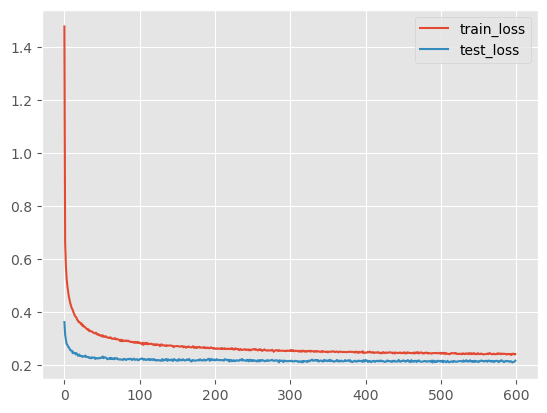

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
train_loss = pd.DataFrame(results['train_loss'], columns = ['train_loss'])
test_loss = pd.DataFrame(results['test_loss'], columns = ['test_loss'])
loss = pd.concat([train_loss,test_loss],axis =1)
loss.plot()

<Axes: >

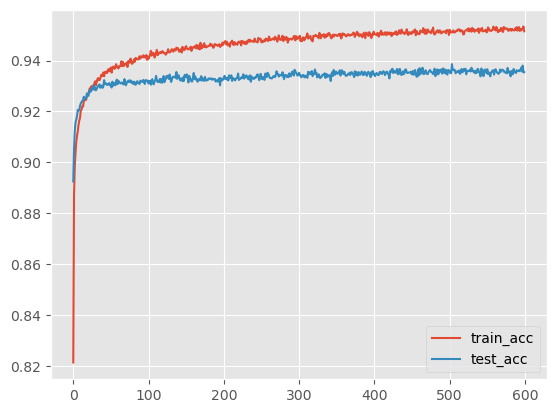

In [24]:
train_acc = pd.DataFrame(results['train_acc'], columns = ['train_acc'])
test_acc = pd.DataFrame(results['test_acc'], columns = ['test_acc'])
acc = pd.concat([train_acc,test_acc],axis =1)
acc.plot()

# 9. Testing accuracy after retraining pruned student_model

In [25]:
for i in range(50,61):
    checkpoint = torch.load(f"pruned_student_model/model_{10*i}.pth")
    pruned_net.load_state_dict(checkpoint)
    pruned_net.to(device)
    pruned_net.eval()
    correct = 0
    total = 0
    pred_arr = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = pruned_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_arr.append(predicted.item())
    accuracy = 100 * correct / total
    print(f"Epoch {10*i}")
    print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")

Epoch 500
Accuracy of the network on the 10000 test images: 93.62 %
Epoch 510
Accuracy of the network on the 10000 test images: 93.57 %
Epoch 520
Accuracy of the network on the 10000 test images: 93.67 %
Epoch 530
Accuracy of the network on the 10000 test images: 93.72 %
Epoch 540
Accuracy of the network on the 10000 test images: 93.54 %
Epoch 550
Accuracy of the network on the 10000 test images: 93.50 %
Epoch 560
Accuracy of the network on the 10000 test images: 93.45 %
Epoch 570
Accuracy of the network on the 10000 test images: 93.63 %
Epoch 580
Accuracy of the network on the 10000 test images: 93.58 %
Epoch 590
Accuracy of the network on the 10000 test images: 93.62 %
Epoch 600
Accuracy of the network on the 10000 test images: 93.54 %


In [26]:
checkpoint = torch.load(f"./pruned_student_model/model_530.pth") # load in best model
pruned_net.load_state_dict(checkpoint)
pruned_net.to(device)

StudentModel(
  (cnn): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=3)
      (pointwise): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (9): BatchNorm2d(12

In [27]:
for i,p in enumerate(param_to_prune):
    if p[0]._forward_pre_hooks:
        prune.remove(p[0],'weight')

In [28]:
torch.save(pruned_net.state_dict(),"./pruned_model_param.pt")

# 10. Final testing : Load in final model for testing

In [29]:
checkpoint = torch.load(f"pruned_model_param.pt")
pruned_net.load_state_dict(checkpoint)
pruned_net.to(device)
pruned_net.eval()
correct = 0
total = 0
pred_arr = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = pruned_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_arr.append(predicted.item())
accuracy = 100 * correct / total
print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")
pred_data = {"pred":pred_arr}
df_pred = pd.DataFrame(pred_data)
df_pred.to_csv('pred.csv', index_label='id')

Accuracy of the network on the 10000 test images: 93.72 %
